In [2]:
import pandas as pd
from catomatic.BinaryCatalogue import BinaryBuilder
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from protocols import utils
import os
import math
import pandas as pd
import numpy as np
import piezo
import multiprocessing as mp
from collections import defaultdict

import warnings
from pathlib import Path
import json
import seaborn as sns
import itertools

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'Helvetica'  
plt.rcParams['font.size'] =7 
plt.rcParams['figure.figsize'] = (6.69, 5.02)

warnings.simplefilter("ignore", category=DeprecationWarning)
%load_ext autoreload
%autoreload 2

# Intro

This notebook aims to build, optimise, and compare catomatic and WHO catalogues on various datasets. It contains the following sections:
- Data preperation functions
- Build and predict workflow demo with rifampicin
- Parameter grid search with catomatic built on crypticv3
- Performance comparisons:
    - catomatic_v1 vs whov1 on crypticv1
    - catomatic_v1 vs whov1 vs catomatic_v3 vs whov2 on crypticv3
- Catalgoue discordance analysis:
    - catomatic_v1 vs whov1
    - catomatic_v3 vs whov2

catomatic versions (v1/v3) simply indicate the cryptic dataset they were built on.

Important functions are defined here, the rest are imported from protocols/utils.py

# Data Prep Functions

In [157]:
def prep_phenotypes(drug, pheno_path, genomes_path, samples_path, version, validation=False):
    #import phenotypes and samples and genoms
    phenotypes = utils.read_data(pheno_path).reset_index()
    genomes = utils.read_data(genomes_path).reset_index()
    samples = utils.read_data(samples_path).reset_index()

    #filter down to matched samples only
    if version == 'v1':
        phenotypes = pd.merge(phenotypes, genomes, how='inner', on=['UNIQUEID'])
    elif version == 'v3.0.0':
        matched = pd.merge(samples, genomes, how='inner', on='UNIQUEID').UNIQUEID.unique()
        phenotypes = phenotypes[phenotypes.UNIQUEID.isin(matched)]
    elif version == 'v3.1.0':
        if validation:
            matched = samples[(samples.in_final_tables)&(samples.dataset=='CRyPTIC-v3.0')].UNIQUEID.unique()
            phenotypes = phenotypes[phenotypes.UNIQUEID.isin(matched)]
        else:
            matched = samples[(samples.in_final_tables)].UNIQUEID.unique()
            phenotypes = phenotypes[phenotypes.UNIQUEID.isin(matched)]

    #filter for drug
    phenotypes = phenotypes[phenotypes.DRUG==drug]
    #discoard low quality phenotypes
    if 'QUALITY' in phenotypes.columns:
        phenotypes = phenotypes[phenotypes.QUALITY!='LOW']
    #filter out non R/S phenotypes
    phenotypes = phenotypes[phenotypes.PHENOTYPE.isin(['R', 'S'])]
    #handle duplicates (keep R if R, otherwise first)
    phenotypes = phenotypes.groupby("UNIQUEID", group_keys=False).apply(utils.filter_multiple_phenos).reset_index(drop=True)
    # filter relevant columns for catomatic and rename id column
    phenotypes = phenotypes[['UNIQUEID', 'DRUG', 'PHENOTYPE', 'METHOD_MIC', 'METHOD_3']]
    return phenotypes

drug_genes = {
    "AMI": ["eis", "rrs"],
    "CAP": ["rrs", "tlyA"],
    "CIP": ["gyrA"],
    "DLM": ["ddn"],
    "EMB": ["embA", "embB"],
    "ETH": ["ethA", "fabG1", "inhA"],
    "INH": ["katG", "inhA", "ahpC", "fabG1"],
    "KAN": ["eis", "rrs"],
    "LEV": ["gyrA", "gyrB"],
    "LZD": ["rplC"],
    "MXF": ["gyrA", "gyrB"],
    "RIF": ["rpoB"],
    "STM": ["gid", "rpsL", "rrs"]
}

def prep_mutations(path, genes, version, mut_path, var_path, train=True):
    #Uses most up to date mutations table, as this should contain all genomes from previous versions
    mut_dir = f"{path}{'_'.join(genes)}_MUTATIONS.csv"
    var_dir = f"{path}{'_'.join(genes)}_VARIANTS.csv"
    if not os.path.exists(mut_dir):
        mutations = utils.read_data(mut_path).reset_index()
        variants = utils.read_data(var_path).reset_index()
        mutations[mutations.GENE.isin(genes)].to_csv(mut_dir)
        variants[variants.GENE.isin(genes)].to_csv(var_dir)

    mutations = pd.read_csv(mut_dir, low_memory=False)
    variants = pd.read_csv(var_dir, low_memory=False)

    if version == 'v1':
        variants['FRS'] = variants.apply(lambda row: 1 if row['IS_FILTER_PASS'] is True else row['COVERAGE'] / row['DP'], axis=1)
        mutations = pd.merge(mutations, variants[['UNIQUEID', 'GENE', 'POSITION', 'FRS']], on=['UNIQUEID', 'GENE', 'POSITION'], how='left')
        mutations = mutations[~mutations.IS_NULL]

    elif version == 'v3.0.0':
        variants["FRS"] = variants.apply(lambda row: row["MINOR_READS"] / row["COVERAGE"] if row["MINOR_READS"] > 0 else 1, axis=1) 
        mutations = pd.merge(mutations, variants[['UNIQUEID', 'GENE', 'GENE_POSITION', 'FRS']], on=['UNIQUEID', 'GENE', 'GENE_POSITION'], how='left')
        mutations = mutations[~mutations.IS_NULL]
        mutations['MUTATION'] = mutations.apply(
        lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR'] else x['MUTATION']}",
        axis=1,
        )
    elif version == 'v3.1.0':
        #recalcaulte FRS from variants table to be 100% sure
        variants["FRS"] = variants.apply(lambda row: row["MINOR_READS"] / row["COVERAGE"] if row["MINOR_READS"] > 0 else 1, axis=1) 
        mutations = mutations.drop(columns=['FRS'])
        mutations = pd.merge(mutations, variants[['UNIQUEID', 'GENE', 'GENE_POSITION', 'FRS']], on=['UNIQUEID', 'GENE', 'GENE_POSITION'], how='left')
        mutations = mutations[~mutations.IS_NULL]
        mutations['MUTATION'] = mutations.apply(
        lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR'] else x['MUTATION']}",
        axis=1,
        )


    #flag synonymous mutations
    mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1])
    #filter out synonymous mutations
    if train:
        #if validating, would keep synonymous mutations
        mutations = mutations[~mutations.IS_SYNONYMOUS]
    #drop duplicate entries 
    mutations = mutations.drop_duplicates(['UNIQUEID', 'MUTATION', 'FRS'], keep='first')
    # filter relevant columns for catomatic and rename id column
    mutations = mutations[['UNIQUEID', 'MUTATION', 'FRS']].rename(columns={'ENA_RUN': 'UNIQUEID'})
    return mutations




# Catalogue Construction workflow

The following functions are used to import the data tables, and prepare them for catomatic for a particular drug and defined set of candidate genes.

In [ ]:
phenotypes = prep_phenotypes('RIF', 'data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl', 'data/cryptic-tables-v1/GENOMES.pkl.gz',  'data/cryptic-tables-v1/SAMPLES.pkl.gz', version='v1')
phenotypes

UNIQUEID DRUG PHENOTYPE METHOD_MIC  \
0      site.00.subj.1000347.lab.H111540004.iso.1  RIF         R        NaN   
1      site.00.subj.1000595.lab.H123460044.iso.1  RIF         R        NaN   
2      site.00.subj.1004213.lab.H111060034.iso.1  RIF         R        NaN   
3      site.00.subj.1004213.lab.H112000008.iso.1  RIF         R        NaN   
4      site.00.subj.1004213.lab.H113100007.iso.1  RIF         R        NaN   
...                                          ...  ...       ...        ...   
37169     site.ENA.subj.SAMN08892584.lab.1.iso.1  RIF         S        NaN   
37170     site.ENA.subj.SAMN08892585.lab.1.iso.1  RIF         R        NaN   
37171     site.ENA.subj.SAMN08892586.lab.1.iso.1  RIF         S        NaN   
37172     site.ENA.subj.SAMN08892587.lab.1.iso.1  RIF         S        NaN   
37173     site.ENA.subj.SAMN08892588.lab.1.iso.1  RIF         R        NaN   

               METHOD_3  
0      resistance ratio  
1      resistance ratio  
2      resistance ratio  
3      resistance ratio  
4      resistance ratio  
...                 ...  
37169                    
37170                    
37171                    
37172                    
37173                    

[37174 rows x 5 columns]

In [5]:
mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes["RIF"], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet')
mutations

UNIQUEID    MUTATION       FRS
0                     site.02.subj.0069.lab.22A019.iso.1  rpoB@S450L  1.000000
4      site.03.subj.6236-05_LIB12062.lab.6236-05_LIB1...  rpoB@S450L  1.000000
5                    site.04.subj.00255.lab.709124.iso.1  rpoB@S450L  1.000000
8           site.06.subj.RLH_0305-14.lab.06MIL0297.iso.1  rpoB@c-61t  1.000000
9           site.06.subj.RLH_0305-14.lab.06MIL0297.iso.1  rpoB@S450L  1.000000
...                                                  ...         ...       ...
76711               site.ENA.subj.SRR6824487.lab.1.iso.1  rpoB@L430P  1.000000
76713               site.ENA.subj.SRR6824487.lab.1.iso.1  rpoB@C701W  0.665236
76714               site.ENA.subj.SRR5551664.lab.1.iso.1  rpoB@S450L  1.000000
76716               site.ENA.subj.ERR7911708.lab.1.iso.1  rpoB@S450L  1.000000
76717               site.ENA.subj.ERR7911708.lab.1.iso.1  rpoB@T400A  0.262500

[30335 rows x 3 columns]

## Build a catalogue for rifampicin

In [6]:
catalogue = BinaryBuilder(samples=phenotypes, mutations=mutations, FRS=0.1).build(test='Binomial', background=0.2, strict_unlock=True, p=0.95)
catalogue_df = catalogue.build_piezo(genbank_ref='NC00962.3', catalogue_name='rif_demo', version='0.0', drug='RIF', wildcards="./data/wildcards/rif_wildcards.json", json_dumps=True)
catalogue_df.to_csv('./catalogues/temp/demo_rif_catalogue.csv')
catalogue_df

GENBANK_REFERENCE CATALOGUE_NAME CATALOGUE_VERSION CATALOGUE_GRAMMAR  \
0           NC00962.3       rif_demo               0.0             GARC1   
1           NC00962.3       rif_demo               0.0             GARC1   
2           NC00962.3       rif_demo               0.0             GARC1   
3           NC00962.3       rif_demo               0.0             GARC1   
4           NC00962.3       rif_demo               0.0             GARC1   
..                ...            ...               ...               ...   
402         NC00962.3       rif_demo               0.0             GARC1   
403         NC00962.3       rif_demo               0.0             GARC1   
404         NC00962.3       rif_demo               0.0             GARC1   
405         NC00962.3       rif_demo               0.0             GARC1   
406         NC00962.3       rif_demo               0.0             GARC1   

    PREDICTION_VALUES DRUG              MUTATION PREDICTION SOURCE  \
0                 RUS  RIF            rpoB@c-61t          S     {}   
1                 RUS  RIF  rpoB@2546_ins_cgagga          S     {}   
2                 RUS  RIF            rpoB@E250G          S     {}   
3                 RUS  RIF            rpoB@L449Q          S     {}   
4                 RUS  RIF            rpoB@V695L          S     {}   
..                ...  ...                   ...        ...    ...   
402               RUS  RIF         rpoB@-*_indel          U     {}   
403               RUS  RIF          rpoB@*_indel          U     {}   
404               RUS  RIF              rpoB@-*?          U     {}   
405               RUS  RIF               rpoB@*?          U     {}   
406               RUS  RIF          rpoB@del_0.0          U     {}   

                                              EVIDENCE OTHER  
0    {"proportion": 0.007273706896551724, "confiden...    {}  
1    {"proportion": 0.0, "confidence": [0.0, 0.0675...    {}  
2    {"proportion": 0.043478260869565216, "confiden...    {}  
3    {"proportion": 0.0, "confidence": [0.0, 0.0770...    {}  
4    {"proportion": 0.056338028169014086, "confiden...    {}  
..                                                 ...   ...  
402                           {"default_rule": "True"}    {}  
403                           {"default_rule": "True"}    {}  
404                           {"default_rule": "True"}    {}  
405                           {"default_rule": "True"}    {}  
406                           {"default_rule": "True"}    {}  

[407 rows x 11 columns]

In [7]:
catalogue_df.PREDICTION.value_counts()

PREDICTION
U    356
R     40
S     11
Name: count, dtype: int64

### Use the catalogue to predict phenotypes


Now that we have built a catalogue for rifampicin, we can apply a simple prediction algorithm to test its senstivity for predicting resistance.

We can do this on the same dataset used to build the catalogues, but crucially, we also have a totally independent validation set.

[[ 9828  1201   240]
 [  356 24629   920]]
Catalogue coverage of isolates: 0.9687953946306558
Sensitivity: 0.8911052679300027
Specificity: 0.9857514508705223


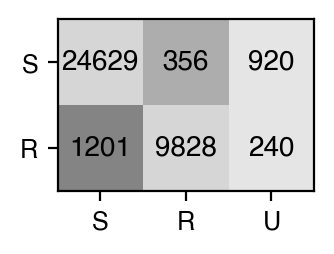

In [8]:
#test performance on training set

all = pd.merge(phenotypes, mutations[mutations.FRS>=0.1], on=['UNIQUEID'], how='left')
#note, this merge assumes the phenotypes df only contains samples that have been genotyped
cm = utils.piezo_predict(iso_df=all, drug='RIF', catalogue_file='./catalogues/temp/demo_rif_catalogue.csv', U_to_S=False, Print=True)[0]
cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", 'U'])

utils.plot_truthtables(cm, U_to_S=False, colors=["#666666", "#cccccc", "#999999", "#cccccc","#cccccc","#cccccc" ])

# Parameter Grid search

Build catalogues for all drugs on crypticv1 via a grid search, and choose the optimal parameters and 'flagship' catalogues.

Parameters are background and p-value.

Also investigate the effect of FRS on these chosen catalogues.

#### Background and p value

In [10]:
# Function to process one combination of drug, background, and p-value
def process_grid_search(args):
    drug, genes, mutations_dir, phenotypes_path, genomes_path, samples_path, mut_path, var_path, catfile_dir, FRS, background, p, geno_version, pheno_version = args

    results = {}

    mutations = prep_mutations(mutations_dir, genes, version=geno_version, mut_path=mut_path, var_path=var_path, train=True)
    test_mutations = prep_mutations(mutations_dir, genes, version=geno_version, mut_path=mut_path, var_path=var_path, train=False)
    phenotypes = prep_phenotypes(drug, phenotypes_path, genomes_path, samples_path , version=pheno_version)
    catfile = f"{catfile_dir}/{drug.lower()}/bg_{background}_p_{p}_FRS_{FRS}.csv"
    
    if not os.path.exists(catfile):
        catalogue = BinaryBuilder(samples=phenotypes, mutations=mutations, FRS=FRS).build(test='Binomial', background=background, strict_unlock=True, p=p)
        catalogue.to_piezo(genbank_ref='NC00962.3', catalogue_name=f'{drug}-{background}-{p}', version='0.0', 
                           drug=drug, wildcards=f"./data/wildcards/{drug.lower()}_wildcards.json", json_dumps=True, outfile=catfile)

    all_data = pd.merge(phenotypes, test_mutations[test_mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
    cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all_data, drug=drug, catalogue_file=catfile, U_to_S=False, Print=False)
    results[(drug, background, p)] = {"cm": cm, "cov": cov, "sens": sens, "spec": spec}
    return results

# Main function for parallel execution
def parallel_grid_search(mutations_dir, phenotypes_path, genomes_path, samples_path, mut_path, var_path, catfile_dir, FRS, geno_version, pheno_version, cores):
    grid_results = {}
    # Create list of tasks to parallelize
    tasks = []
    for drug, genes in drug_genes.items():
        for background in [0.05, 0.10, 0.15, 0.20, 0.25]:
            for p in [0.9, 0.95]:
                tasks.append((drug, genes, mutations_dir, phenotypes_path, genomes_path, samples_path, mut_path, var_path, catfile_dir, FRS, background, p, geno_version, pheno_version))

    ctx = mp.get_context("fork")  
    num_workers = min(cores, len(tasks))
    with ctx.Pool(num_workers) as pool:
        all_results = pool.map(process_grid_search, tasks)  # Run in parallel

    for result in all_results:
        grid_results.update(result)
    return grid_results


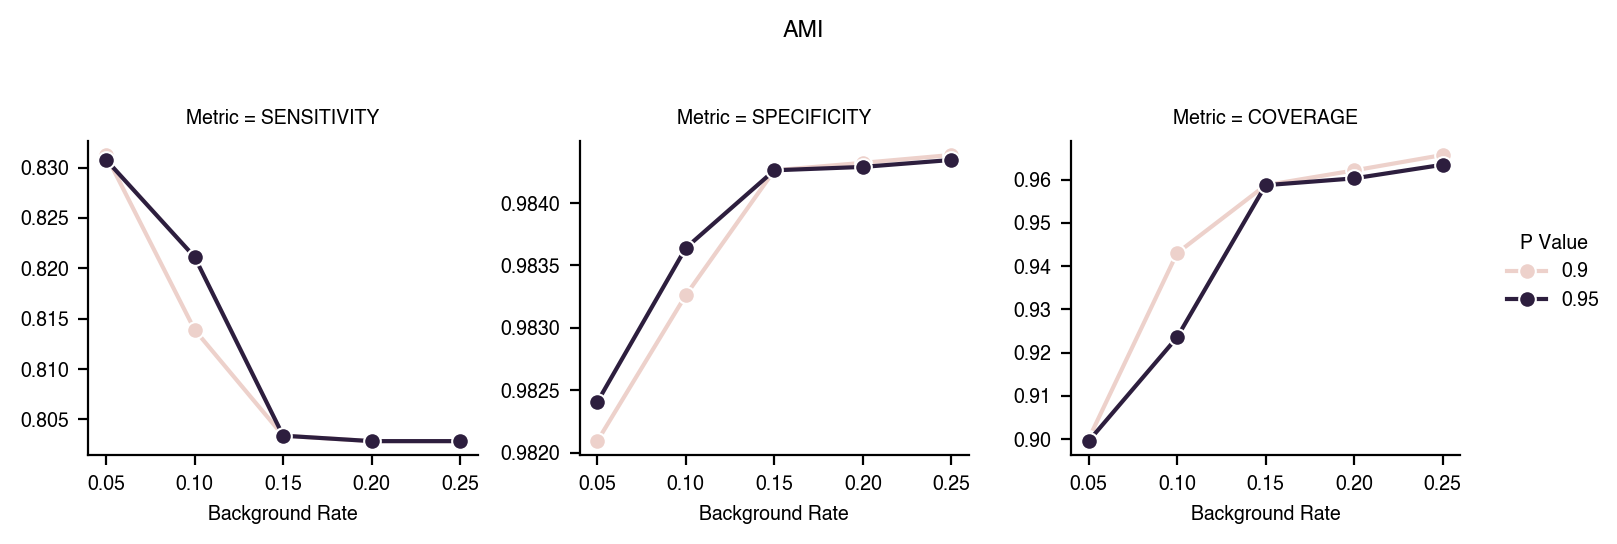

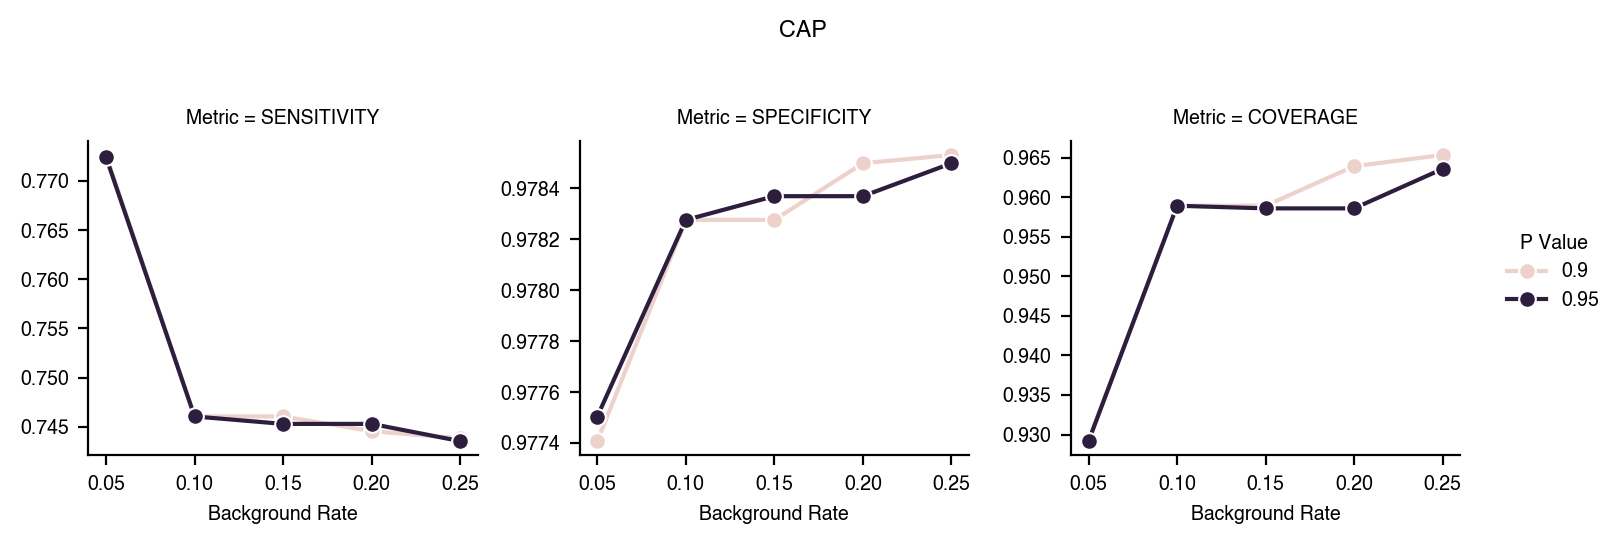

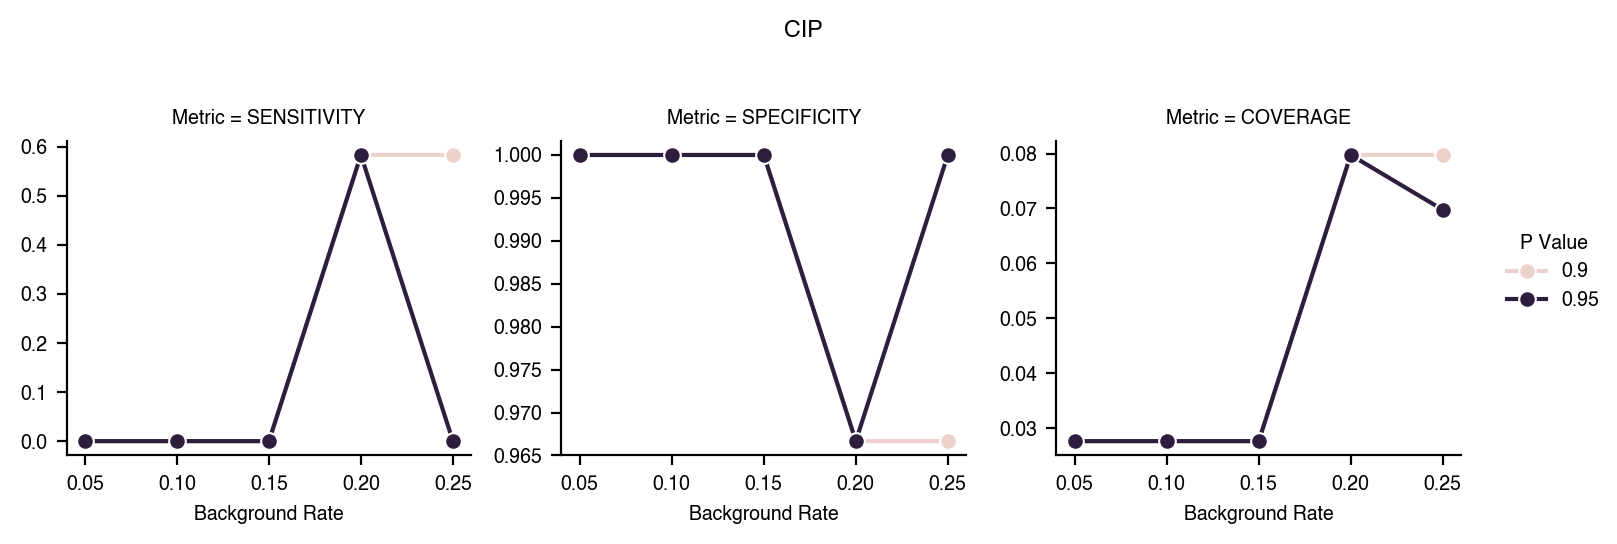

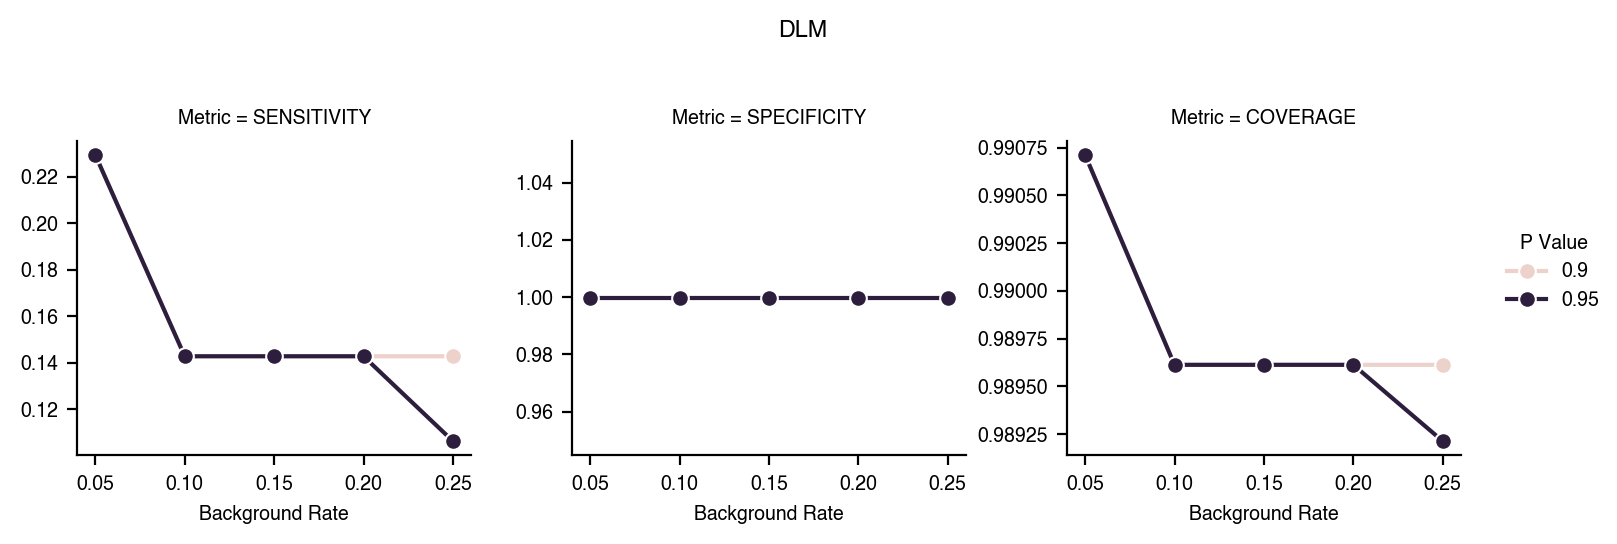

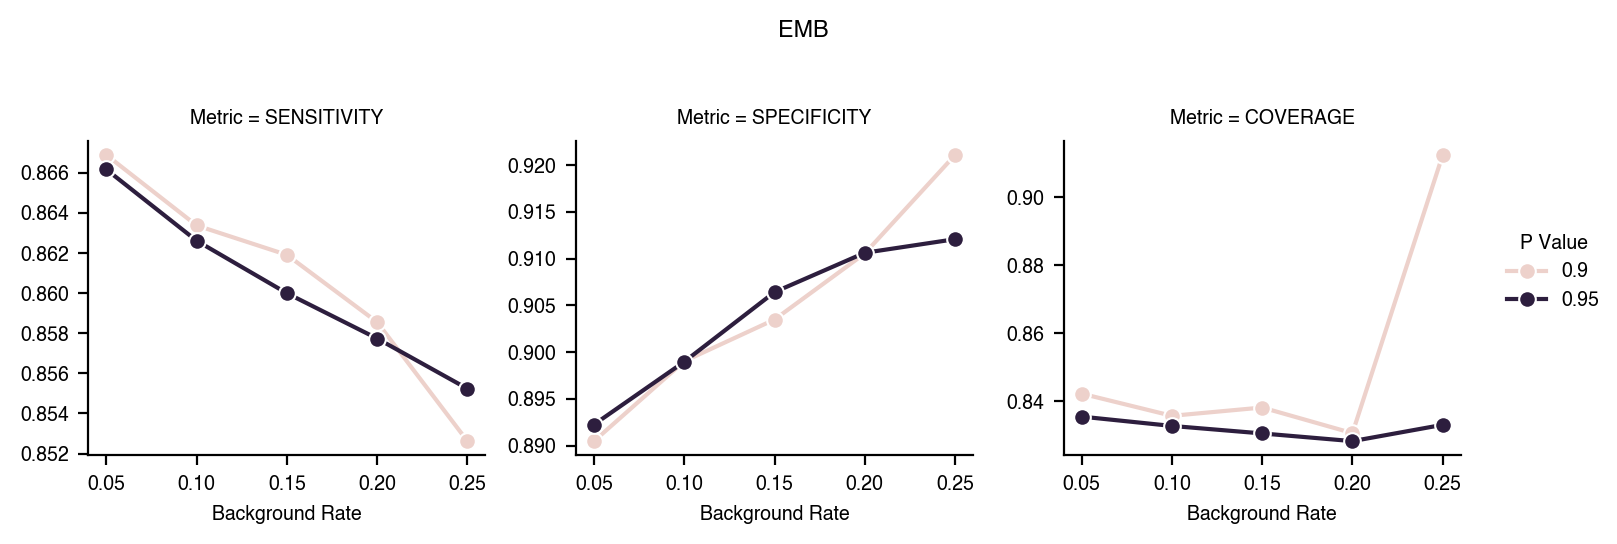

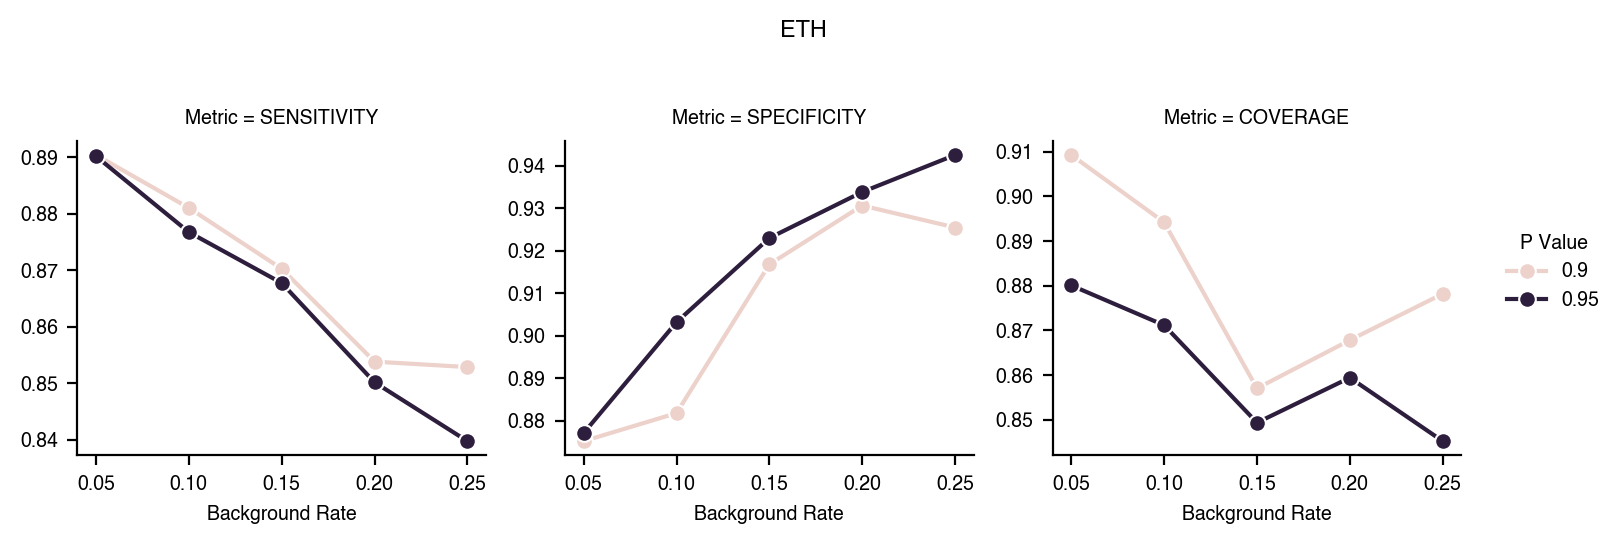

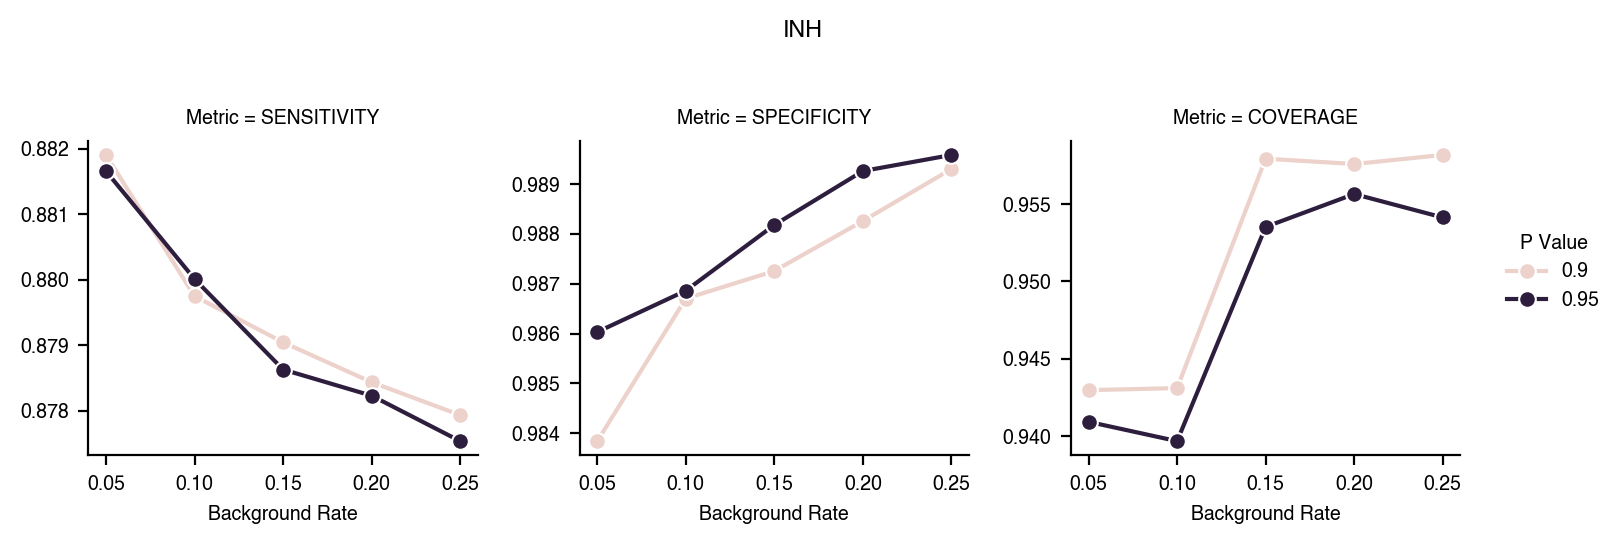

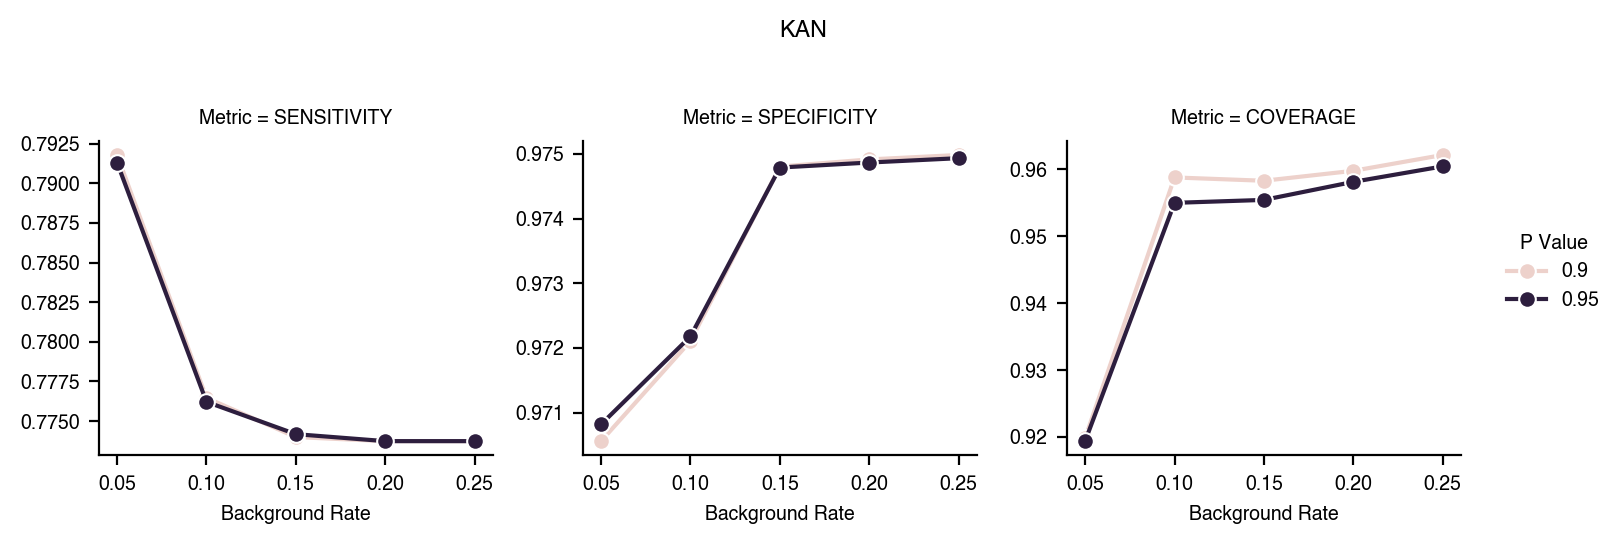

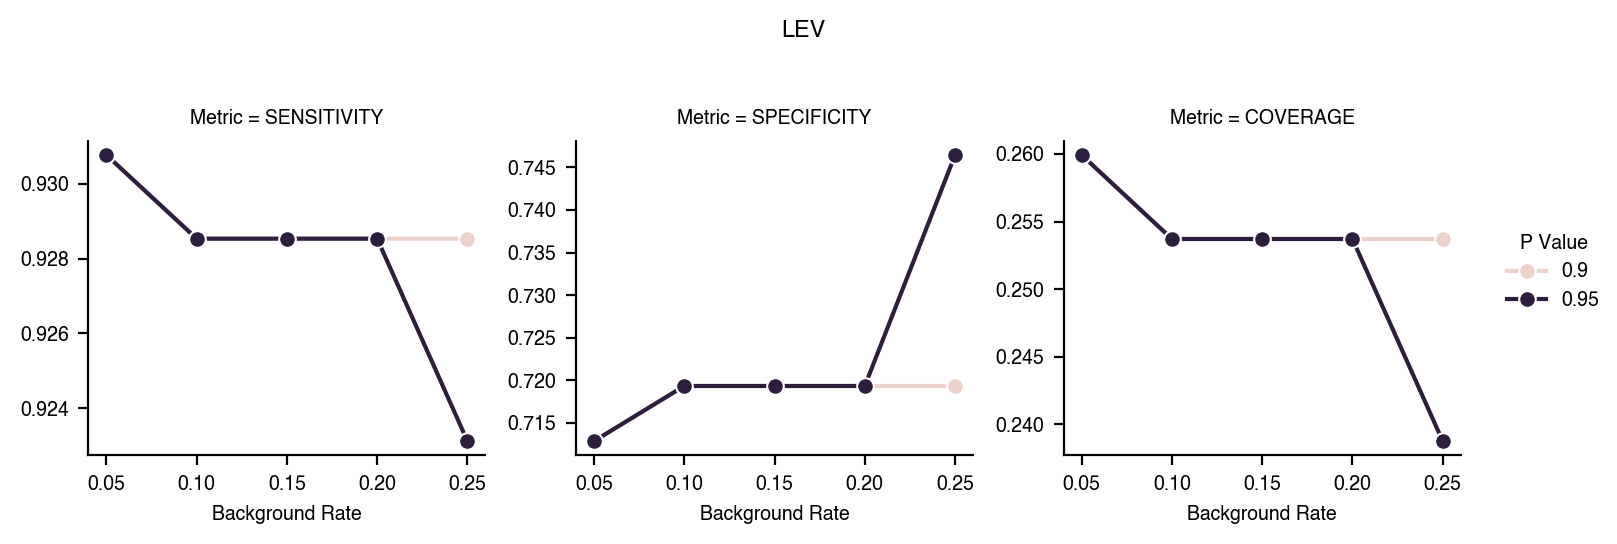

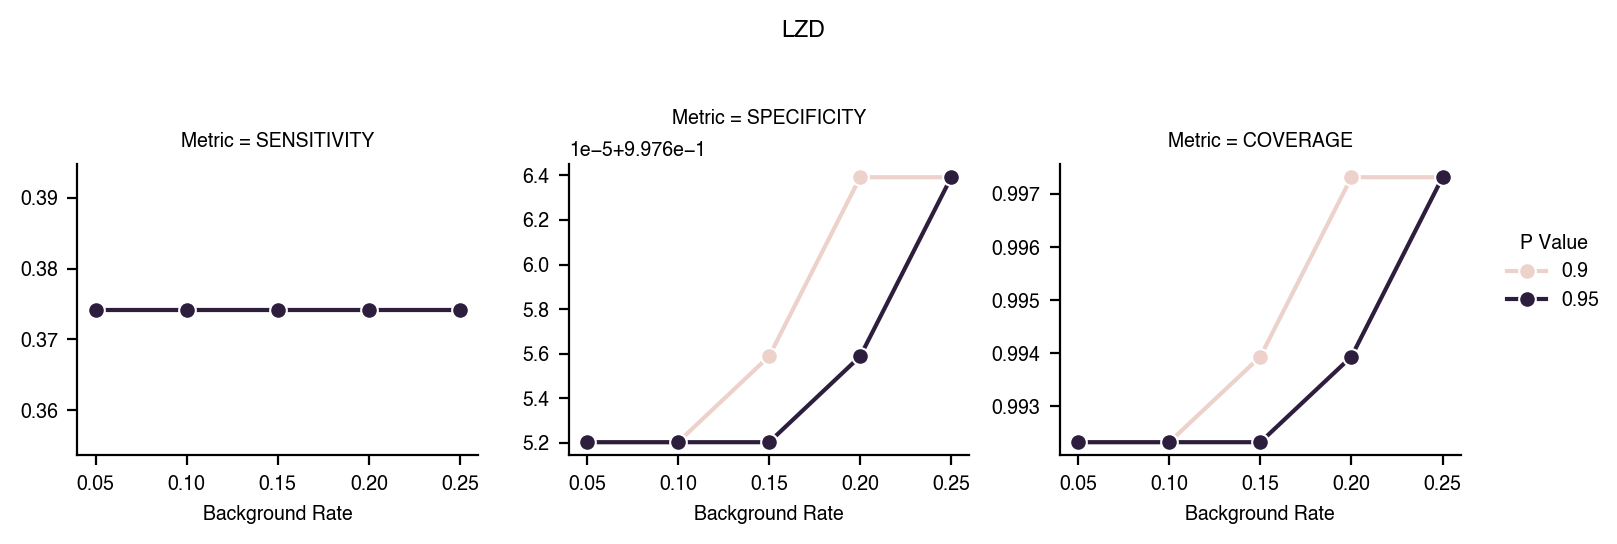

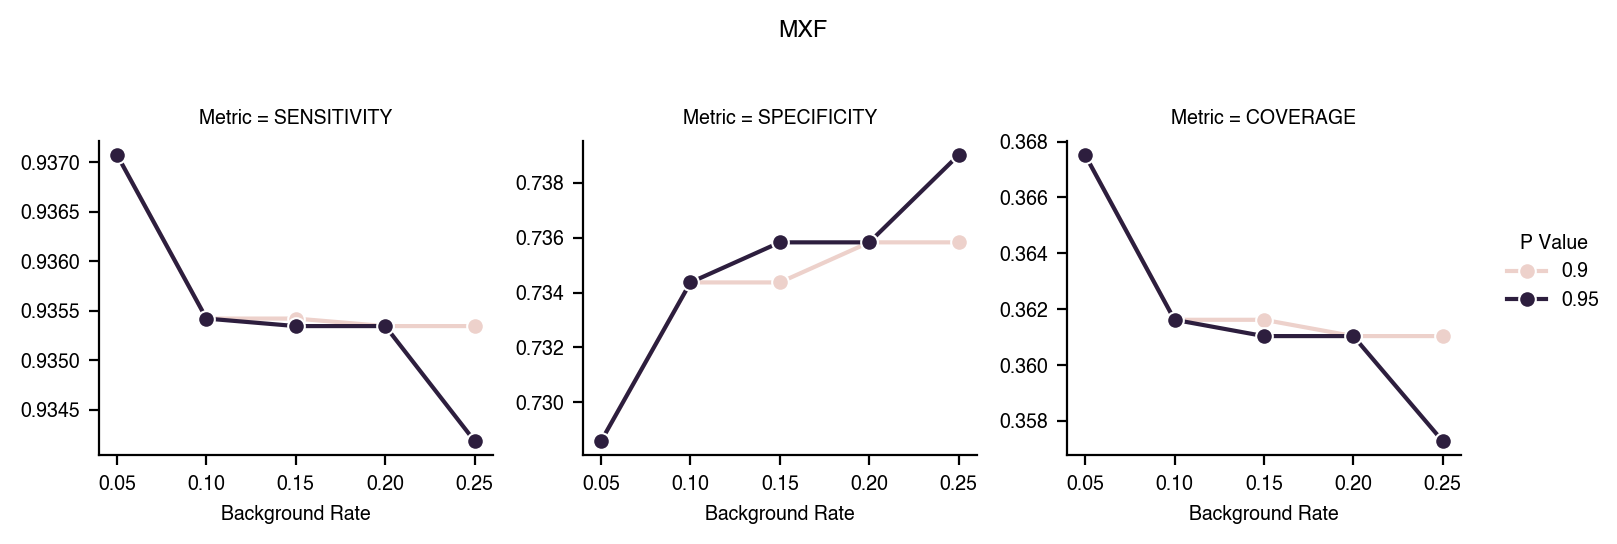

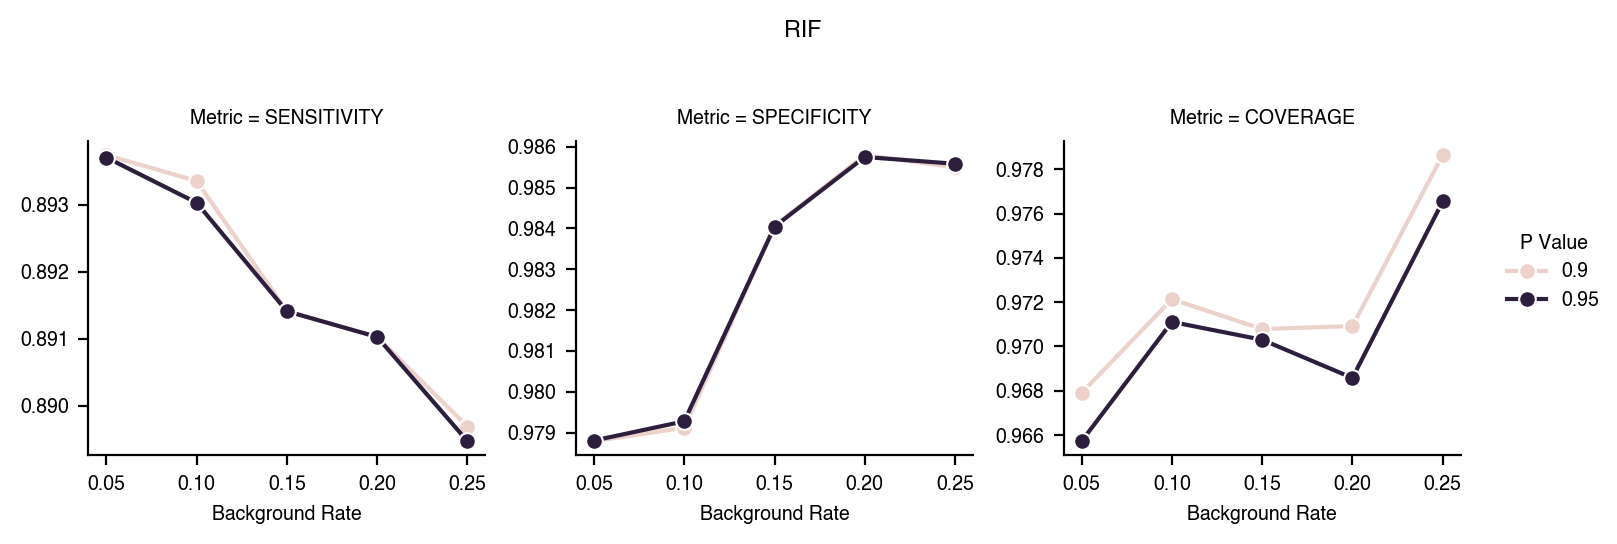

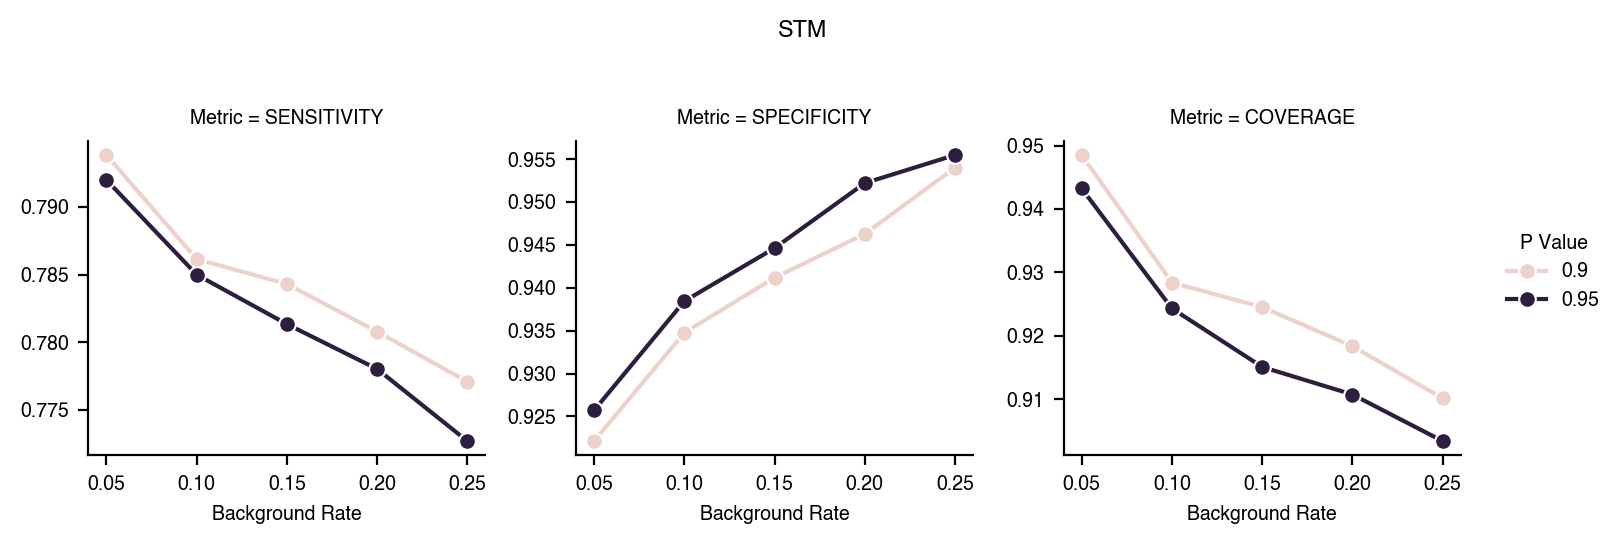

In [15]:
#run grid search on crypticv3 samples
grid_results = parallel_grid_search(
    "data/mutations-v3.1.0/",
    "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl.",
    "data/cryptic-tables-v1/GENOMES.pkl.gz",
    "data/cryptic-tables-v1/SAMPLES.pkl.gz",
    "data/cryptic-tables-v3.1.0/MUTATIONS.parquet",
    "data/cryptic-tables-v3.1.0/VARIANTS.parquet",
    "catalogues/cryptic-v1/grid_search/",
    0.1,
    'v3.1.0',
    'v1',
    cores=10 #best to run with 1 core when first generating mutations and variants tables, as mem requirements are steep!!
)

df = utils.flatten_grid_results(grid_results)

# Melt the DataFrame for plotting
melted_df = df.melt(
    id_vars=["DRUG", "BACKGROUND_RATE", "p_value"],
    value_vars=["SENSITIVITY", "SPECIFICITY", "COVERAGE"],
    var_name="Metric",
    value_name="Value",
)

for drug in melted_df["DRUG"].unique():
    drug_data = melted_df[melted_df["DRUG"] == drug]
    g = sns.FacetGrid(drug_data, col="Metric", col_wrap=3, sharey=False, height=2.5)
    g.map_dataframe(
        sns.lineplot, x="BACKGROUND_RATE", y="Value", hue="p_value", marker="o"
    )
    g.set_axis_labels("Background Rate", "")
    g.add_legend(title="P Value")
    g.figure.suptitle(drug, y=1.05)
    g.tight_layout()
    plt.show()

In [16]:
#determine best performing catalogue
opt_cats_v1 = utils.weighted_score(df).groupby("DRUG").head(1).reset_index(drop=True)
#pull out R, S, U counts from catalogue
cat_counts = pd.DataFrame([
    {
        "DRUG": opt_cats_v1['DRUG'][i],
        "R": cat["PREDICTION"].value_counts().get("R", 0),
        "S": cat["PREDICTION"].value_counts().get("S", 0),
        "U": cat["PREDICTION"].value_counts().get("U", 0),
        "Total": len(cat)
    }
    for i in opt_cats_v1.index
    for cat in [pd.read_csv(f"./catalogues/cryptic-v1/grid_search/{opt_cats_v1['DRUG'][i].lower()}/bg_{opt_cats_v1['BACKGROUND_RATE'][i]}_p_{opt_cats_v1['p_value'][i]}_FRS_0.1.csv")]
])

opt_cats_v1 = pd.merge(opt_cats_v1, cat_counts, on='DRUG')
opt_cats_v1['catalogue'] = 'catomatic_v1'
opt_cats_v1

DRUG  BACKGROUND_RATE  p_value  SENSITIVITY  SPECIFICITY  COVERAGE  \
0   RIF             0.25     0.90     0.889687     0.985499  0.978641   
1   INH             0.25     0.90     0.877932     0.989305  0.958179   
2   AMI             0.10     0.90     0.813906     0.983262  0.943018   
3   ETH             0.05     0.90     0.890384     0.875237  0.909262   
4   EMB             0.25     0.90     0.852621     0.921077  0.912440   
5   KAN             0.25     0.90     0.773735     0.974982  0.962159   
6   CAP             0.05     0.90     0.772638     0.977407  0.929333   
7   STM             0.05     0.90     0.793834     0.922120  0.948519   
8   MXF             0.15     0.95     0.935345     0.735830  0.361037   
9   LEV             0.25     0.95     0.923125     0.746462  0.238770   
10  LZD             0.20     0.90     0.374194     0.997664  0.997314   
11  DLM             0.05     0.90     0.229358     0.999694  0.990711   
12  CIP             0.25     0.90     0.583333     0.966667  0.079734   

       Score    R   S    U  Total     catalogue  
0   0.936221   44  23  352    419  catomatic_v1  
1   0.927394   50  22  596    668  catomatic_v1  
2   0.890535    4  12  360    376  catomatic_v1  
3   0.889615  286   4  349    639  catomatic_v1  
4   0.885122   17  52  949   1018  catomatic_v1  
5   0.871794    7  17  357    381  catomatic_v1  
6   0.865408   43   4  224    271  catomatic_v1  
7   0.863256  211   7  378    596  catomatic_v1  
8   0.760629    7   3   70     80  catomatic_v1  
9   0.733255    5   3   68     76  catomatic_v1  
10  0.685859    1   5   29     35  catomatic_v1  
11  0.612729   14   1   47     62  catomatic_v1  
12  0.597614    2   2    6     10  catomatic_v1

#### Fraction Read Support

In [160]:
build_frs_values = np.arange(0.1, 1.0, 0.1)
test_frs_values = np.arange(0.1, 1.0, 0.1)

# Shared memory dictionaries for storing results
manager = mp.Manager()
sensitivity_matrix = manager.dict()
specificity_matrix = manager.dict()
coverage_matrix = manager.dict()

def process_drug_frs(drug):
    mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=True)
    test_mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=False)
    phenotypes = prep_phenotypes(
        drug,
        "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl.",
        "data/cryptic-tables-v1/GENOMES.pkl.gz",
        "data/cryptic-tables-v1/SAMPLES.pkl.gz",
        'v1'
    )
    
    background, p = opt_cats_v1.loc[opt_cats_v1.DRUG == drug, ['BACKGROUND_RATE', 'p_value']].iloc[0]
    sens_results, spec_results, cov_results = {}, {}, {}
    
    for build_FRS in build_frs_values:
        catfile = f"./catalogues/cryptic-v1/frs/{drug.lower()}/bg_{background}_p_{p}_FRS_{build_FRS}.csv"
        catalogue = BinaryBuilder(samples=phenotypes, mutations=mutations, FRS=build_FRS).build(
            test='Binomial', background=background, strict_unlock=True, p=p
        )
        catalogue.to_piezo(
            genbank_ref='NC00962.3',
            catalogue_name=f'{drug}-{background}-{p}-{build_FRS}',
            version='0.0',
            drug=drug,
            wildcards=f"./data/wildcards/{drug.lower()}_wildcards.json",
            json_dumps=True,
            outfile=catfile
        )
        
        sens_results[build_FRS], spec_results[build_FRS], cov_results[build_FRS] = {}, {}, {}
        
        for test_FRS in test_frs_values:
            all_data = pd.merge(
                phenotypes, 
                test_mutations[test_mutations.FRS >= test_FRS], 
                on=['UNIQUEID'], 
                how='left'
            )
            cm, cov, sens, spec, _, _ = utils.piezo_predict(
                iso_df=all_data, drug=drug, catalogue_file=catfile, U_to_S=False, Print=False
            )
            sens_results[build_FRS][test_FRS] = sens * 100
            spec_results[build_FRS][test_FRS] = spec * 100
            cov_results[build_FRS][test_FRS] = cov * 100
    
    sensitivity_matrix[drug] = sens_results
    specificity_matrix[drug] = spec_results
    coverage_matrix[drug] = cov_results

# Parallel execution
mp.set_start_method('fork', force=True)
with mp.Pool(mp.cpu_count() - 1) as pool:
    pool.map(process_drug_frs, opt_cats_v1['DRUG'])



OUTFILE ./catalogues/cryptic-v1/frs/mxf/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/cap/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/kan/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/ami/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/eth/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/stm/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/rif/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/inh/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/emb/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/cap/bg_0.05_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/cryptic-v1/frs/eth/bg_0.05_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/cryptic-v1/frs/kan/bg_0.1_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/cryptic-v1/frs/ami/bg_0.05_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/cryptic-v1/frs/stm/bg_0.05_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/cryptic-v1/frs/cap/bg_0.05_p_0.9_FRS_0.30000000000000004.

ValueError: Length mismatch: Expected axis has 2 elements, new values have 4 elements

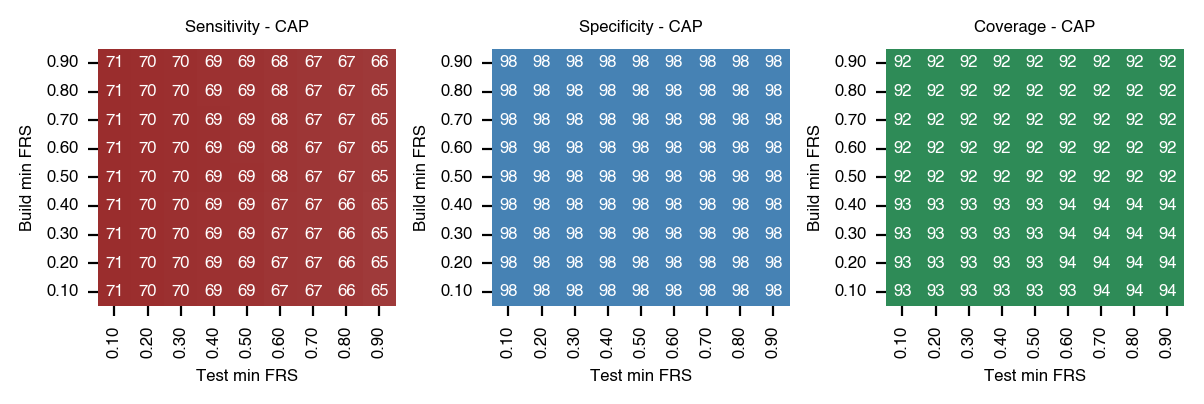

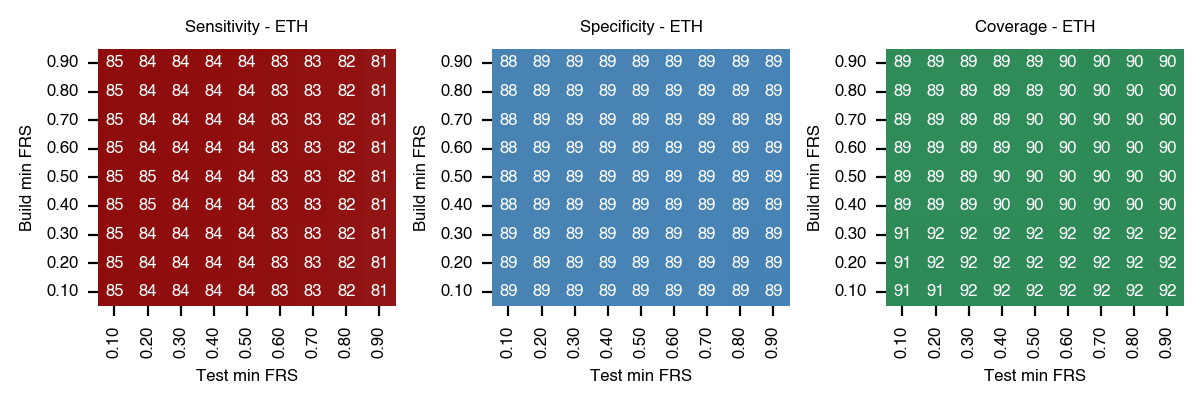

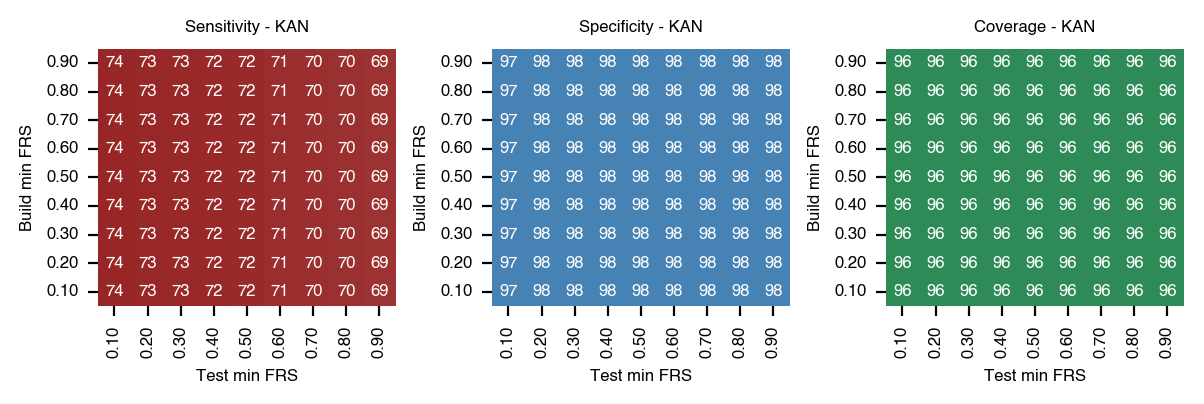

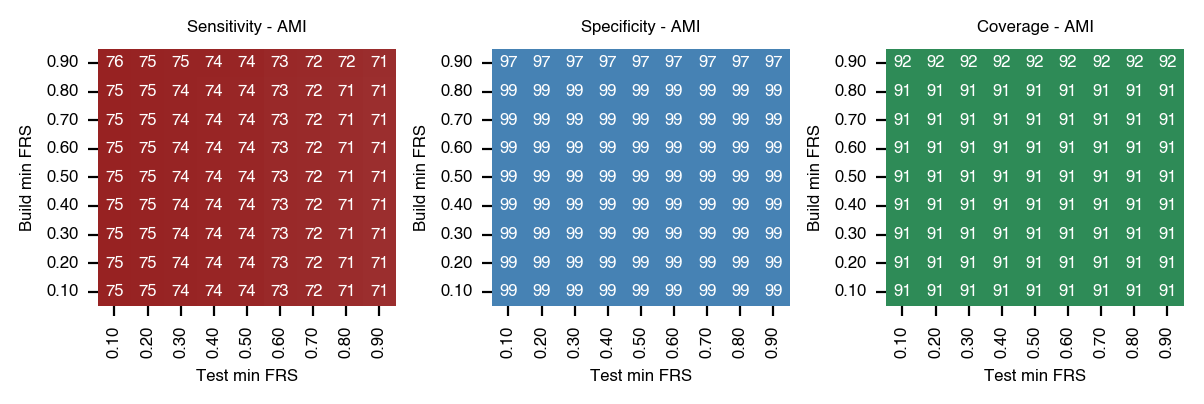

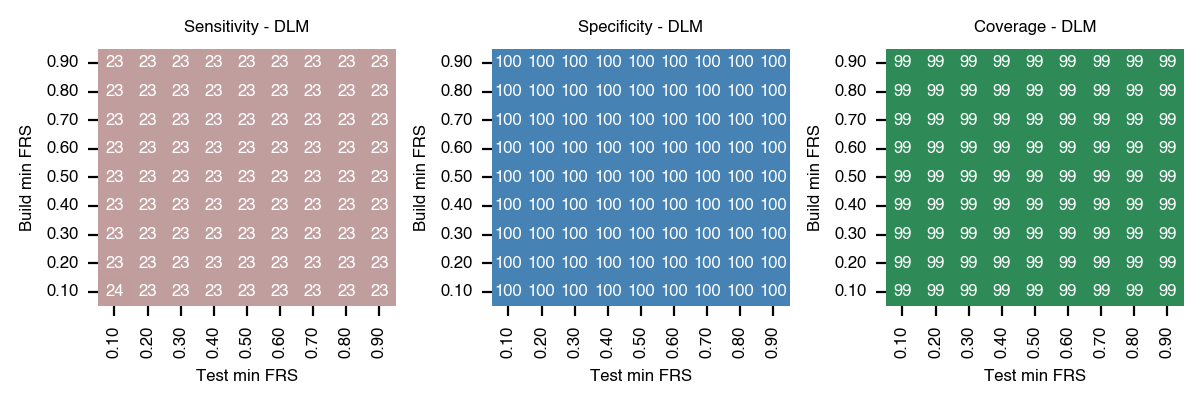

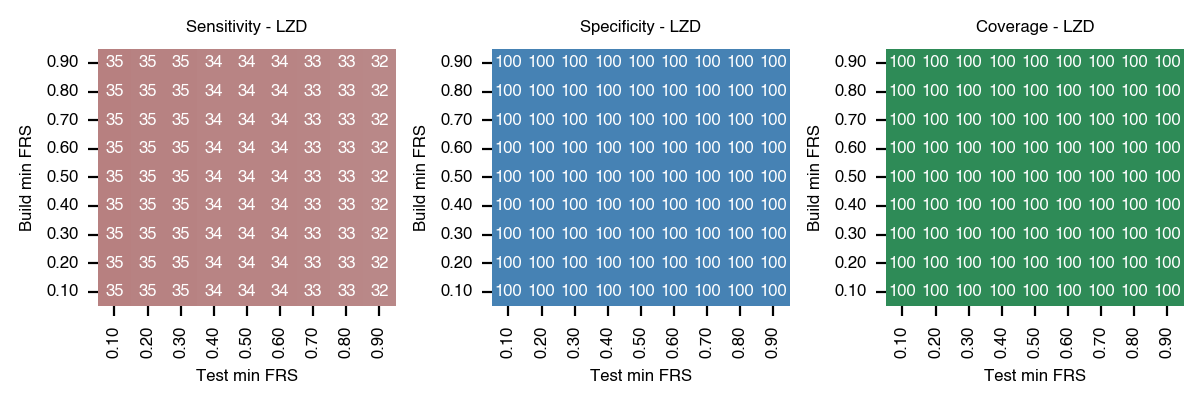

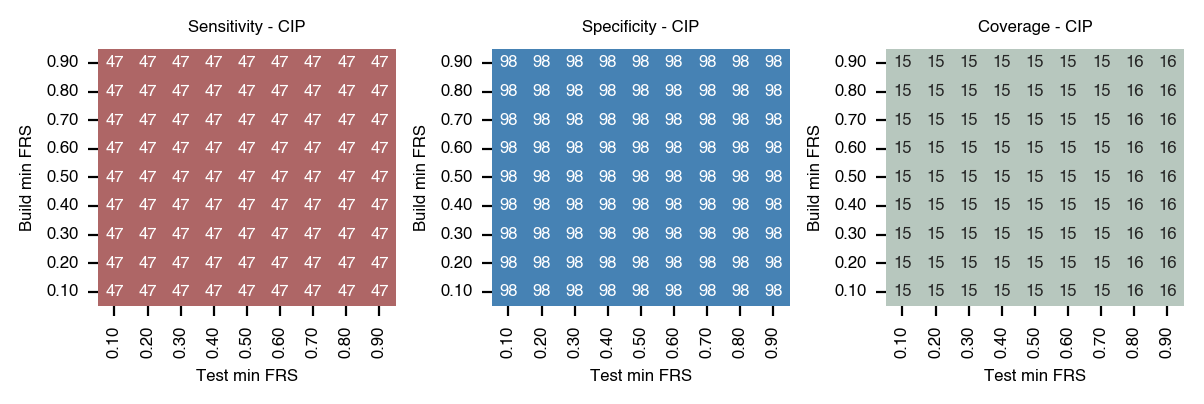

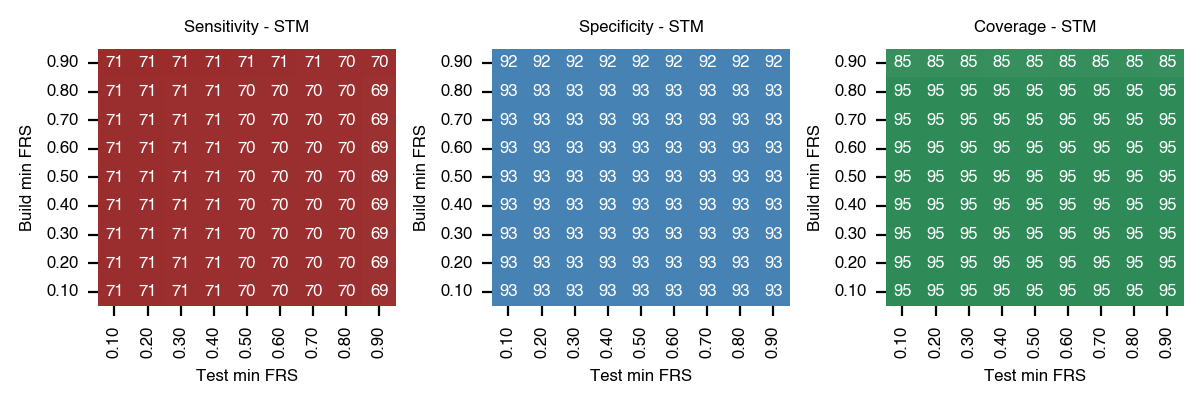

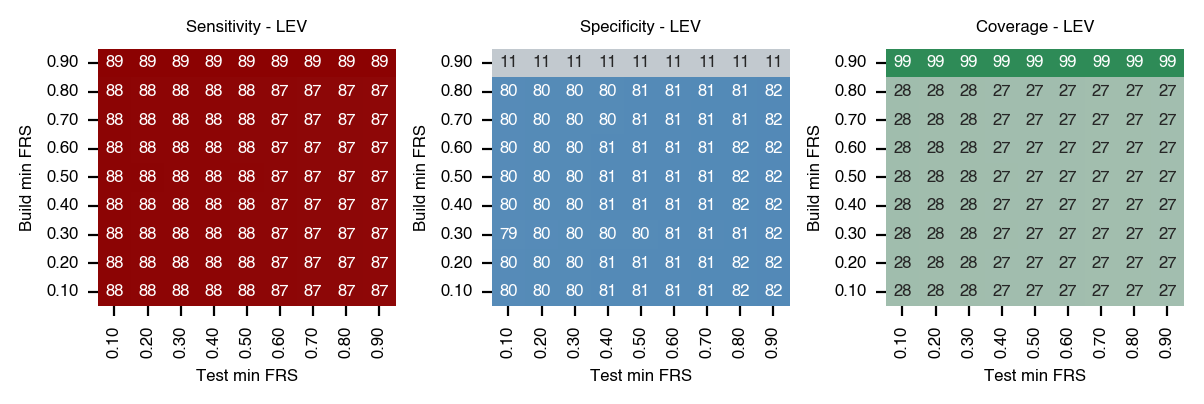

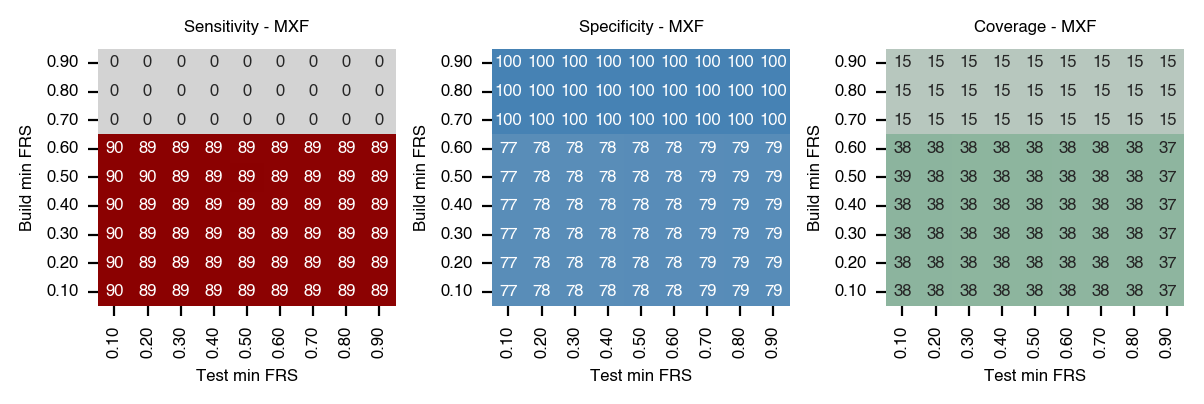

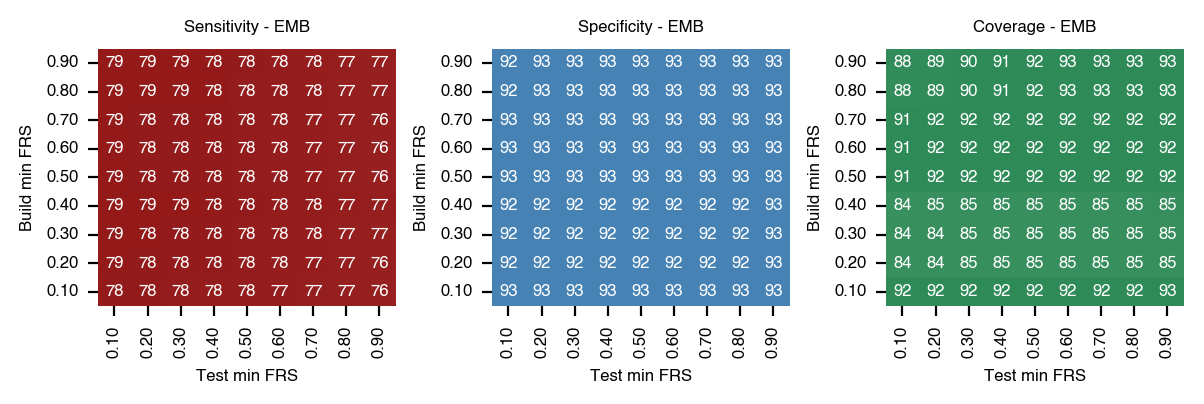

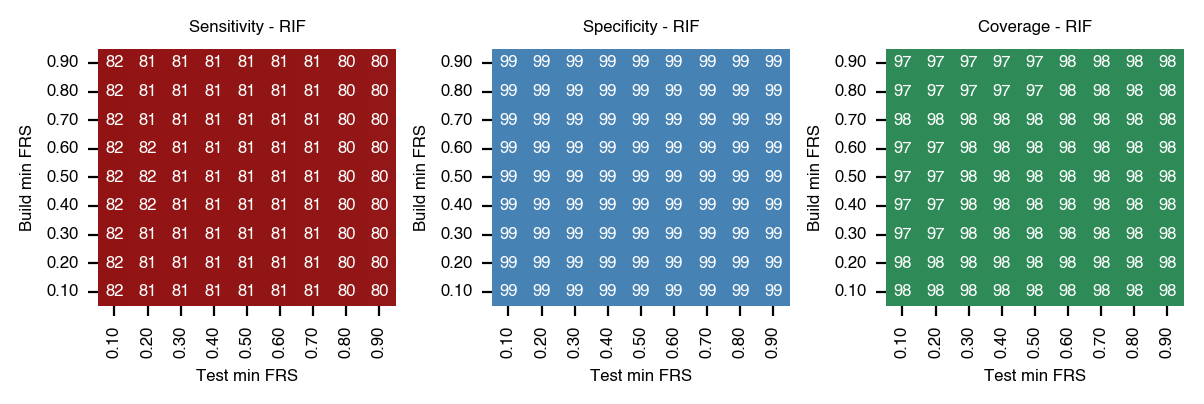

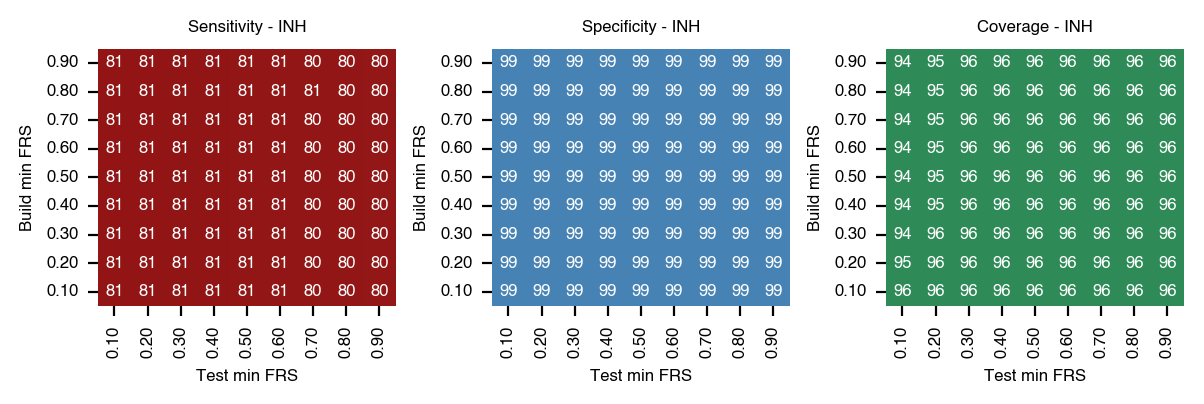

In [742]:
def convert_to_dataframe(matrix, metric):
    data = []
    
    for drug, builds in matrix.items():
        for build, tests in builds.items():
            for test, value in tests.items():
                data.append([drug, build, test, value])

    df = pd.DataFrame(data, columns=['Drug', 'Build_FRS', 'Test_FRS', metric])
    return df

sensitivity_df = convert_to_dataframe(sensitivity_matrix, 'Sensitivity')
specificity_df = convert_to_dataframe(specificity_matrix, 'Specificity')
coverage_df = convert_to_dataframe(coverage_matrix, 'Coverage')
perf_df = pd.merge(pd.merge(sensitivity_df, specificity_df, on=['Drug', 'Build_FRS', 'Test_FRS']), coverage_df, on=['Drug', 'Build_FRS', 'Test_FRS'])

utils.plot_perf_heatmaps(perf_df)

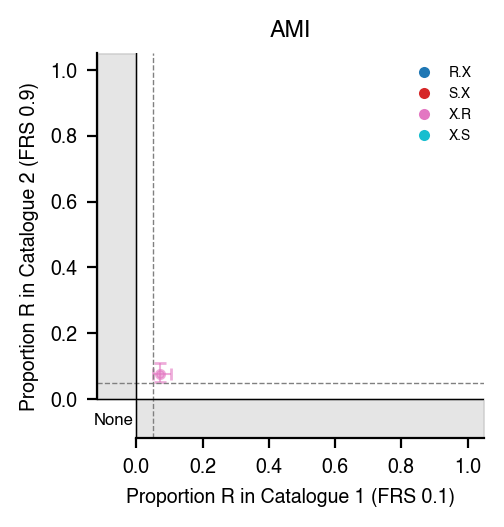

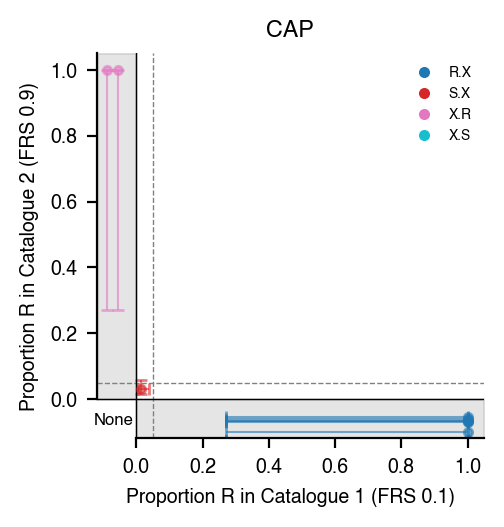

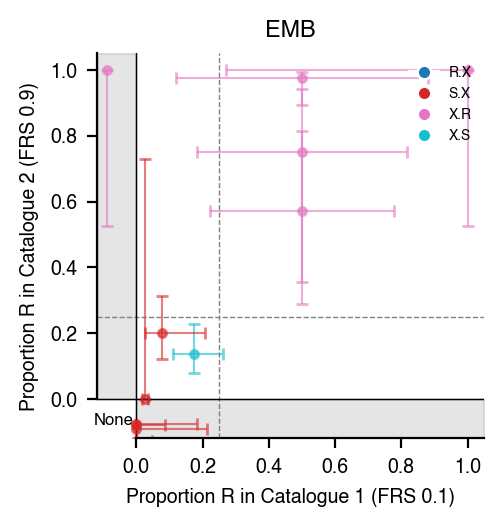

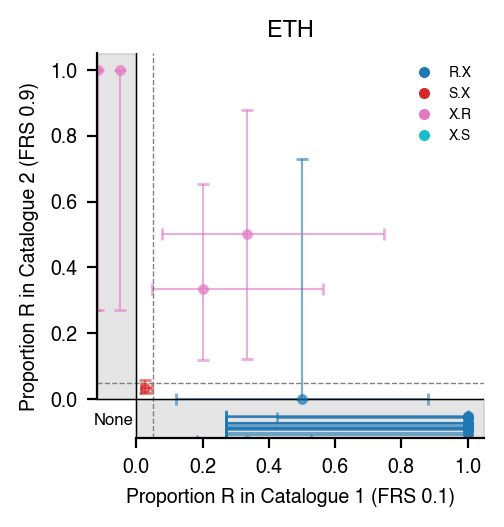

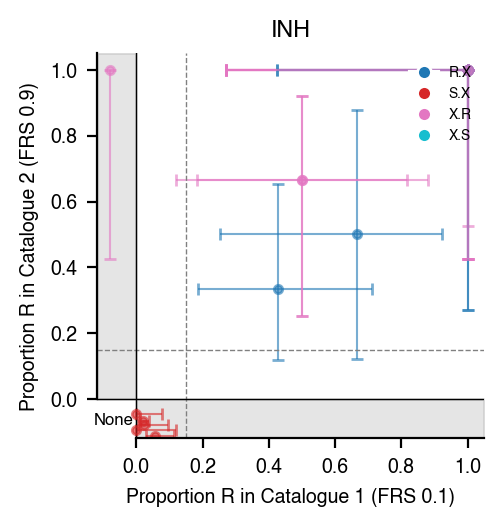

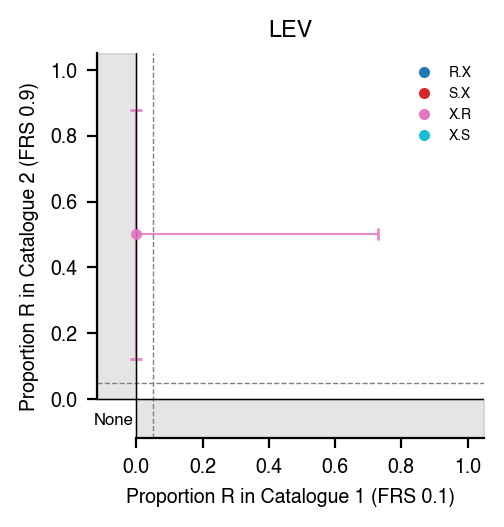

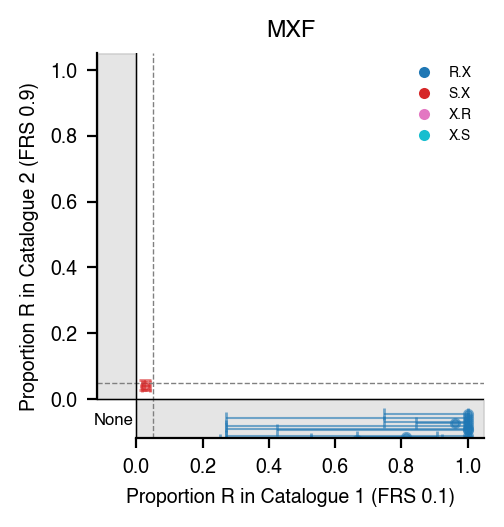

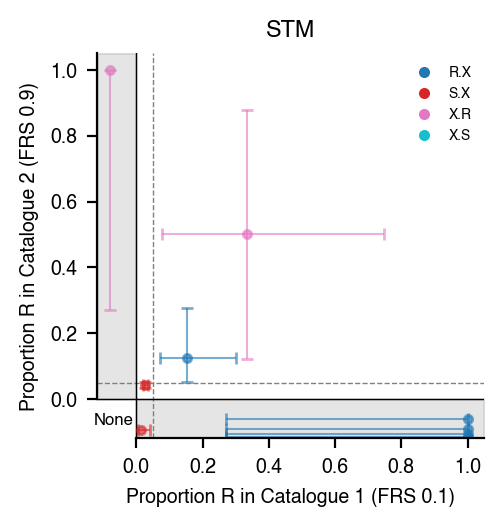

In [1239]:
perf_df_filt = perf_df[perf_df['Build_FRS'].isin([0.1, 0.9])]
twoD_prop_data, oneD_prop_data = {}, {}

for (drug, test_frs), group in perf_df_filt.groupby(['Drug', 'Test_FRS']):
    if len(group) == 2:
        if any(abs(group[col].max() - group[col].min()) > 1 for col in ['Sensitivity', 'Specificity', 'Coverage']):
            background, p = opt_cats_v1.loc[opt_cats_v1.DRUG == drug, ['BACKGROUND_RATE', 'p_value']].iloc[0]

            cat1, cat2 = utils.load_catomatic_catalogue(drug, background, p, 0.1), utils.load_catomatic_catalogue(drug, background, p, 0.9)

            df, merged_cats = utils.expand_and_classify_cats(cat1, cat2, drug)
            df = df[df.PREDICTION_PAIR.isin(['R.S', 'S.R', 'R.X', 'S.X', 'X.R', 'X.S'])].reset_index()

            #also pull out rows that only exist in 1 catalogue - these become the oneD data 
            df_1_prop = merged_cats[(pd.isna(merged_cats[['PROPORTION_cat1', 'PROPORTION_cat2', 'CONFIDENCE_cat1', 'CONFIDENCE_cat2']]).any(axis=1))&(merged_cats.PREDICTION_PAIR.isin(['R.X', 'S.X', 'X.R', 'X.S']))]

            def extract_errors(df, prop_col, conf_col):

                x, y = df[f'{prop_col}_cat1'], df[f'{prop_col}_cat2']
                # Ensure errors are lists, and apply capping
                def clean_ci(ci):
                    if isinstance(ci, list) and len(ci) == 2:
                        return [max(0, float(ci[0])), min(1, float(ci[1]))] 
                    return [np.nan, np.nan]

                x_err, y_err = df[f'{conf_col}_cat1'].apply(clean_ci), df[f'{conf_col}_cat2'].apply(clean_ci)

                if len(x) > 1:
                    return (np.array(x).flatten(), np.array(y).flatten(), np.vstack(x_err), np.vstack(y_err))
                elif len(x) == 1:
                    return (np.array(x).flatten(), np.array(y).flatten(), np.stack(x_err.values).T, np.stack(y_err.values).T)
                else:
                    return (np.array(x).flatten(), np.array(y).flatten(), x_err.to_numpy(), y_err.to_numpy())

            x, y, xerr, yerr = extract_errors(df, 'PROPORTION', 'CONFIDENCE')
            x_1_prop, y_1_prop, xerr_1_prop, yerr_1_prop = extract_errors(df_1_prop, 'PROPORTION', 'CONFIDENCE')
            
            twoD_prop_data[drug] = {'x': x, 'y': y, 'xerr': xerr, 'yerr': yerr, 'categories': df['PREDICTION_PAIR'].values, 'background': background, 'mutations':df['MUTATION'].values}
            oneD_prop_data[drug] = {'x': x_1_prop, 'y': y_1_prop, 'xerr': xerr_1_prop, 'yerr': yerr_1_prop, 'categories': df_1_prop['PREDICTION_PAIR'].values, 'background': background, 'mutations':df_1_prop['MUTATION'].values}

utils.plot_cat_comp_proportions(twoD_prop_data, oneD_prop_data) 

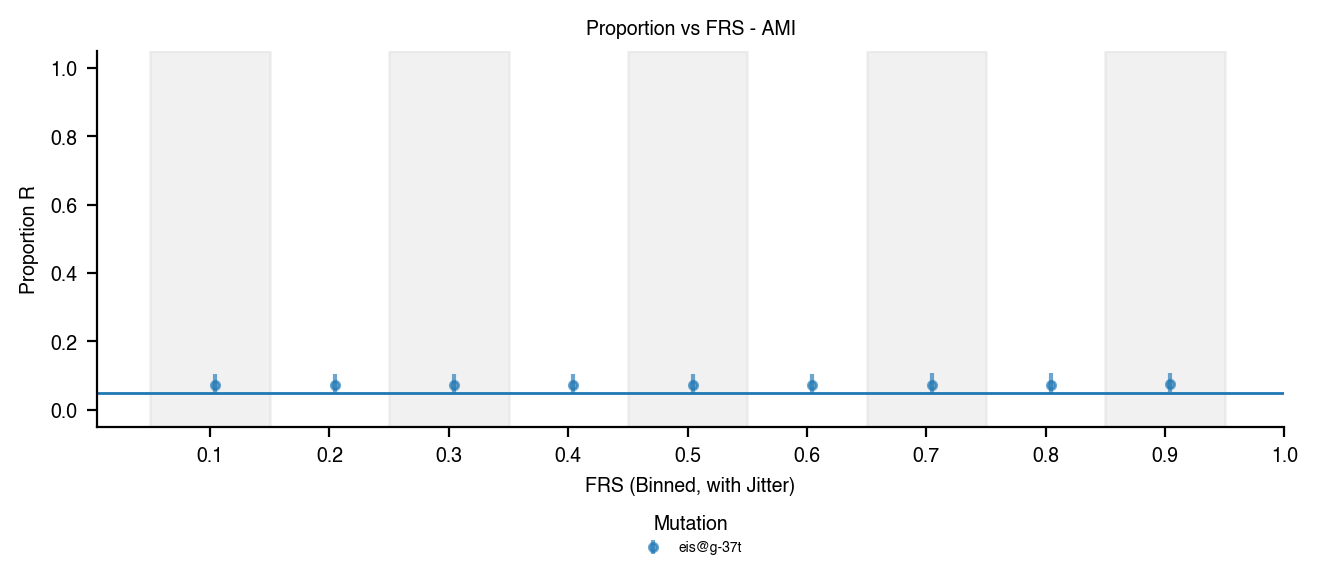

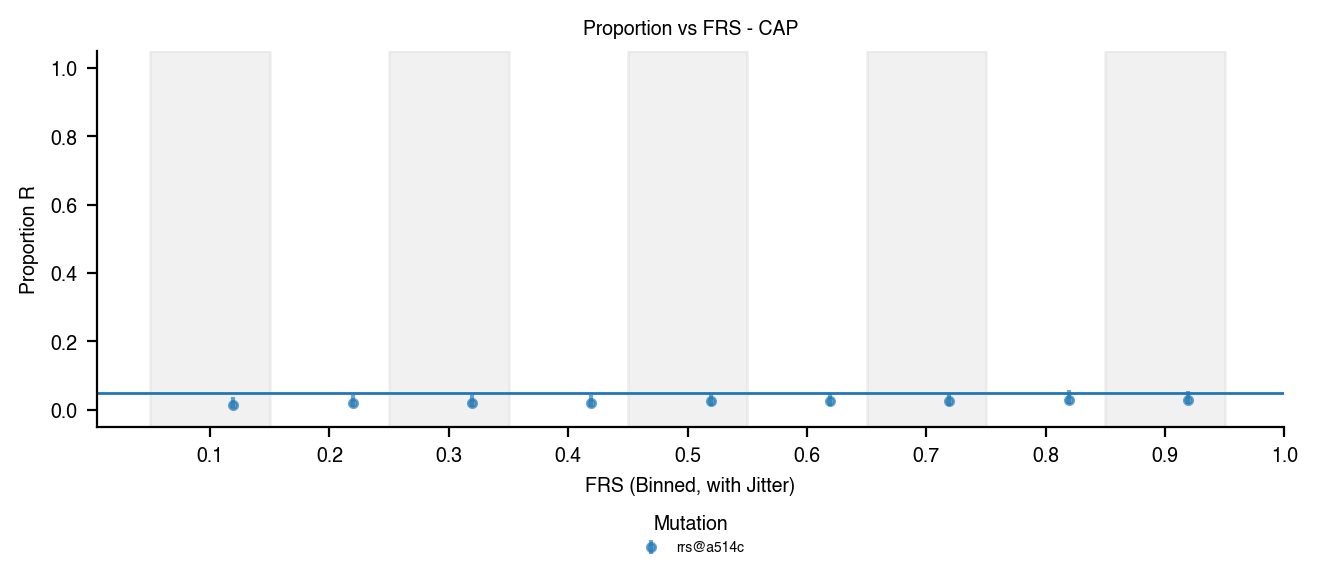

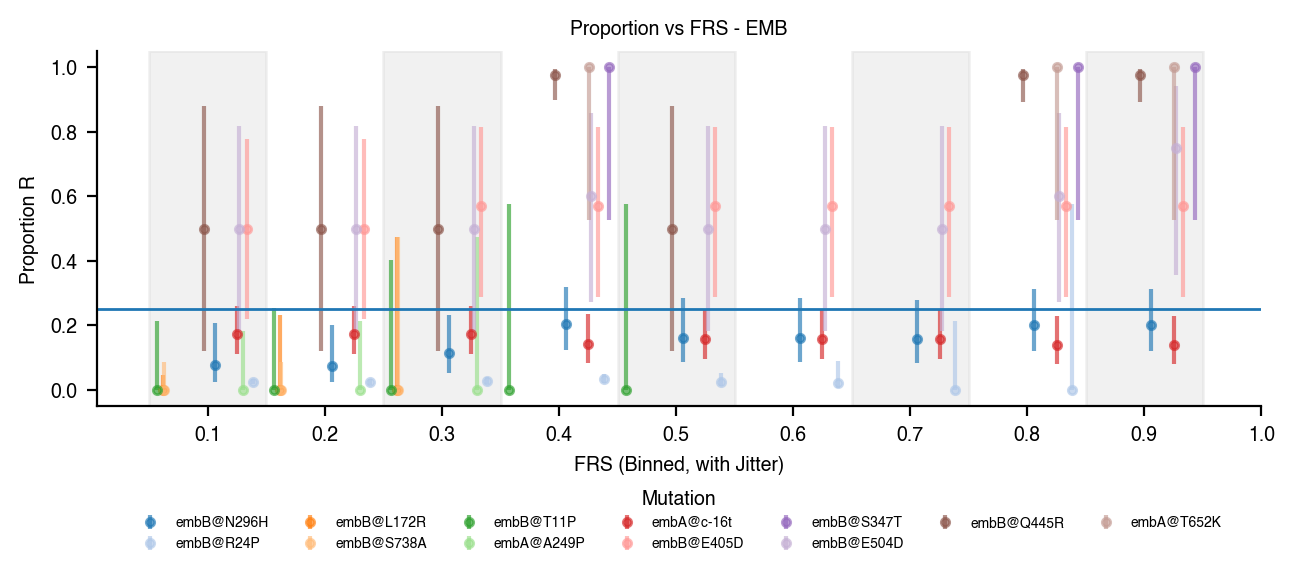

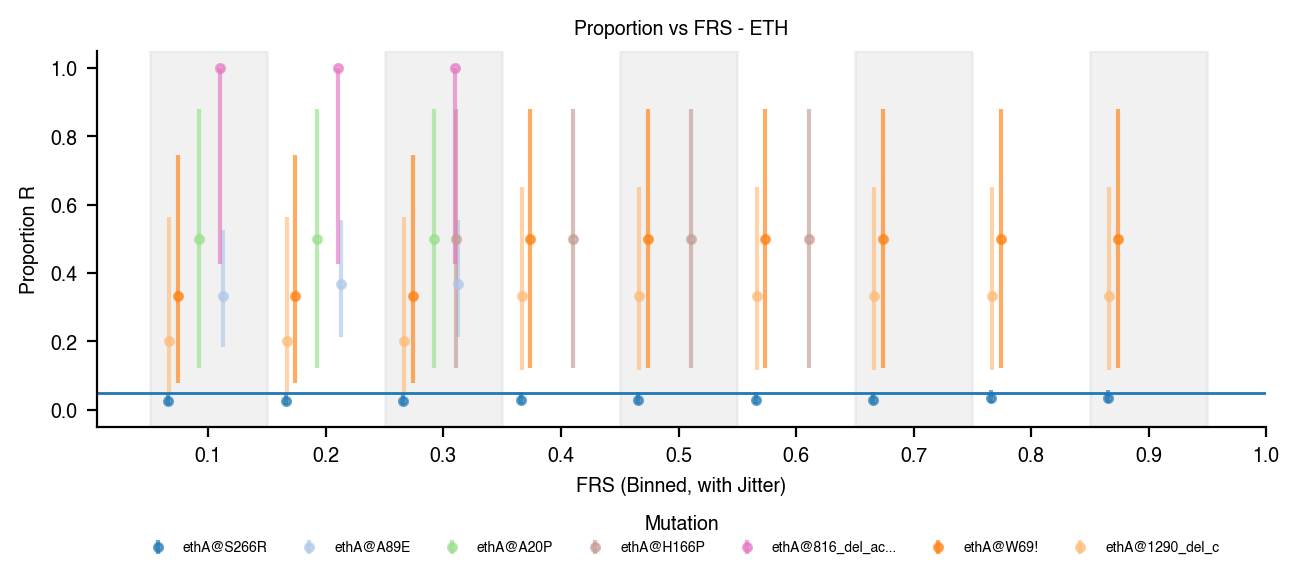

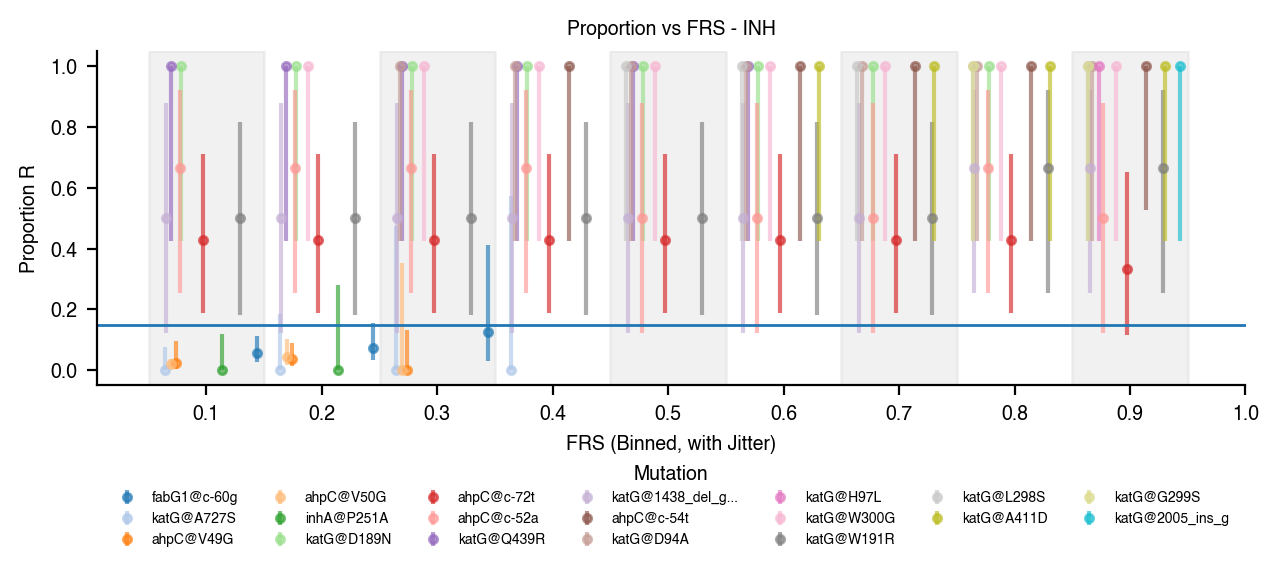

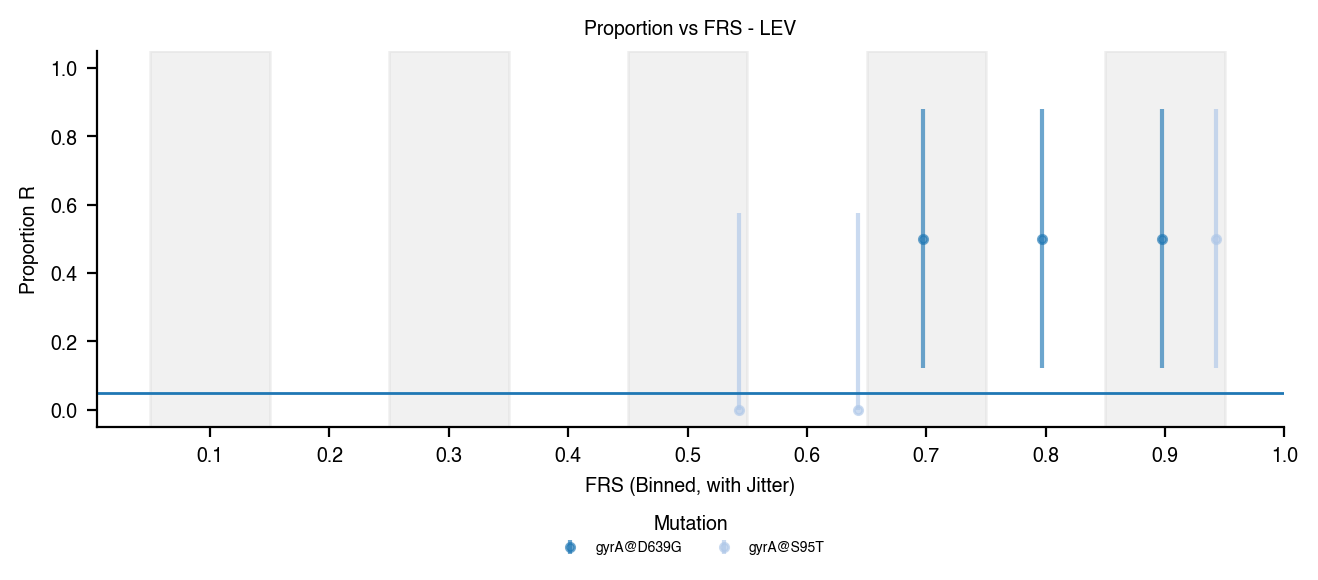

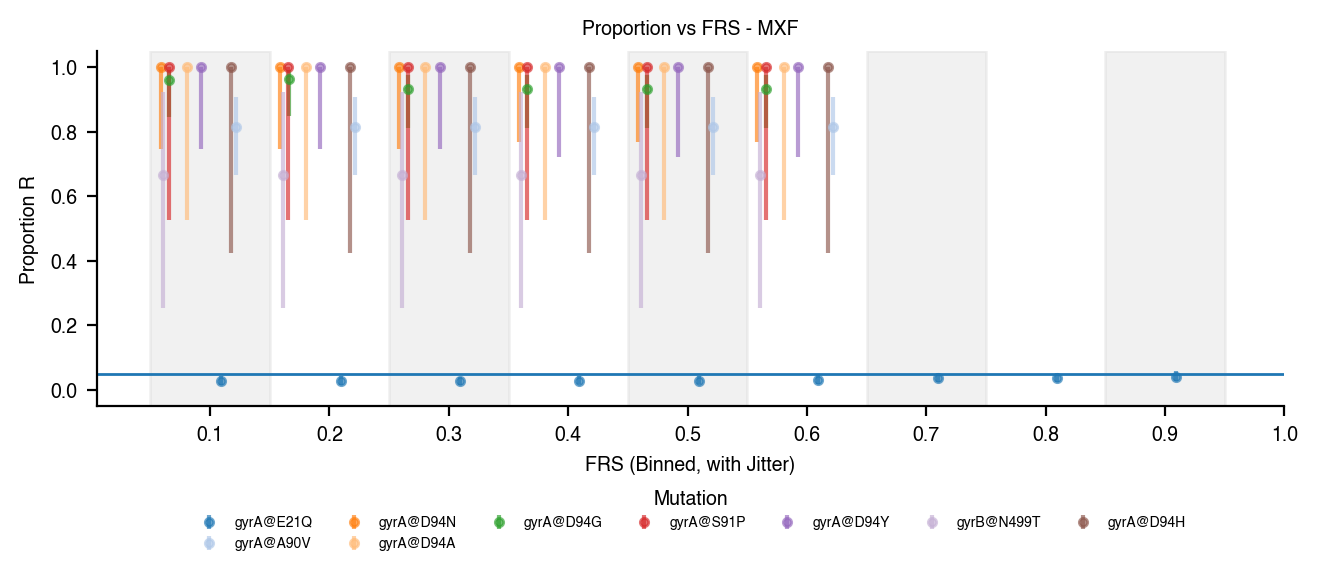

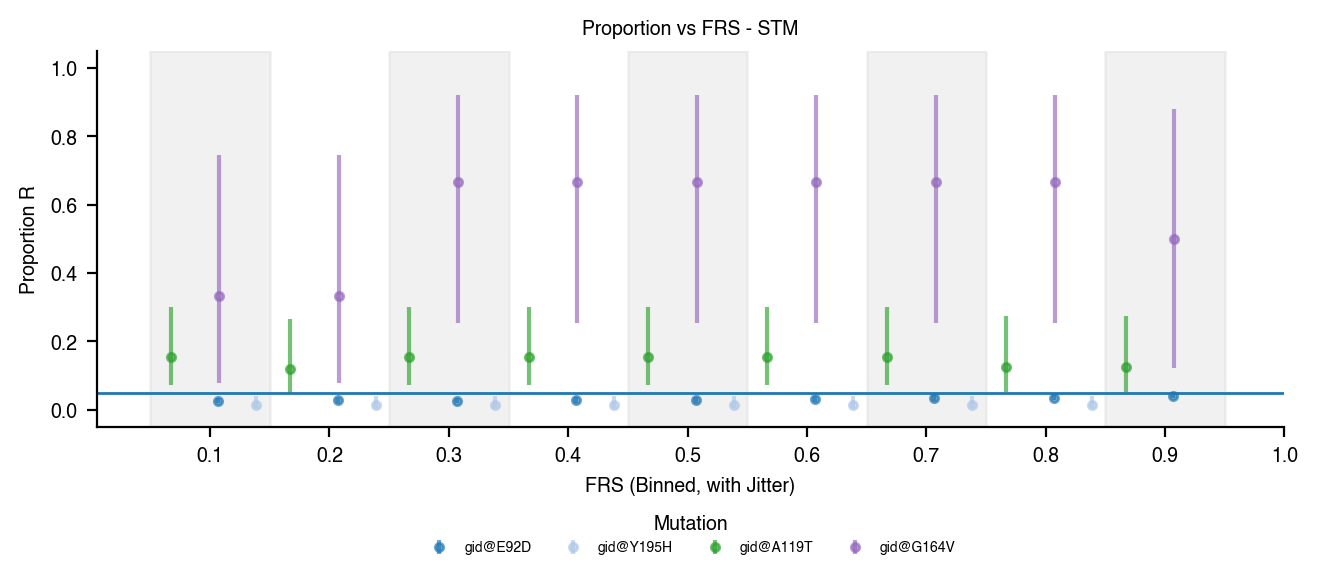

In [ ]:
frs_prop_data = defaultdict(lambda: defaultdict(lambda: {'frs': [], 'y': [], 'error': []}))

to_float = lambda x: float(x) if isinstance(x, np.float64) else x

for drug, v in twoD_prop_data.items():
    # Collect unique mutations
    muts = np.unique(np.concatenate([twoD_prop_data[drug]['mutations'], oneD_prop_data[drug]['mutations']]))
    background, p = opt_cats_v1.loc[opt_cats_v1.DRUG == drug, ['BACKGROUND_RATE', 'p_value']].iloc[0]

    for frs in build_frs_values:
        catalogue = utils.load_catomatic_catalogue(drug, background, p, frs)
        for field in ['PROPORTION', 'CONFIDENCE']:
            catalogue[field] = catalogue['EVIDENCE'].apply(lambda x: utils.extract_value(x, field.lower()))

        catalogue_muts = catalogue[catalogue.MUTATION.isin(muts)]

        def extract_errors(df, prop_col, conf_col):
            def clean_ci(ci):
                if isinstance(ci, list) and len(ci) == 2:
                    return [max(0, float(ci[0])), min(1, float(ci[1]))] 
                return [np.nan, np.nan]
            prop = df[prop_col]
            err = df[conf_col].apply(clean_ci)

            if len(prop) > 1:
                return (np.array(prop).flatten(), np.vstack(err))
            elif len(prop) == 1:
                return (np.array(prop).flatten(), np.stack(err.values).T)
            else:
                return (np.array(prop).flatten(), err.to_numpy())

        prop, error = extract_errors(catalogue_muts, 'PROPORTION', 'CONFIDENCE')

        for i, mutation in enumerate(catalogue_muts.MUTATION.tolist()):
            frs_prop_data[drug][mutation]['frs'].append(to_float(frs))
            frs_prop_data[drug][mutation]['y'].append(prop[i])
            frs_prop_data[drug][mutation]['error'].append(error[i] if prop.shape[0] > 1 else error)
            frs_prop_data[drug][mutation]['background'] = background

frs_prop_data = {drug: dict(mutations) for drug, mutations in frs_prop_data.items()}

color_map = {}
for drug, mutations_dict in frs_prop_data.items():
    unique_mutations = list(mutations_dict.keys())
    color_map[drug] = dict(zip(unique_mutations, sns.color_palette("tab20", len(unique_mutations))))

utils.plot_mutation_error_bars(frs_prop_data, color_map=color_map, min_err=0.7)


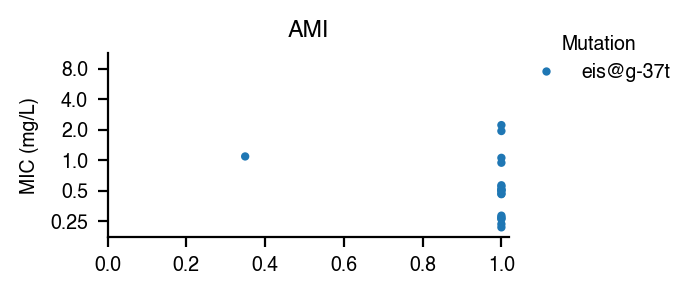

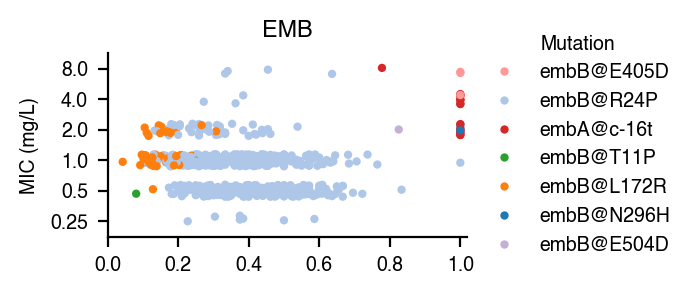

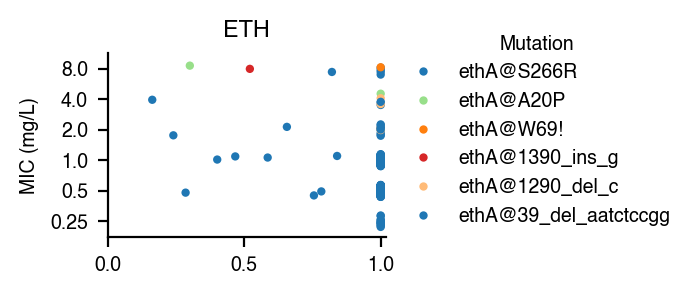

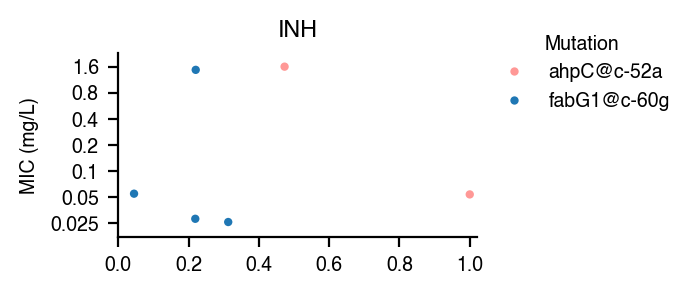

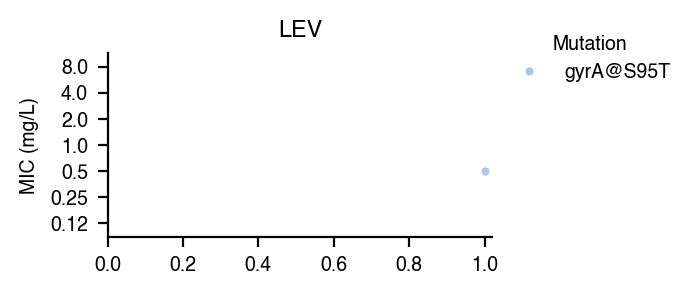

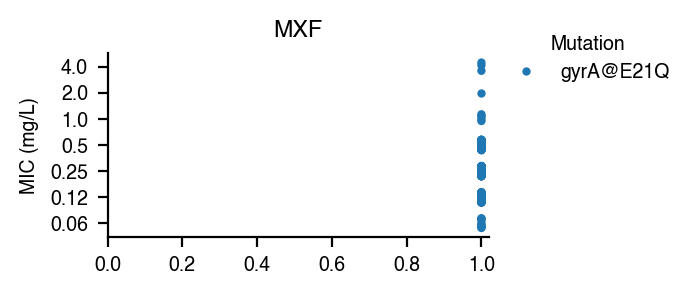

In [ ]:
df_mic = {}
for drug, v in twoD_prop_data.items():
    mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=True)
    test_mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=False)
    phenotypes = prep_phenotypes(
        drug,
        "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl.",
        "data/cryptic-tables-v1/GENOMES.pkl.gz",
        "data/cryptic-tables-v1/SAMPLES.csv.gz",
        'v1'
    )

    all = pd.merge(phenotypes, mutations, on=['UNIQUEID'], how='left')
    all = all[all.METHOD_3.isin(['UKMYC5', 'UKMYC6'])]
    if len(all)>0:
        all["MIC_FLOAT"] = utils.cap_mic_to_float(all)

        muts = np.unique(np.concatenate([twoD_prop_data[drug]['mutations'], oneD_prop_data[drug]['mutations']])) # Convert to set for faster lookups
        # Group by 'UNIQUEID' and filter groups where the size is 1
        solos = all.groupby('UNIQUEID').filter(lambda x: len(x) == 1).UNIQUEID.unique()
        filtered = all[(all.UNIQUEID.isin(solos)) & (all.MUTATION.isin(muts))]
        df_mic[drug] = pd.DataFrame({
            "UNIQUEID": filtered.UNIQUEID.tolist(),
            "MUTATION": filtered.MUTATION.tolist(),
            "FRS": filtered.FRS.tolist(),
            "METHOD": filtered.METHOD_3.tolist(),
            "MIC": filtered.MIC_FLOAT.tolist(),
        })

        df_mic[drug]["binned_FRS"] = [str(round(i, 1)) for i in df_mic[drug].FRS.tolist()]
        df_mic[drug]["binned_MIC"] = [str(i) for i in df_mic[drug].MIC]
        df_mic[drug]["MIC"] = [str(i) for i in df_mic[drug].MIC] 

utils.plot_frs_vs_mic



- AMI: lose sensitivity at low FRS, owing to de-classification of high frequency, boderline variant eis@g-37t. However, the proportion is rather low, and its using a very low background - 211 vs 17 feels very S, what happens if we increase the background to capture this variant as S? (ie check perf of grid search at higher background). Not many UKMYC solos with MICs.

- CAP: increae cov at low FRS, owing to to classification of high frequency, borderline variant rrs@a514c. Similar to AMI, proportion and background is low - check spec and cov of grid search at higher background. No MIC data

- EMB: 4 variants are de-classified at low FRS due to lower proportion and wider confidence. One variant is classified R at high FRS. There are a couple susceptible variants classified at low FRS with tight confidence, like embB@L172R and emB@S378A. embB@R24P is interesting as at low FRS it is a high freq S variant, but is supported less and less as FRS increases until only 1 is seen at FRS 0.9 - only really exists at lower FRS. embB@N296H is classified S at low FRS, but its proportion gradually increases as FRS goes up until its U. The opposite happens to embA@c-16t whereby proportion decreases and it is classified S at high FRS.

- ETH: Coverage increases at low FRS due to the S classification of a bunch of low freq variant + high freq borderline ethA@S266R is also reclassified S at low FRS - same q as above, what if we use slight higher background? A few low-freq variants are reclassified R at low FRS. 2 low freq mutations are reclassified R at high FRS.

- INH: Coverage increases due to the classification of a bunch of fairly high freq S mutations at low FRS - these don't seem to exist at higher FRS (notably. katG@A727S, fabG1@c-60g, ahpC@V49G and ahpc@V60G). We also see the re-classification of a couple failry low-freq variants to/from R as FRS is increased. We also a handful of variants be classified R at high FRS.

- LEV: Specificity jumps big and holds constant at 0.9 to 0.8, while cocerage drops. Due to low frequency gryA@D639G and gyryA@s95T, which do not exist at low FRS. S95T is causal for the per jump, as it disappears at 0.8, while D630G exists through the jump.

- MXF: Major performance boost from 0.7 to 0.6, doe the reclassification of boderline high frequency S variant gryA@E21Q (again check grid search), which have bumped coverage, and the classification of a bunch of low and medium freq variants that only exist at low FRS - higher freq ones are gryA@D94G, gryA@A90V, and gryA@D94Y. Stark difference. No lower FRS MIC values for plates...

- STM: 10% coverage boost when FRS is lowered due to classification of high frequency boerline S variant gid@E92D. High frequency S borderline gid@Y195H doesnt appear at FRS 0.9, but does below 0.9. Medium-freq gid@A119T proportion increases lower than FRS 0.9 and is classified R. Low freq gid@G164V is relcassified U at low FRS. Cov boost due to E92D and Y195H. No MIC data from plates.



# Performance Benchmarking

Because the WHO catalogues have been parsed into a piezo format, we can easily run predictions from them on our training set (or any tarining set) and compare performance with catomatic's catalogues.

However, the WHO use a binary prediction system, whereby samples containing U mutations are assumed to be S (ie those mutations are removed). However, we can ignore this and use a ternary system to compare to ours (which will also be more informative as it will tell us how many WHO predictions are actual look-ups, and how many are assumptions).

##### Catalogues to compare:

- whov1
- whov2
- catomatic_v1 (built on same dataset as whov1)
- catomatic_v3

##### Test sets (may not need to compare all catalogues at same time. )
- crypticv1 (training set for whov1 and catomativ1 - allows only head-to-head training comp)
- cryptic v3 (training set for catomatic_v3)
- validation set (for now just use crypticv3 training set as placeholder)



### catomatic_v1 vs WHOv1 on CRyPTICv1

Can use piezo to calculate WHOv1 performance on cryptic-v1 

In [ ]:
FRS = 0.1
whov1_results = {}
for drug, genes in drug_genes.items():
    who_catalogue = 'catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS.csv'
    if drug in pd.read_csv(who_catalogue)['DRUG'].unique():
        mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=False)
        phenotypes = prep_phenotypes(drug, "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl.", "data/cryptic-tables-v1/GENOMES.pkl.gz", "data/cryptic-tables-v1/SAMPLES.pkl.gz", 'v1')        
        # Test the performance of the WHO on the training + synonymous set for this drug
        all = pd.merge(phenotypes, mutations[mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
        cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all, drug=drug, catalogue_file=who_catalogue, U_to_S=False, Print=False)
        
        # Save results into grid_results
        whov1_results[drug] = {'catalogue': 'WHOv1', "SENSITIVITY": sens, "SPECIFICITY": spec, "COVERAGE": cov}

whov1_results = pd.DataFrame(whov1_results).T.reset_index().rename(columns={'index':'DRUG'})

/Users/dylanadlard/miniforge3/envs/cryptic-catalogues-25/lib/python3.13/site-packages/seaborn/categorical.py:383: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(n - .5, -.5, auto=None)


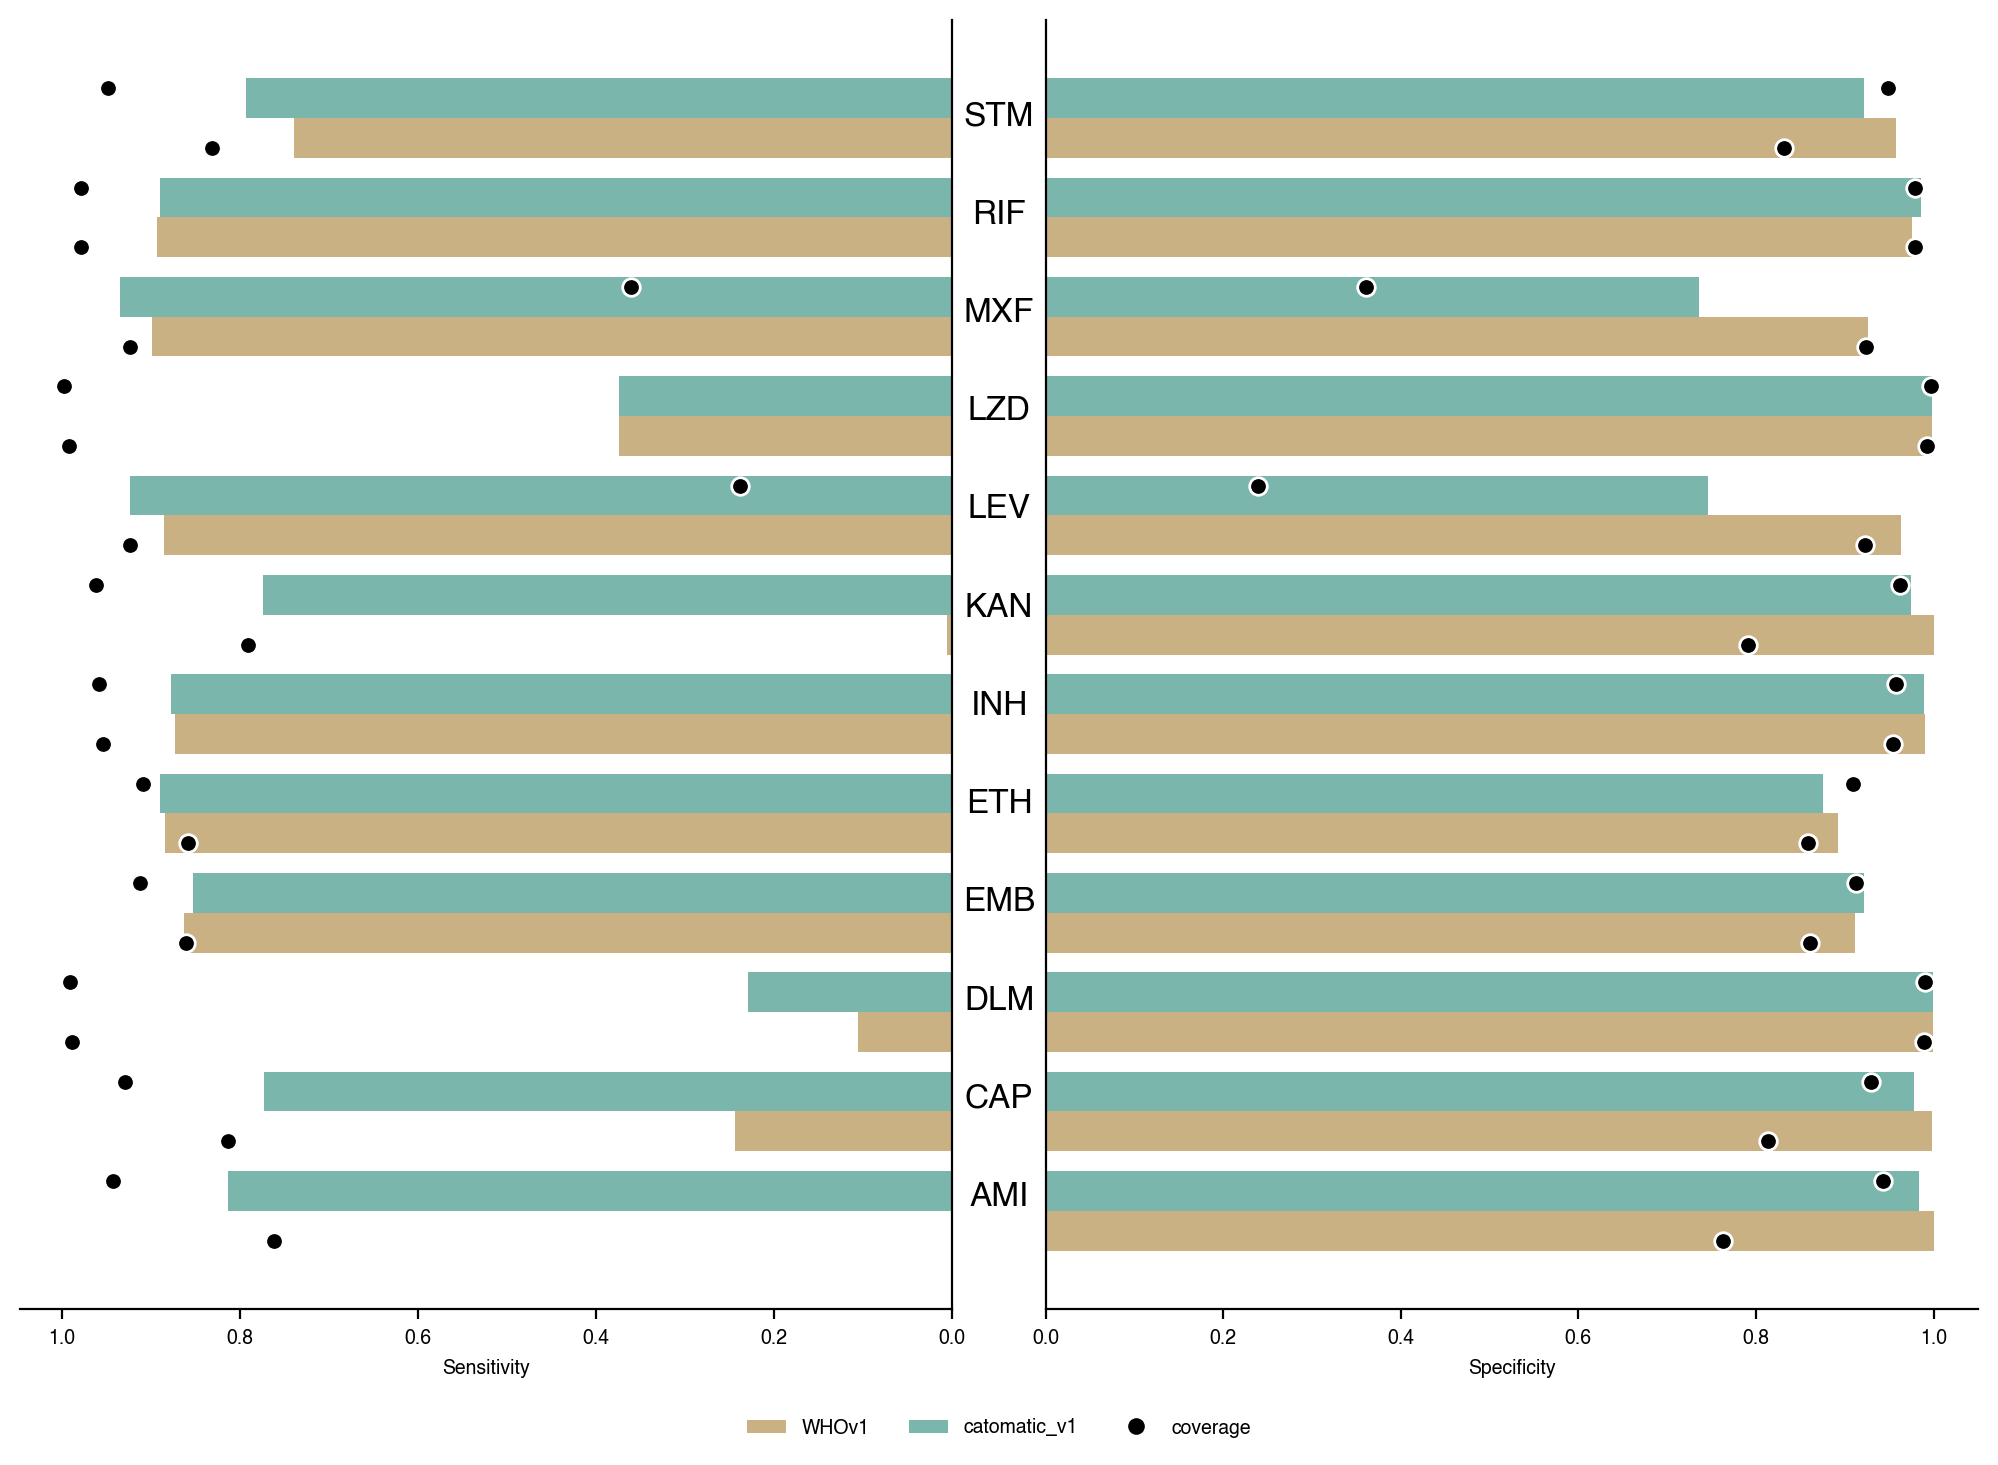

In [224]:
comp_train_perf_v1 = pd.concat([whov1_results, opt_cats_v1[opt_cats_v1.DRUG.isin(pd.read_csv(who_catalogue)['DRUG'].unique())][['DRUG', 'catalogue', 'SENSITIVITY', 'SPECIFICITY', 'COVERAGE']]], ignore_index=True).sort_values(by=['DRUG', 'catalogue'])
catalogue_palette = {
    "catomatic_v1": "#70c0b3",  # Slightly darker than #80cdc1 but lighter than #66b3aa
    "catomatic_v3": "#018571",  # Unchanged
    "WHOv1": "#d5b477",         # Slightly darker than #dfc27d but lighter than #c4a96c
    "WHOv2": "#a6611a",         # Unchanged
}

utils.back2back_sens_spec(comp_train_perf_v1, palette=catalogue_palette)

### Discordance analysis between WHOv1 and catomatic_v1

The complications of direclty comparing catalogue contents are:
- Both contains default rules
- Both contain expert rules (such as lof rules)

If we want an effective comparison, we have to take into account rules. The only way to do this fairly, is to expand all rules into the individual mutations that exist in the other catalogue and fall under that rule - this will give the number of variants effectively classified by each rule.

We can use piezo to do this, as it inherently understands the rules.

N.B some catalogues may contain a rule and specifici mutaitons that fall under that rule - just be aware in analysis we will get duplicates, but with different sources/evidence.

#### Catomatic-v1 vs WHOv1

This is the most fair, like-for-like comparison of the methods, as the training sets for these catalogues are the same

In [215]:
#Prep data for comparisons:
who = pd.read_csv('catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS.csv')
who['EVIDENCE'] = who['EVIDENCE'].apply(utils.str_to_dict)
who['GENBANK_REFERENCE'] = 'NC00962.3'
who['CATALOGUE_VERSION'] = 0
who['CATALOGUE_NAME'] = '-'
#filter out default rules
who = who[~who['EVIDENCE'].apply(lambda x: isinstance(x, dict) and 'reporting_rule' in x)]
#keep only R and S classifications
u_who = who[~who.PREDICTION.isin(['R','S'])]
who = who[who.PREDICTION.isin(['R','S'])]

#prep catomatic catalogues
valid_drugs = opt_cats_v1[opt_cats_v1.DRUG.isin(who.DRUG.unique())]
cats = valid_drugs.apply(
    lambda row: pd.read_csv(f"./catalogues/cryptic-v1/grid_search/{row['DRUG'].lower()}/bg_{row['BACKGROUND_RATE']}_p_{row['p_value']}_FRS_0.1.csv"),
    axis=1
).tolist()
cat = pd.concat(cats)
cat['CATALOGUE_VERSION'] = 0
cat['CATALOGUE_NAME'] = '-'
cat['EVIDENCE'] = cat['EVIDENCE'].apply(utils.str_to_dict)
#filter out default rules
cat = cat[~cat['EVIDENCE'].apply(lambda x: isinstance(x, dict) and 'default_rule' in x)]
#keep only R and S classifications
u_cat = cat[~cat.PREDICTION.isin(['R','S'])]
cat = cat[cat.PREDICTION.isin(['R','S'])]


valid_drugs = cat[cat.DRUG.isin(who.DRUG.unique())].DRUG.unique()

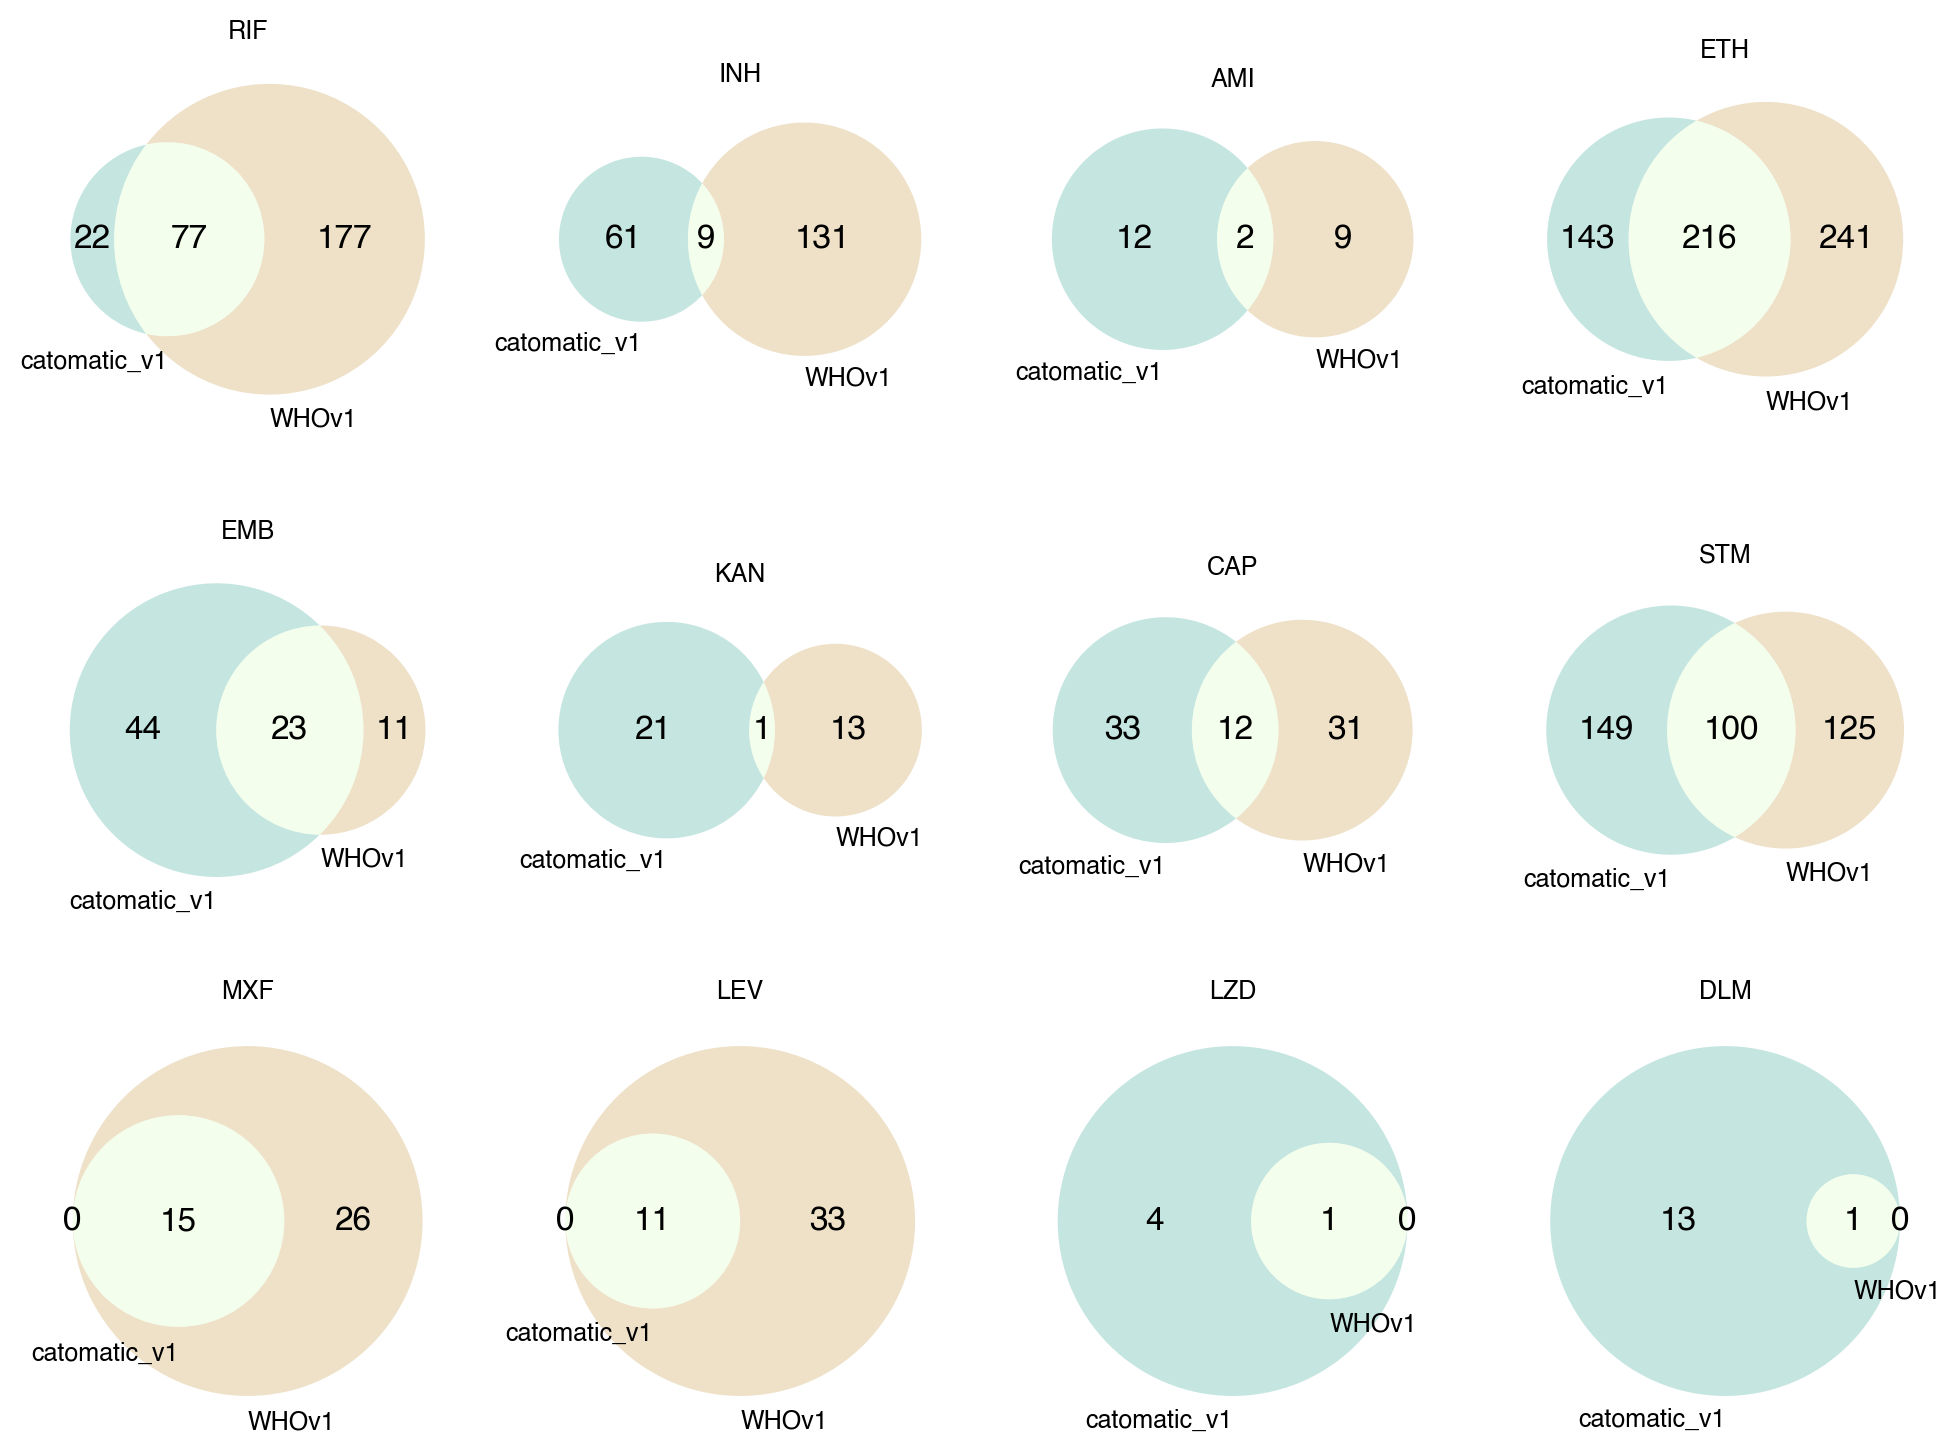

In [219]:
expanded_catalogues = utils.expand_catalogue_pair(cat, who, valid_drugs, 'RUS', ('cat', 'who'))

n_cols = 4
n_rows = -(-len(valid_drugs) // n_cols)  # Calculate rows based on number of drugs

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
axes = axes.flatten()

idx=0
for drug, v in expanded_catalogues.items():    
    merged = v['merged']
    shared_variants = len(merged[(~merged.PREDICTION_who.isna()) & (~merged.PREDICTION_cat.isna())])
    who_only_variants = len(merged[(~merged.PREDICTION_who.isna()) & (merged.PREDICTION_cat.isna())])
    catomatic_only_variants = len(merged[(merged.PREDICTION_who.isna()) & (~merged.PREDICTION_cat.isna())])
    
    ax = axes[idx]
    venn_diagram = venn2(
        subsets=(catomatic_only_variants, who_only_variants, shared_variants),
        set_labels=('catomatic_v1', 'WHOv1'),
        ax=ax,
        set_colors=(catalogue_palette["catomatic_v1"], catalogue_palette["WHOv1"])  
    )
    ax.set_title(f"{drug}", fontsize=9)

    idx+=1

    for label in venn_diagram.set_labels:
        if label:
            label.set_fontsize(9)  # Adjust font size for set labels

    for label in venn_diagram.subset_labels:
        if label:
            label.set_fontsize(12)  # Adjust font size for numbers inside the circles


for ax in axes[len(valid_drugs):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

Can plot the number of solo counts observed for each variant shared across catalogues (not including rules, as the number of counrs in a rule can't be expanded to represent the counts of indvidual mutaitons that fall under that rule (ie the number of points will be less than the shared counts above, which include the rules) - this is automatically handled as the evidence columns for variants expanded from rules dont contain counts).

Could perhaps also plot proportion of resistance?

In [198]:
#pull out R and S counts

for drug, v in expanded_catalogues.items():
    v['merged']['solo_R_who'] = v['merged']['EVIDENCE_who'].apply(lambda x: utils.extract_value(x, 'Present_SOLO_R'))
    v['merged']['solo_S_who'] = v['merged']['EVIDENCE_who'].apply(lambda x: utils.extract_value(x, 'Present_S'))
    v['merged']['solo_R_cat'] = v['merged']['EVIDENCE_cat'].apply(lambda x: utils.extract_value(x, 'contingency', 0, 0))
    v['merged']['solo_S_cat'] = v['merged']['EVIDENCE_cat'].apply(lambda x: utils.extract_value(x, 'contingency', 0, 1))

all_drugs_merged = pd.concat(expanded_catalogues[drug]['merged'] for drug in valid_drugs)
suffixes = ('cat', 'who')
all_drugs_merged['PREDICTION_PAIR'] = all_drugs_merged.apply(utils.classify_predictions, axis=1, args=(suffixes,))
all_drugs_merged['DRUG'] = all_drugs_merged['DRUG_who'].combine_first(all_drugs_merged['DRUG_cat'])

shared = utils.sum_solo_counts(all_drugs_merged[~all_drugs_merged.PREDICTION_PAIR.str.contains('X')])
not_shared = utils.sum_solo_counts(all_drugs_merged[(all_drugs_merged.PREDICTION_PAIR.str.contains('X'))]).reset_index()

u_who['solo_R'] = u_who['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'Present_SOLO_R'))
u_who['solo_S'] = u_who['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'Present_S'))
u_cat['solo_R'] = u_cat['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'contingency', 0, 0))
u_cat['solo_S'] = u_cat['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'contingency', 0, 1))

#fill up the not_shared df with solo counts (as these had been discounted above if in the u df)
for i in range(len(not_shared)):
    drug = not_shared.DRUG.iloc[i]
    mutation = not_shared.MUTATION.iloc[i]
    if pd.isna(not_shared.y.iloc[i]):
        if mutation in u_who[u_who.DRUG==drug].MUTATION.tolist():            
            not_shared.loc[i, 'solo_R_who'] = u_who[(u_who.DRUG==drug)&(u_who.MUTATION==mutation)].solo_R.values[0]
            not_shared.loc[i, 'solo_S_who'] = u_who[(u_who.DRUG==drug)&(u_who.MUTATION==mutation)].solo_S.values[0]
    if pd.isna(not_shared.x.iloc[i]):
        if mutation in u_cat[u_cat.DRUG==drug].MUTATION.tolist():
            not_shared.loc[i, 'solo_R_cat'] = u_cat[(u_cat.DRUG==drug)&(u_cat.MUTATION==mutation)].solo_R.values[0]
            not_shared.loc[i, 'solo_S_cat'] = u_cat[(u_cat.DRUG==drug)&(u_cat.MUTATION==mutation)].solo_S.values[0]
#re-add up x and y columns
not_shared = utils.sum_solo_counts(not_shared)


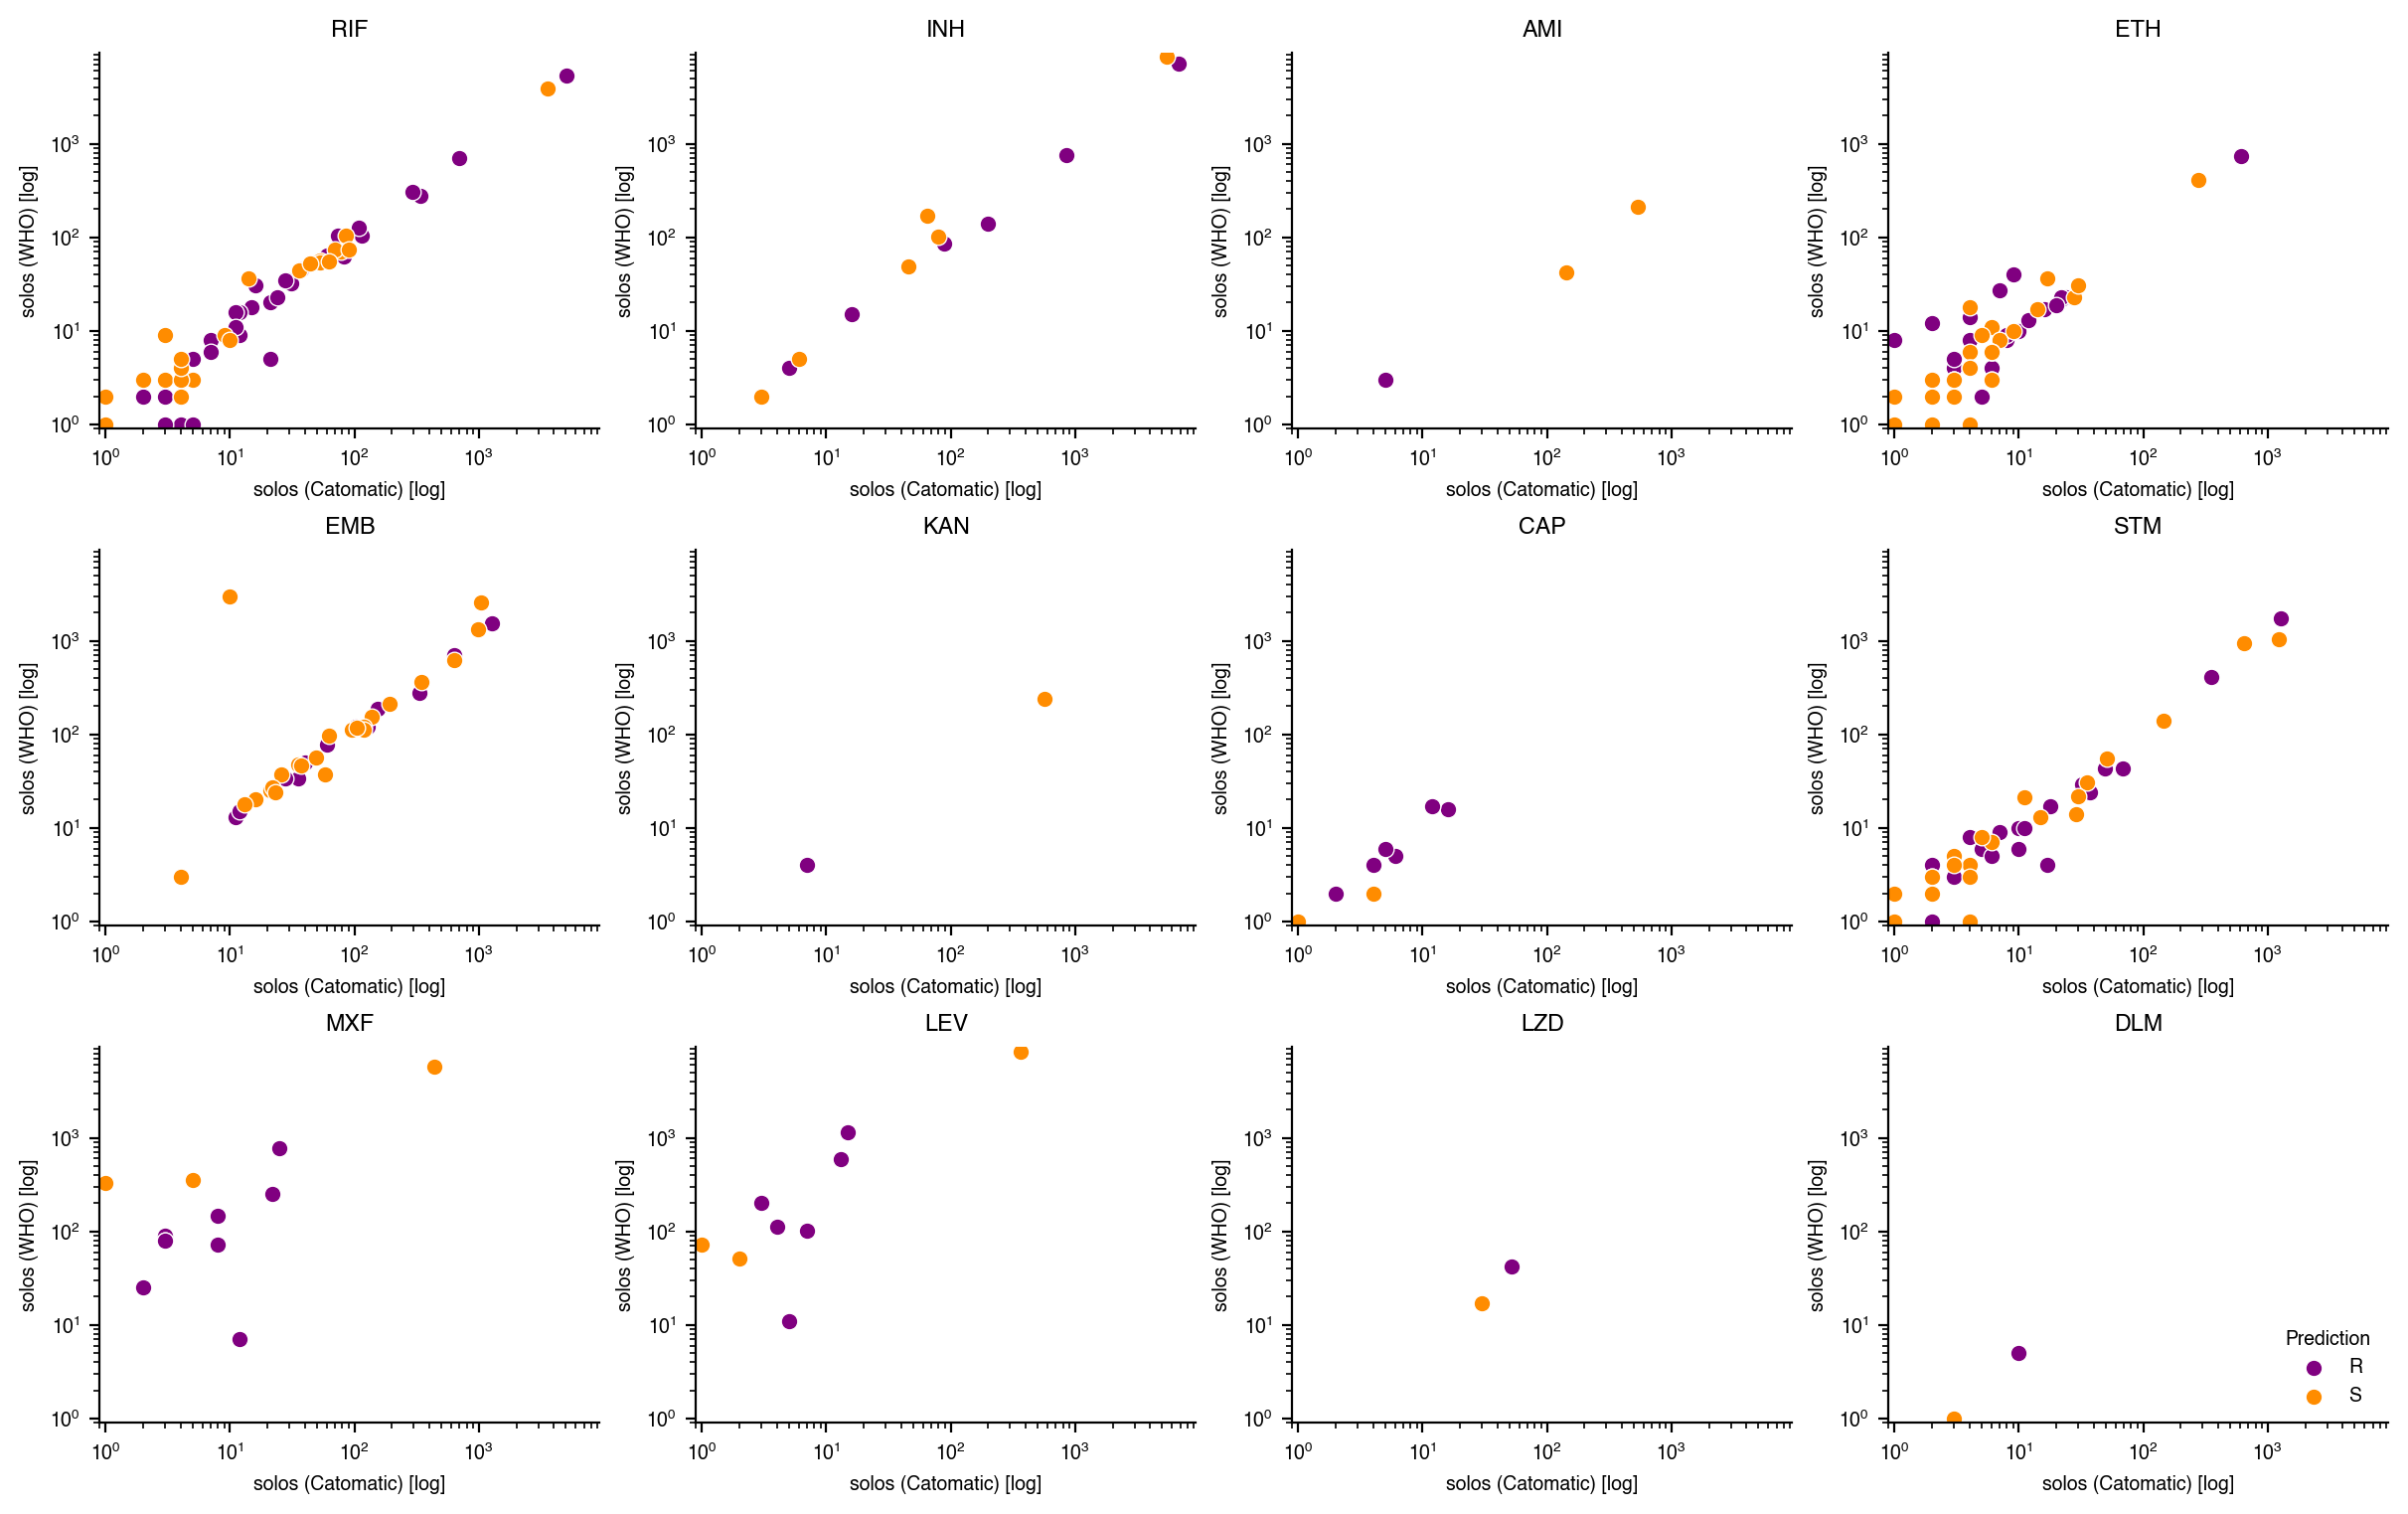

In [199]:
n_cols = 4  
n_rows = math.ceil(len(valid_drugs) / n_cols)  # Calculate rows needed

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.5 * n_rows), constrained_layout=True)
axes = axes.flatten()

all_values = []
for v in expanded_catalogues.values():
    shared = v['merged'][(~v['merged'].PREDICTION_who.isna()) & (~v['merged'].PREDICTION_cat.isna())]
    all_values.extend(shared[['solo_R_cat', 'solo_R_who', 'solo_S_cat', 'solo_S_who']].values.flatten())

all_values = np.array(all_values)
all_values = all_values[all_values > 0]

if all_values.size > 0:
    global_min = np.nanmin(all_values) * 0.9  # Add buffer
    global_max = np.nanmax(all_values) * 1.1  # Add buffer
    global_min = max(global_min, 1e-5)  
    # If min and max are the same, set a small range
    if global_min == global_max:
        global_min /= 1.5
        global_max *= 1.5
else:
    global_min, global_max = 1e-5, 10  # Default range if no valid data

idx = 0
for drug, v in expanded_catalogues.items():
    shared = v['merged'][(~v['merged'].PREDICTION_who.isna()) & (~v['merged'].PREDICTION_cat.isna())]

    ax = axes[idx]
    sns.scatterplot(data=shared, x='solo_R_cat', y='solo_R_who', ax=ax, color='purple', label='R')
    sns.scatterplot(data=shared, x='solo_S_cat', y='solo_S_who', ax=ax, color='darkorange', label='S')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(global_min, global_max)
    ax.set_title(f"{drug}")
    ax.set_xlabel("solos (Catomatic) [log]")
    ax.set_ylabel("solos (WHO) [log]")
    sns.despine(ax=ax)

    if idx == len(valid_drugs) - 1:
        ax.legend(title="Prediction", frameon=False, loc='lower right')
    else:
        ax.legend().remove()
    idx += 1
    
for j in range(idx, len(axes)):
    axes[j].axis('off')

plt.show()


In [202]:
all_drugs_merged = pd.concat(expanded_catalogues[drug]['merged'] for drug in valid_drugs)

all_drugs_merged['PREDICTION_PAIR'] = all_drugs_merged.apply(utils.classify_predictions, axis=1, args=(suffixes,))

all_drugs_merged['DRUG'] = all_drugs_merged['DRUG_who'].combine_first(all_drugs_merged['DRUG_cat'])


The below is a finer grain summary of what each catalogue contains, taking into account expert rules as above. The sum of these should match the venn diagrams above.

In [203]:
#all_drugs_merged can contain duplicate mutations if catalogue contians both a row and rule that mutation falls under (ie if duplicate in the original catalogue)
#want to keep these in for diagnosis, but must be careful to filter our for counts and figures

summary_table = (
    all_drugs_merged.drop_duplicates(['MUTATION']).groupby(['DRUG', 'PREDICTION_PAIR'])
    .size()
    .unstack(fill_value=0)  # Pivot table to create columns for prediction pairs
    .reset_index()  # Resets the index, moving 'PREDICTION_PAIR' into a column
)

summary_table.rename(columns={'DRUG': 'DRUG'}, inplace=True)
summary_table['total'] = summary_table.drop(columns=['DRUG']).sum(axis=1)
summary_table.columns.name = None

summary_table

DRUG  R.R  R.X  S.R  S.S  S.X  X.R  X.S  total
0   AMI    0    4    0    2    8    4    5     23
1   CAP   12   28    0    0    0   23    1     64
2   DLM    1   13    0    0    0    0    0     14
3   EMB   12    5    0   11   39    3    8     78
4   ETH  140  140    0    0    1  234    0    515
5   INH    6   44    0    2   17  122    9    200
6   KAN    0    1    0    0    8    3    1     13
7   LEV    0    0    0    0    0    0    3      3
8   LZD    1    0    0    0    4    0    0      5
9   MXF    7    0    0    1    0    7   12     27
10  RIF   35    9    2    7   13  173    3    242
11  STM   63  143    0    3    0  119    2    330

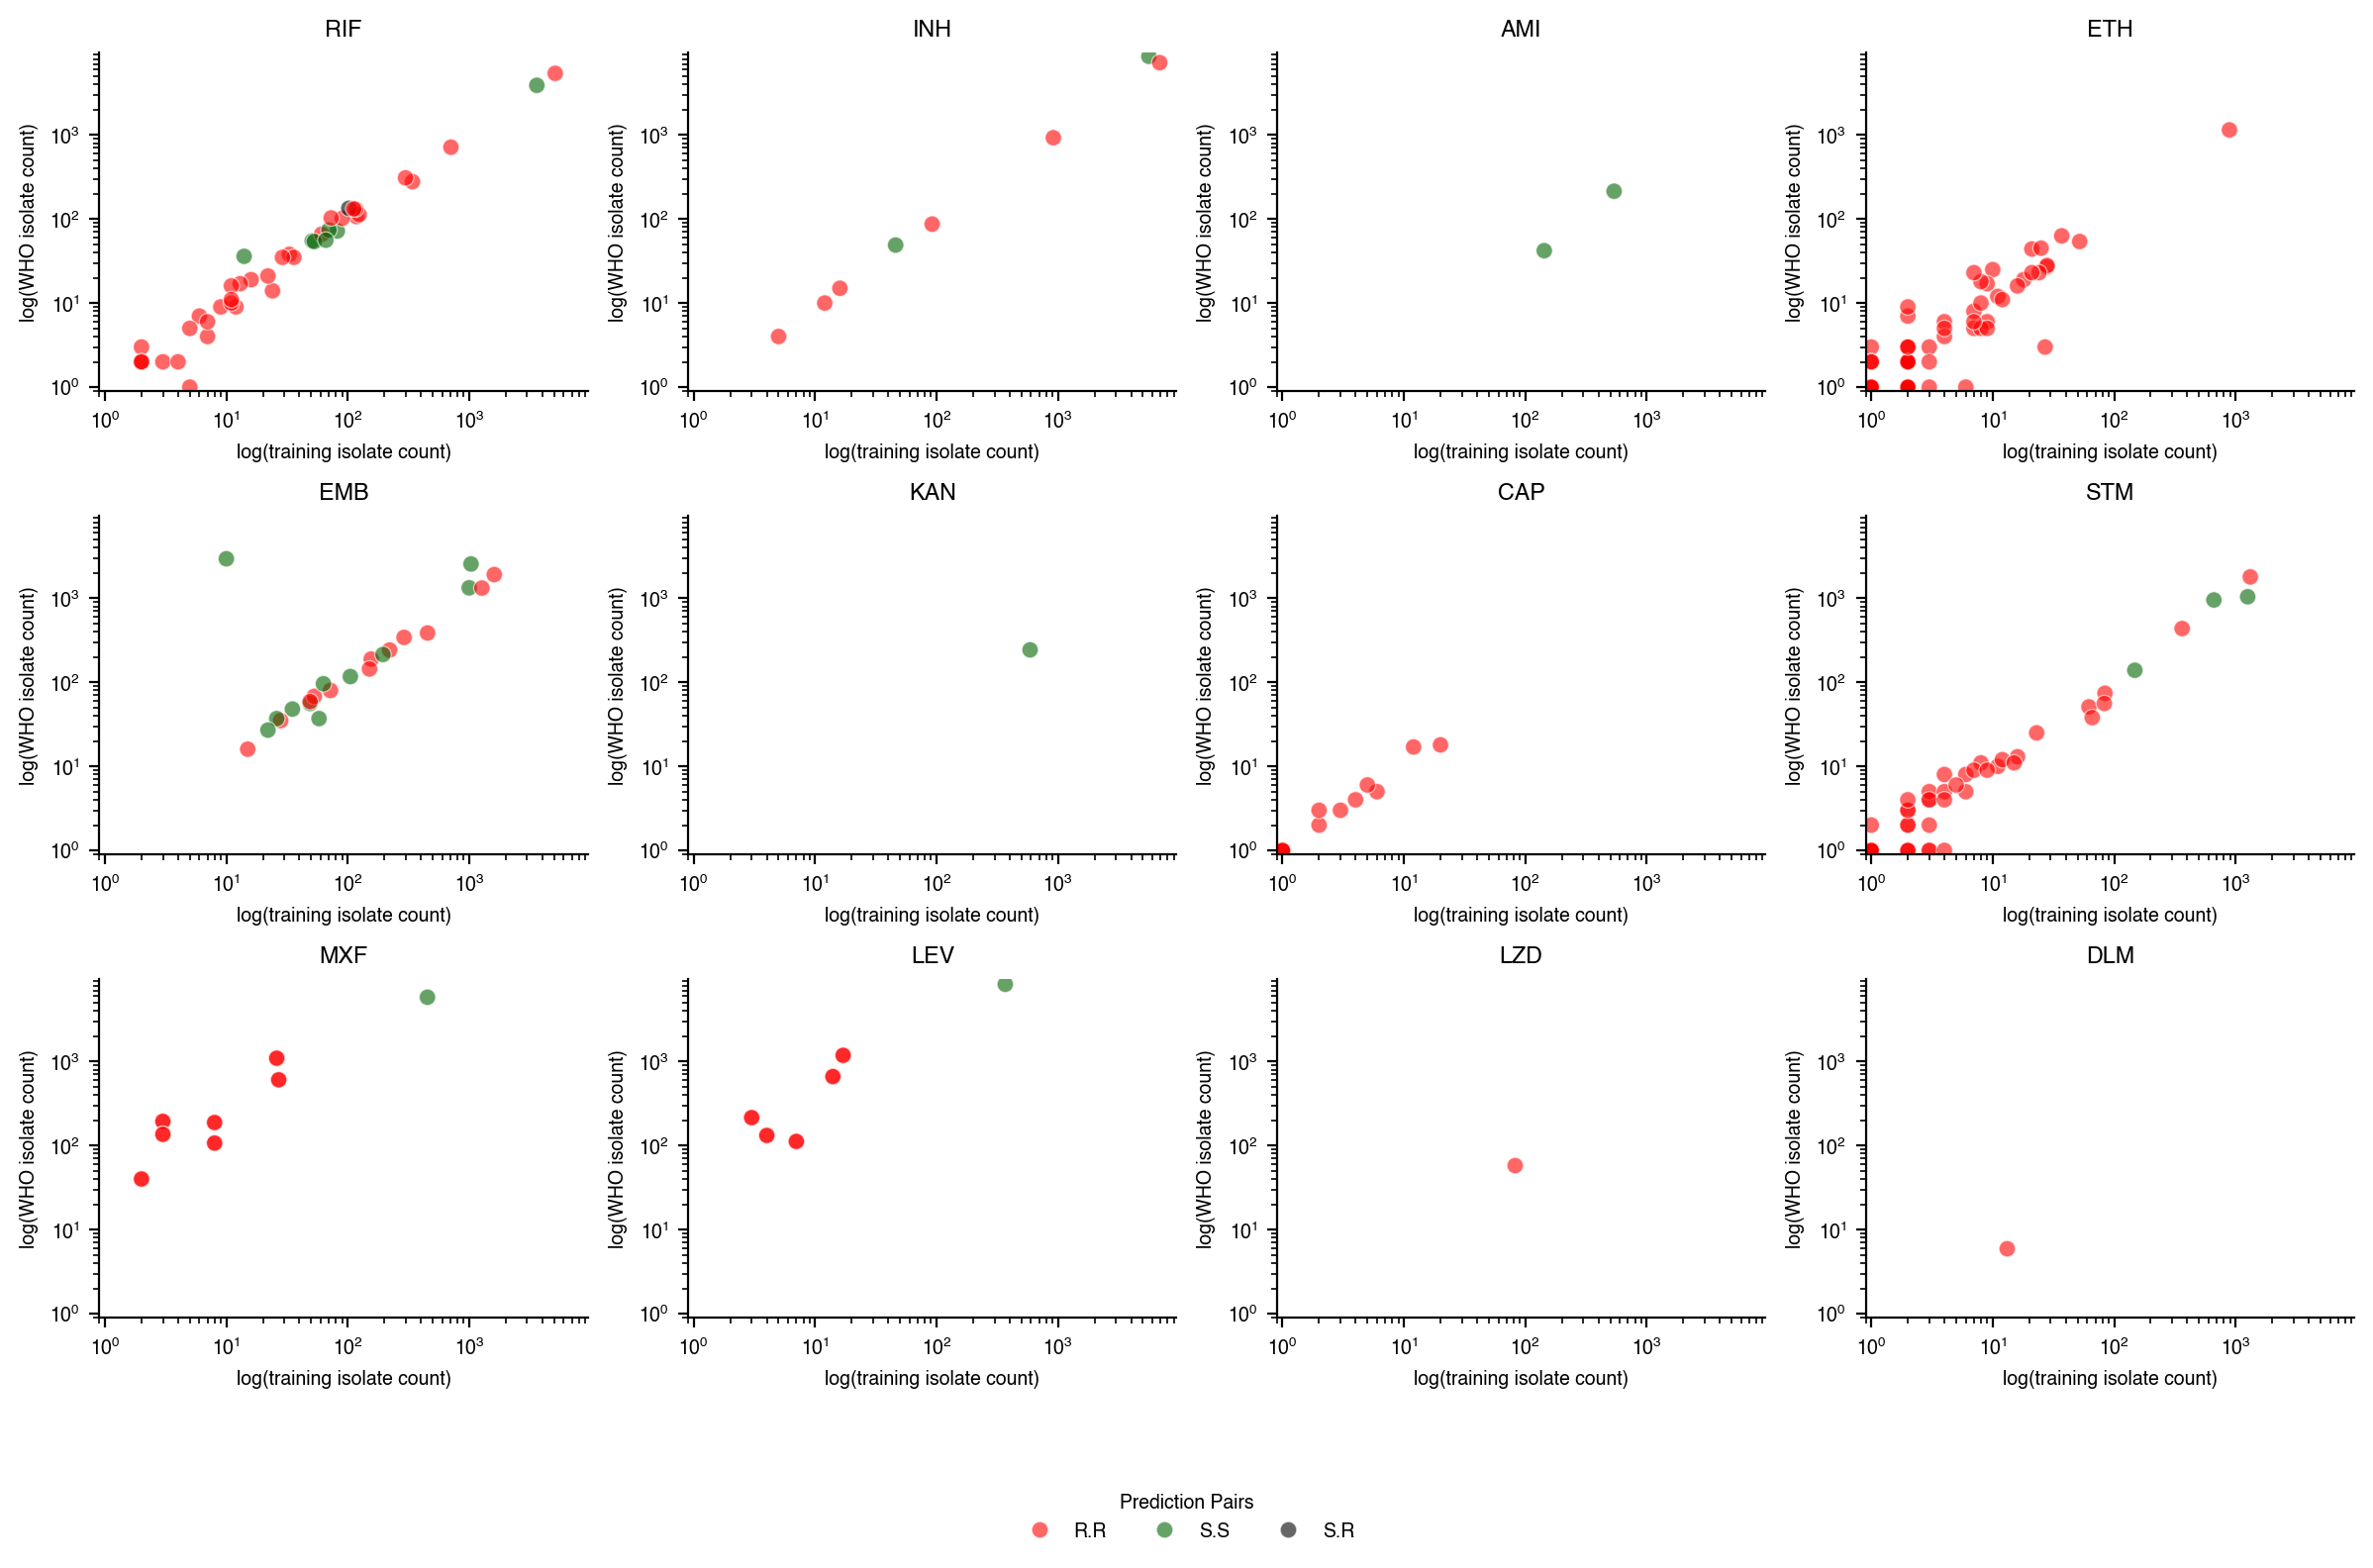

In [204]:

# Define prediction colors
prediction_colors = {
    "R.R": "red", "S.S": "darkgreen", "R.S": "grey", "S.R": "black",
    "X.S": "black", "X.R": "darkorange",
    "S.X": "lightblue", "R.X": "purple",
}

# Filter data and plot
shared = utils.sum_solo_counts(all_drugs_merged[~all_drugs_merged.PREDICTION_PAIR.str.contains('X')])

utils.plot_grid_counts(shared[(shared.EVIDENCE_who != {'expanded_rule'}) & (shared.EVIDENCE_cat != {'expanded_rule'})], valid_drugs, prediction_colors)


Of all the mutations in both catalogues, the only ones classified differently are 2 Rif variants where we have predicted S but WHO R:

In [205]:
shared[(shared.PREDICTION_PAIR=='S.R')]

Unnamed: 0_cat GENBANK_REFERENCE_cat CATALOGUE_NAME_cat  \
182             9.0             NC00962.3                  -   
183             9.0             NC00962.3                  -   
184             9.0             NC00962.3                  -   
188             5.0             NC00962.3                  -   

     CATALOGUE_VERSION_cat CATALOGUE_GRAMMAR_cat PREDICTION_VALUES_cat  \
182                    0.0                 GARC1                   RUS   
183                    0.0                 GARC1                   RUS   
184                    0.0                 GARC1                   RUS   
188                    0.0                 GARC1                   RUS   

    DRUG_cat    MUTATION PREDICTION_cat SOURCE_cat  ...  \
182      RIF  rpoB@L430P              S         {}  ...   
183      RIF  rpoB@L430P              S         {}  ...   
184      RIF  rpoB@L430P              S         {}  ...   
188      RIF  rpoB@L449Q              S         {}  ...   

                                        OTHER_who Unnamed: 0_who solo_R_who  \
182  {"FINAL_CONFIDENCE_GRADING": "1) Assoc w R"}            NaN       31.0   
183                                            {}            NaN        NaN   
184                                            {}            NaN        NaN   
188                                            {}            NaN        NaN   

    solo_S_who  solo_R_cat solo_S_cat PREDICTION_PAIR DRUG      x      y  
182      103.0        16.0       86.0             S.R  RIF  102.0  134.0  
183        NaN        16.0       86.0             S.R  RIF  102.0    NaN  
184        NaN        16.0       86.0             S.R  RIF  102.0    NaN  
188        NaN         0.0       43.0             S.R  RIF   43.0    NaN  

[4 rows x 31 columns]

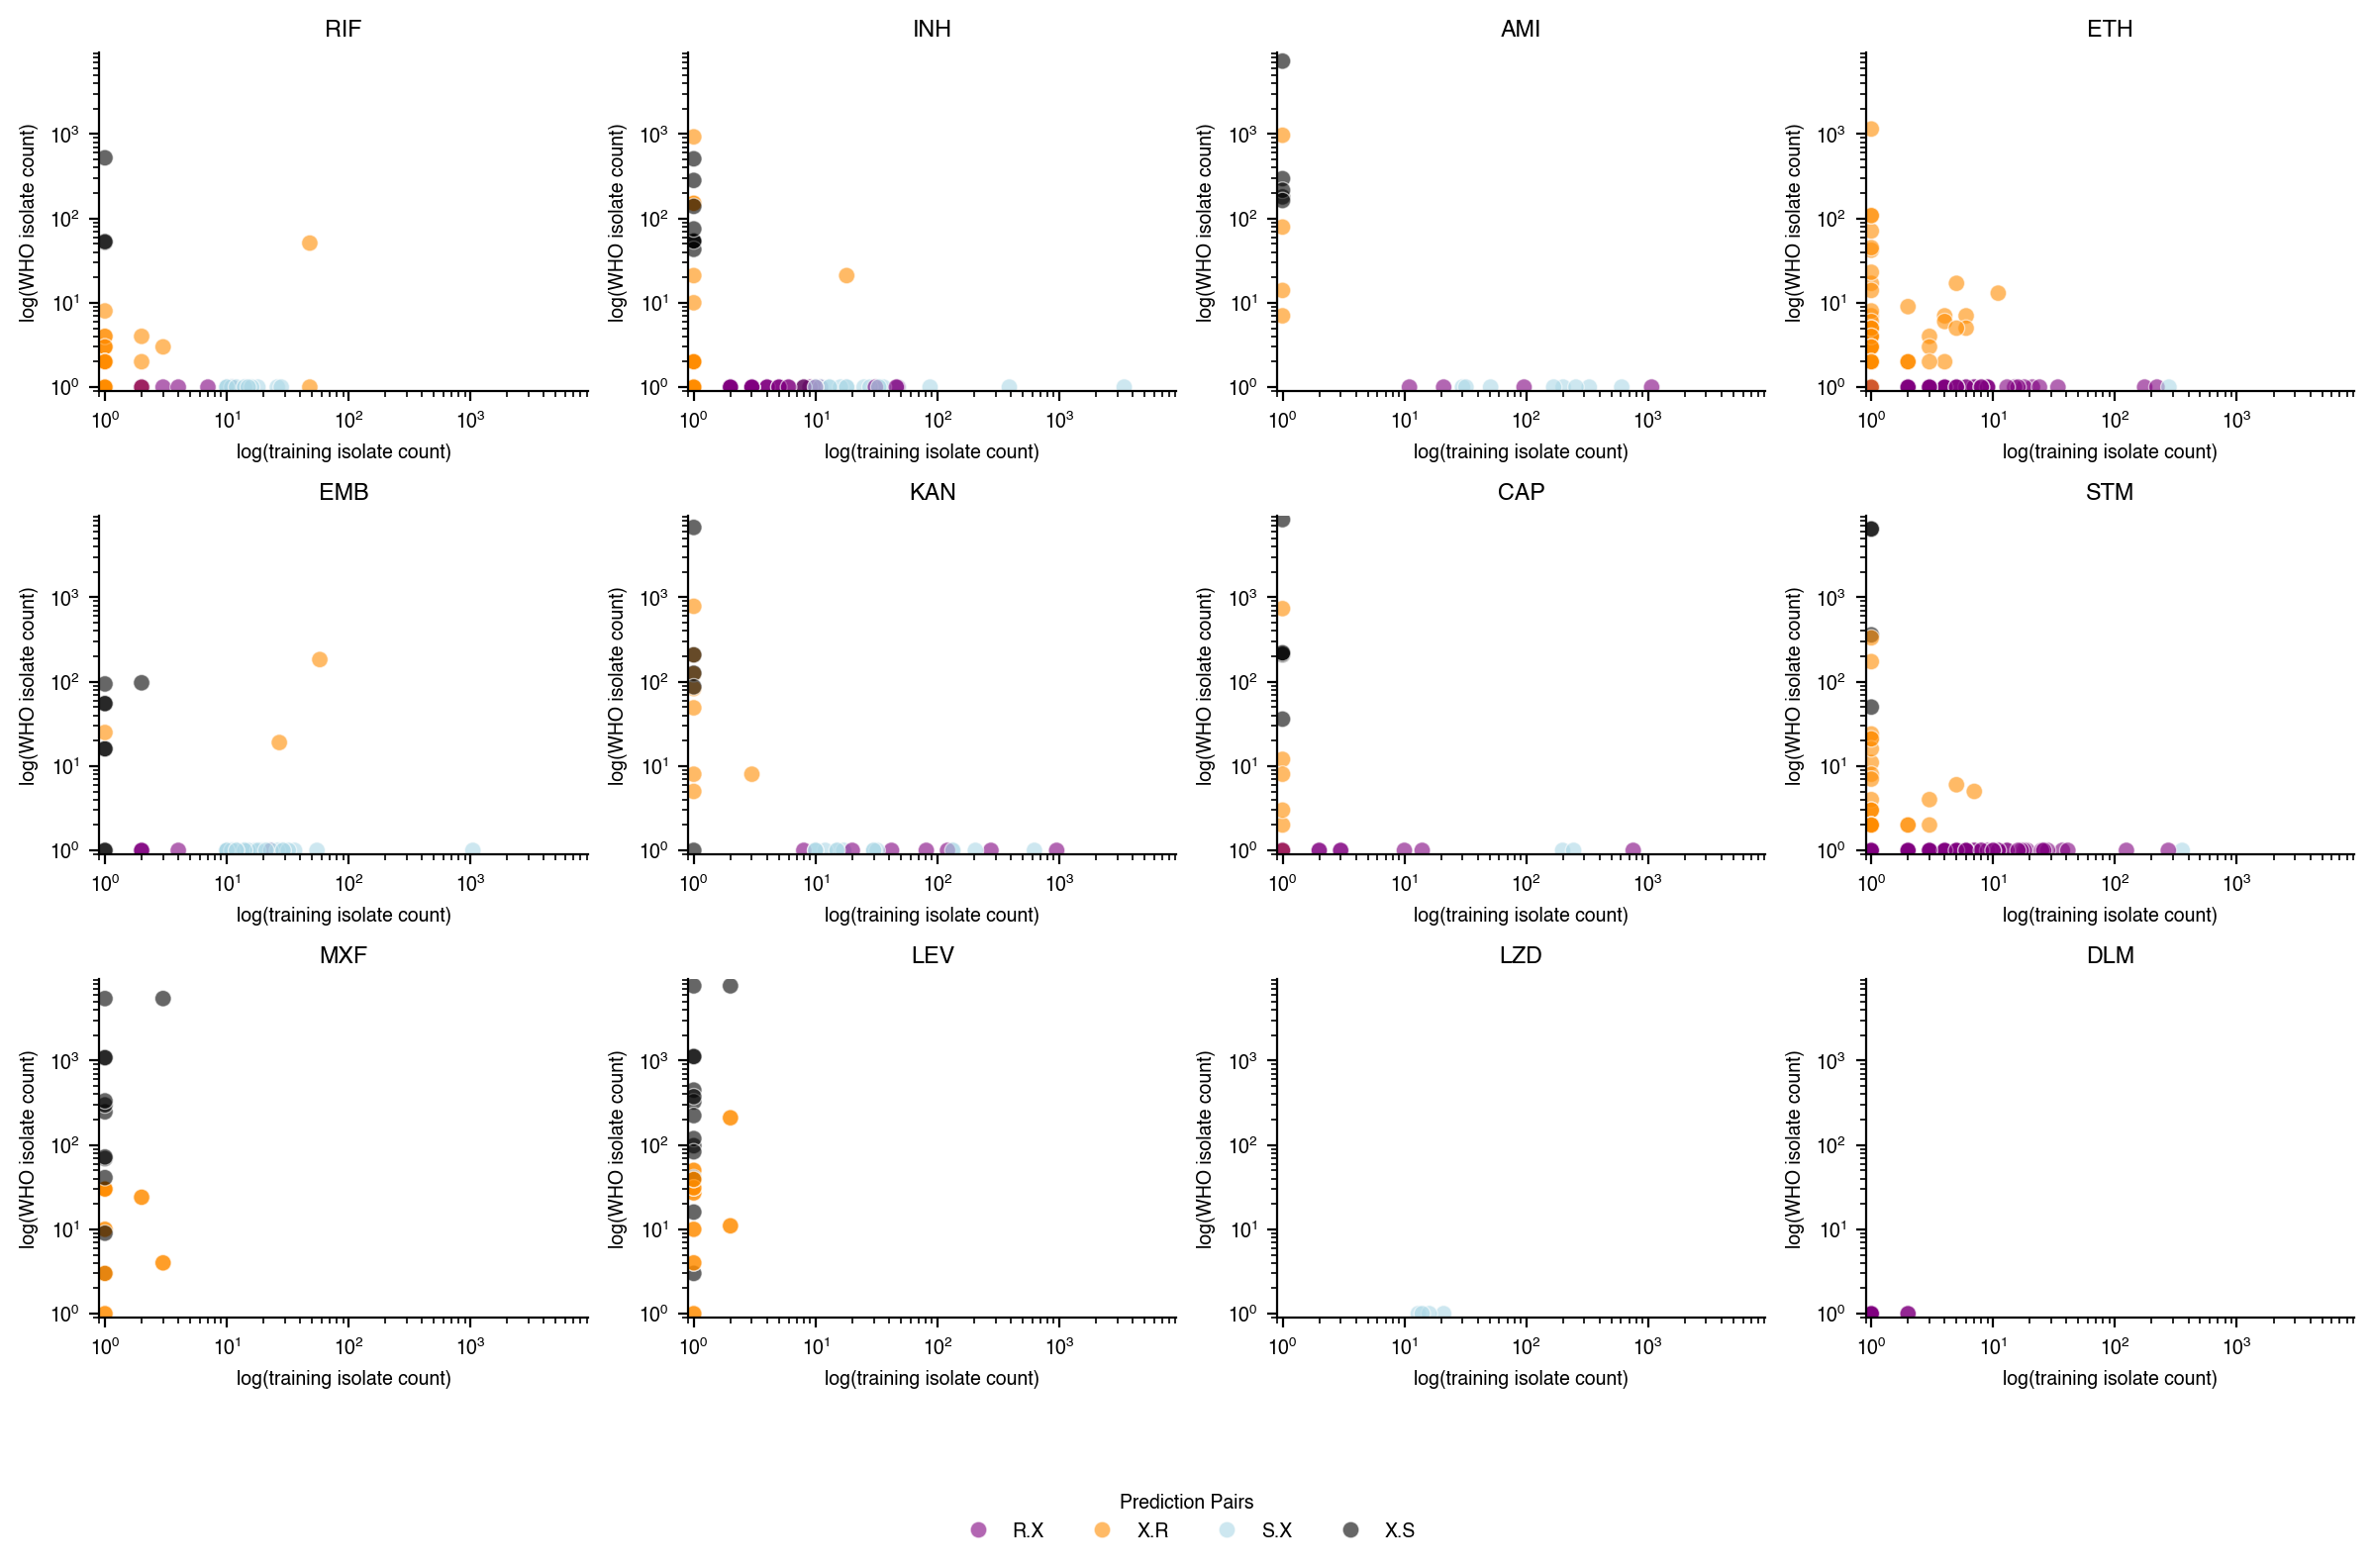

In [206]:
not_shared['x'] = not_shared['x'].fillna(1)
not_shared['y'] = not_shared['y'].fillna(1)

utils.plot_grid_counts(not_shared[(not_shared.EVIDENCE_who != {'expanded_rule'}) & (not_shared.EVIDENCE_cat != {'expanded_rule'})], valid_drugs, prediction_colors)

Need to understand sources of discrepency - analyse in detail.

In [ ]:
not_shared

index GENBANK_REFERENCE_who CATALOGUE_NAME_who  CATALOGUE_VERSION_who  \
0         0                   NaN                NaN                    NaN   
1         1           NC_000962.3                  -                    0.0   
2         2           NC_000962.3                  -                    0.0   
3         3           NC_000962.3                  -                    0.0   
4         4           NC_000962.3                  -                    0.0   
...     ...                   ...                ...                    ...   
1287      9                   NaN                NaN                    NaN   
1288     10                   NaN                NaN                    NaN   
1289     11                   NaN                NaN                    NaN   
1290     12                   NaN                NaN                    NaN   
1291     13                   NaN                NaN                    NaN   

     CATALOGUE_GRAMMAR_who PREDICTION_VALUES_who DRUG_who  \
0                      NaN                   NaN      NaN   
1                    GARC1                   RUS      RIF   
2                    GARC1                   RUS      RIF   
3                    GARC1                   RUS      RIF   
4                    GARC1                   RUS      RIF   
...                    ...                   ...      ...   
1287                   NaN                   NaN      NaN   
1288                   NaN                   NaN      NaN   
1289                   NaN                   NaN      NaN   
1290                   NaN                   NaN      NaN   
1291                   NaN                   NaN      NaN   

                              MUTATION PREDICTION_who SOURCE_who  ...  \
0     rpoB@1263_del_caaggagttcttcggcac            NaN        NaN  ...   
1                 rpoB@1274_del_cggcac              R         {}  ...   
2                      rpoB@1276_indel              R         {}  ...   
3              rpoB@1277_del_caccagcca              R         {}  ...   
4                      rpoB@1277_indel              R         {}  ...   
...                                ...            ...        ...  ...   
1287                         ddn@Q101!            NaN        NaN  ...   
1288                         ddn@W139!            NaN        NaN  ...   
1289                          ddn@W20!            NaN        NaN  ...   
1290                          ddn@W88!            NaN        NaN  ...   
1291                          ddn@W88R            NaN        NaN  ...   

                                           EVIDENCE_cat OTHER_cat  solo_R_who  \
0     {'proportion': 1.0, 'confidence': [0.425030609...        {}         NaN   
1                                                   NaN       NaN         0.0   
2                                                   NaN       NaN         NaN   
3                                                   NaN       NaN         1.0   
4                                                   NaN       NaN         NaN   
...                                                 ...       ...         ...   
1287  {'proportion': 1.0, 'confidence': [0.206549314...        {}         NaN   
1288  {'proportion': 1.0, 'confidence': [0.206549314...        {}         NaN   
1289  {'proportion': 1.0, 'confidence': [0.206549314...        {}         NaN   
1290  {'proportion': 1.0, 'confidence': [0.342380227...        {}         NaN   
1291  {'proportion': 1.0, 'confidence': [0.206549314...        {}         NaN   

      solo_S_who solo_R_cat solo_S_cat  PREDICTION_PAIR DRUG    x    y  
0            NaN        2.0        0.0              R.X  RIF  2.0  1.0  
1            1.0        NaN        NaN              X.R  RIF  1.0  1.0  
2            NaN        NaN        NaN              X.R  RIF  1.0  1.0  
3            0.0        NaN        NaN              X.R  RIF  1.0  1.0  
4            NaN        NaN        NaN              X.R  RIF  1.0  1.0  
...          ...        ...        .

## catomatic_v1 vs WHOv1 vs catomatic_v3 vs WHOv2 on crypticv3

Since WHOv1 and the first set of cryptic tables were released, more data has been accumulated. Training on this additional data could potentially boost our catalogue's performance, however we can't fairly compare its performance to either WHO catalogues as it would be trained on different data.

But we can compare all catalogues on an independent validation set, even if their training sets are different, as a fair performance benchmark.

#### Build catomatic-v3

As with crypticv1, need to run a parameter grid search and choose optimal catalogues on crypticv1.

In [101]:
#Generate catomatic catalogue on cryptic v1
grid_results_v3 = parallel_grid_search(
    "data/mutations-v3.1.0/",
    "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl",
    "data/cryptic-tables-v3.1.0/GENOMES.parquet",
    "data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet",
    "data/cryptic-tables-v3.1.0/MUTATIONS.parquet",
    "data/cryptic-tables-v3.1.0/VARIANTS.parquet",
    "catalogues/cryptic-v3.1.0/grid_search/",
    0.1,
    'v3.1.0',
    'v3.1.0',
    cores=10 #best to run with 1 core when first generating mutations and variants tables, as mem requirements are steep!!
)

/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:232: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:232: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:232: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:232: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:232: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0]

In [107]:
df = utils.flatten_grid_results(grid_results_v3)

opt_cats_v3 = utils.weighted_score(df).groupby("DRUG").head(1).reset_index(drop=True)
cat_counts = pd.DataFrame([
    {
        "DRUG": opt_cats_v3['DRUG'][i],
        "R": cat["PREDICTION"].value_counts().get("R", 0),
        "S": cat["PREDICTION"].value_counts().get("S", 0),
        "U": cat["PREDICTION"].value_counts().get("U", 0),
        "Total": len(cat)
    }
    for i in opt_cats_v3.index
    for cat in [pd.read_csv(f"./catalogues/cryptic-v3.1.0/grid_search/{opt_cats_v3['DRUG'][i].lower()}/bg_{opt_cats_v3['BACKGROUND_RATE'][i]}_p_{opt_cats_v3['p_value'][i]}_FRS_0.1.csv")]
])

opt_cats_v3 = pd.merge(opt_cats_v3, cat_counts, on='DRUG')
opt_cats_v3['catalogue'] = 'catomatic_v3'
opt_cats_v3

DRUG  BACKGROUND_RATE  p_value  SENSITIVITY  SPECIFICITY  COVERAGE  \
0   RIF             0.25     0.90     0.961642     0.982044  0.971163   
1   INH             0.25     0.90     0.948105     0.985451  0.955637   
2   LEV             0.25     0.90     0.936916     0.968150  0.886769   
3   STM             0.25     0.90     0.951566     0.933720  0.894246   
4   EMB             0.25     0.90     0.941615     0.901862  0.908926   
5   MXF             0.25     0.90     0.952410     0.903767  0.869240   
6   AMI             0.05     0.90     0.880575     0.982761  0.923277   
7   KAN             0.25     0.90     0.848869     0.974272  0.959656   
8   CAP             0.05     0.90     0.834307     0.973511  0.925862   
9   ETH             0.10     0.95     0.886416     0.902502  0.873721   
10  LZD             0.05     0.95     0.350340     0.997364  0.992469   
11  CIP             0.25     0.90     0.727273     0.953488  0.053571   
12  DLM             0.05     0.90     0.216418     0.999673  0.990707   

       Score    R   S     U  Total     catalogue  
0   0.969667   42  22   357    421  catomatic_v3  
1   0.960815   61  24   646    731  catomatic_v3  
2   0.936257   12  17   311    340  catomatic_v3  
3   0.934748   76  13   558    647  catomatic_v3  
4   0.923152   19  60  1000   1079  catomatic_v3  
5   0.921183   11  19   375    405  catomatic_v3  
6   0.919771   12   8   406    426  catomatic_v3  
7   0.908647    8  20   403    431  catomatic_v3  
8   0.894379   57   4   263    324  catomatic_v3  
9   0.888703  135   5   571    711  catomatic_v3  
10  0.672873    2   1    41     44  catomatic_v3  
11  0.660397    2   2     7     11  catomatic_v3  
12  0.606252   16   1    55     72  catomatic_v3

### Generate validation samples

In [108]:
crypticv3 = pd.read_parquet('data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet').reset_index()
validation_ids = crypticv3[(crypticv3.dataset=='CRyPTIC-v3.0')&(crypticv3.in_final_tables)].UNIQUEID.unique()
validation_ids_theory = crypticv3[(crypticv3.dataset=='CRyPTIC-v3.0')].UNIQUEID.unique()

print ('Number of matched validation samples:', len(validation_ids))
print ('Number of validation phenotypes:', len(validation_ids_theory))


Number of matched validation samples: 5827
Number of validation phenotypes: 8896


In [160]:
def process_performance(args):
    drug, genes, opt_cats_v1, validation = args
    FRS = 0.1
    results = []
    catalogues = {
        'WHOv1': 'catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS.csv',
        'WHOv2': 'catalogues/whov2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv',
        'catomatic_v1': f"./catalogues/cryptic-v1/grid_search/{drug.lower()}/bg_{opt_cats_v1.loc[opt_cats_v1.DRUG == drug, 'BACKGROUND_RATE'].iloc[0]}_p_{opt_cats_v1.loc[opt_cats_v1.DRUG == drug, 'p_value'].iloc[0]}_FRS_0.1.csv",
        'catomatic_v3': f"./catalogues/cryptic-v3.1.0/grid_search/{drug.lower()}/bg_{opt_cats_v3.loc[opt_cats_v3.DRUG == drug, 'BACKGROUND_RATE'].iloc[0]}_p_{opt_cats_v3.loc[opt_cats_v3.DRUG == drug, 'p_value'].iloc[0]}_FRS_0.1.csv",
    }
    #NEED TO PUT INDEPDNENT VALIDATION SET PATHS IN HERE!!!
    if drug in pd.read_csv(catalogues['WHOv2'])['DRUG'].unique():
        mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet')
        phenotypes = prep_phenotypes(
            drug,
            'data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl',
            'data/cryptic-tables-v3.1.0/GENOMES.parquet',
            'data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet',
            'v3.1.0',
            validation=validation
        )
        all_data = pd.merge(phenotypes, mutations[mutations.FRS >= FRS], on=['UNIQUEID'], how='left')
        if len(all_data)>0:
            for name, path in catalogues.items():
                cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all_data, drug=drug, catalogue_file=path, U_to_S=False, Print=False)
                results.append({
                    'DRUG': drug,
                    'catalogue': name,
                    'SENSITIVITY': sens,
                    'SPECIFICITY': spec,
                    'COVERAGE': cov
                })
    return results

def parallel_performance_evaluation(drug_genes, opt_cats_v1, validation=False):
    tasks = [(drug, genes, opt_cats_v1, validation) for drug, genes in drug_genes.items()]
    ctx = mp.get_context("fork")  # Works on Mac/Linux
    num_workers = min(10, len(tasks))  # Don't use more workers than tasks
    with ctx.Pool(num_workers) as pool:
        all_results = pool.map(process_performance, tasks)  # Run in parallel
    results_df = pd.DataFrame([item for sublist in all_results for item in sublist])

    return results_df



## Results comparison on entire dataset

In [161]:
results_all = parallel_performance_evaluation(drug_genes, opt_cats_v1, validation=False)

12482
16730
23422
14446
18182
22878
37596
13106
18033
43617
42931
13834


/Users/dylanadlard/miniforge3/envs/cryptic-catalogues-25/lib/python3.13/site-packages/seaborn/categorical.py:383: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(n - .5, -.5, auto=None)


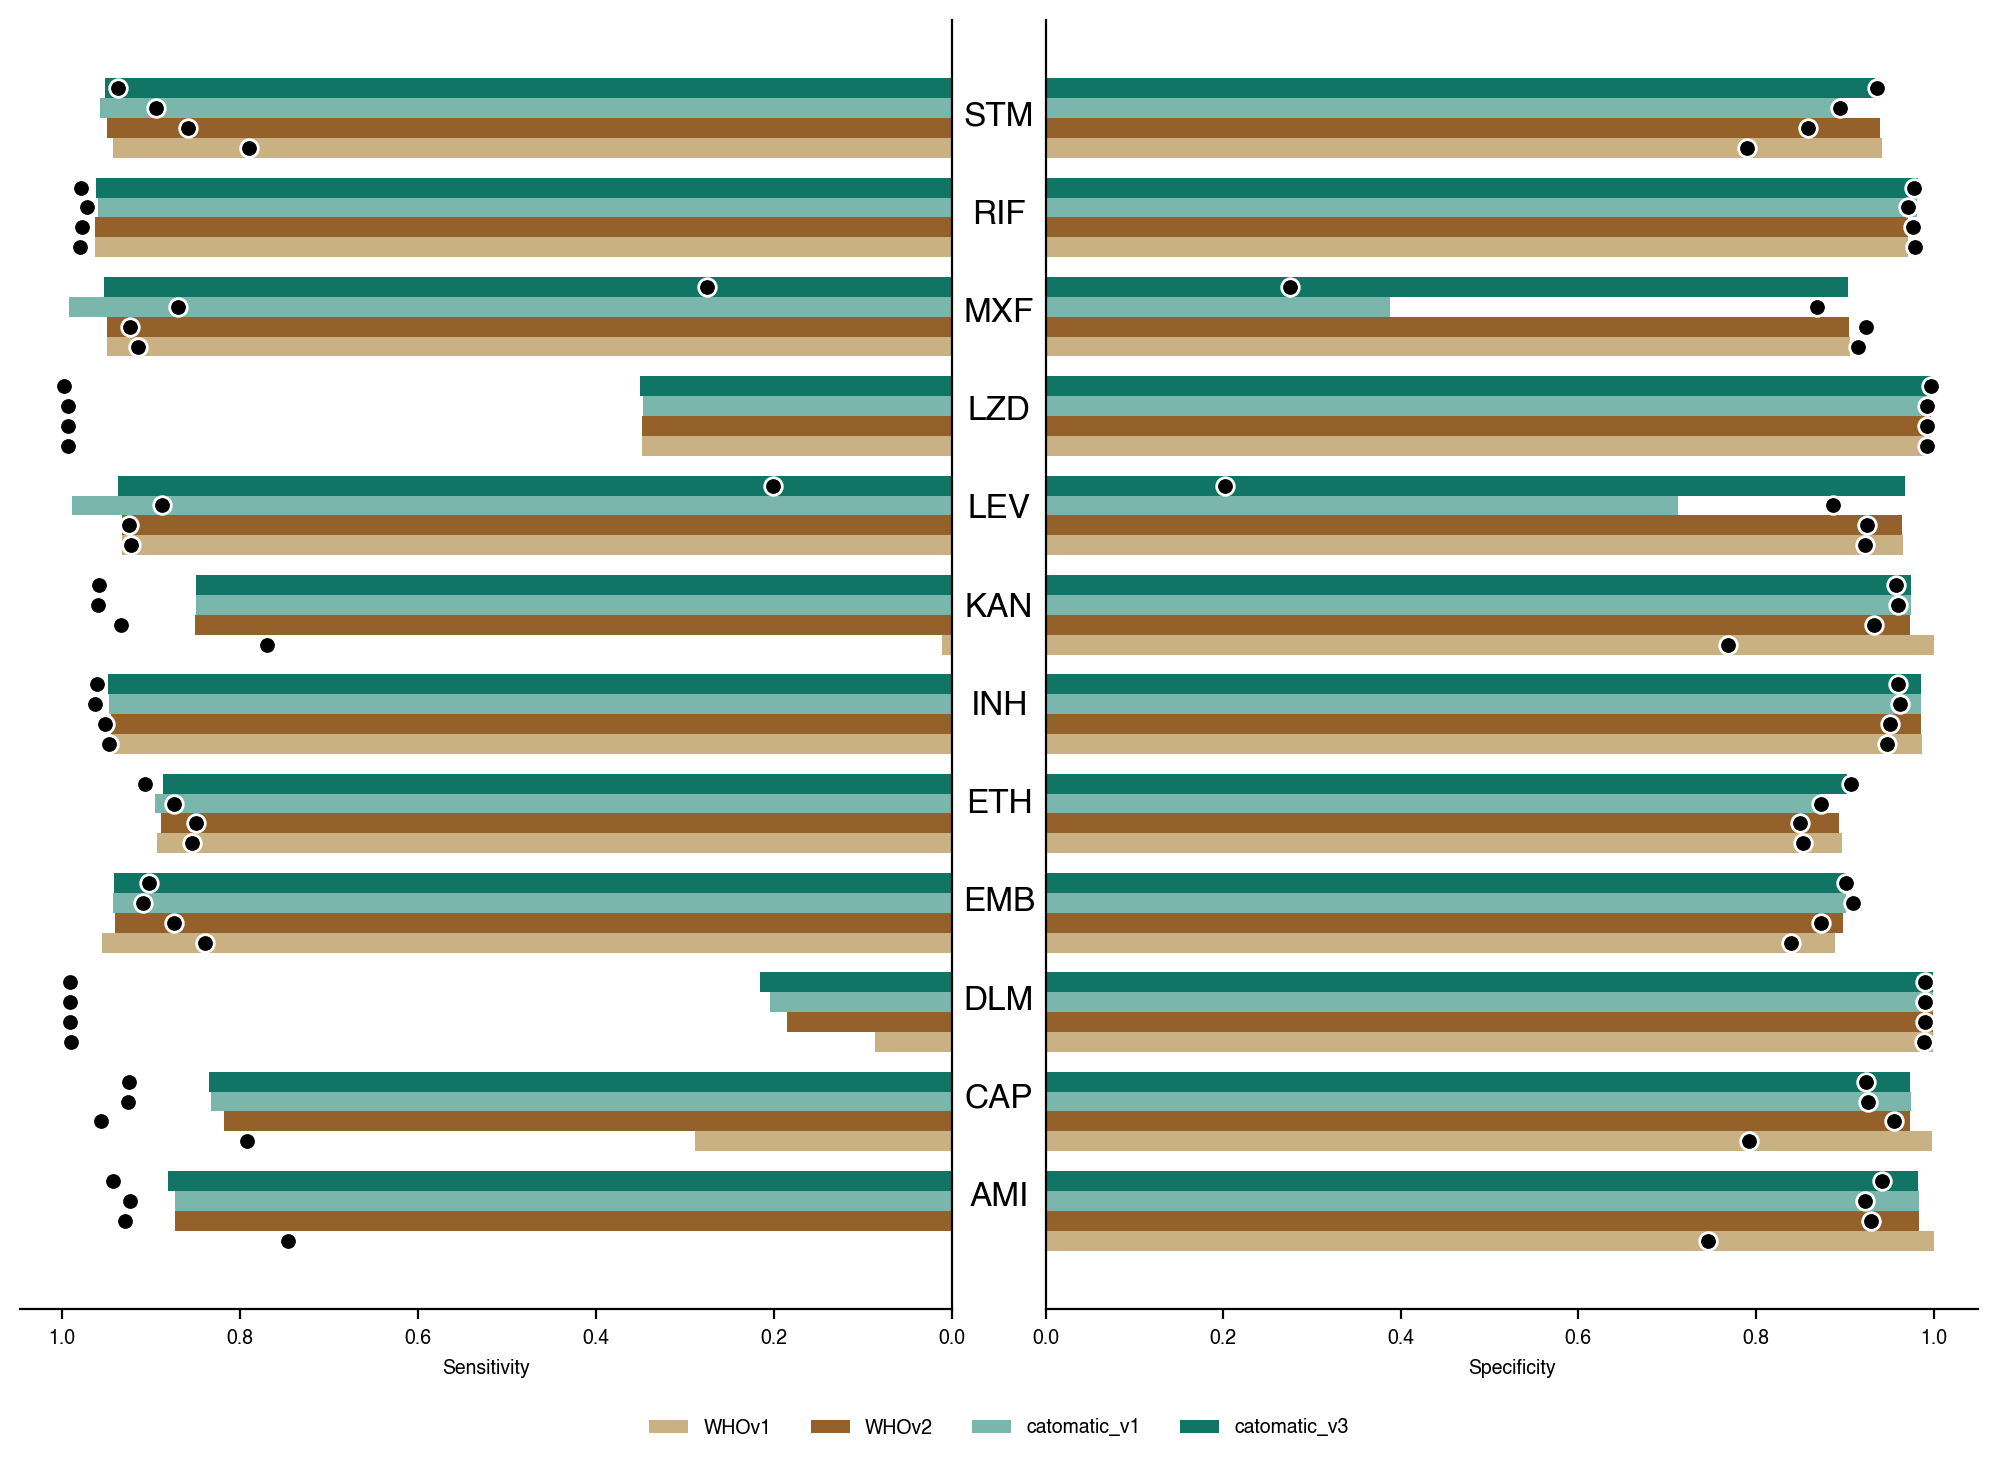

In [213]:
utils.back2back_sens_spec(results_all.sort_values(by=['DRUG', 'catalogue']), palette=catalogue_palette
)

## Results comparison on validation set

In [185]:
results_val = parallel_performance_evaluation(drug_genes, opt_cats_v1, validation=True)

547421

2306
2363
1478
1728
4083
4787
783
1543
0
4628


/Users/dylanadlard/miniforge3/envs/cryptic-catalogues-25/lib/python3.13/site-packages/seaborn/categorical.py:383: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(n - .5, -.5, auto=None)


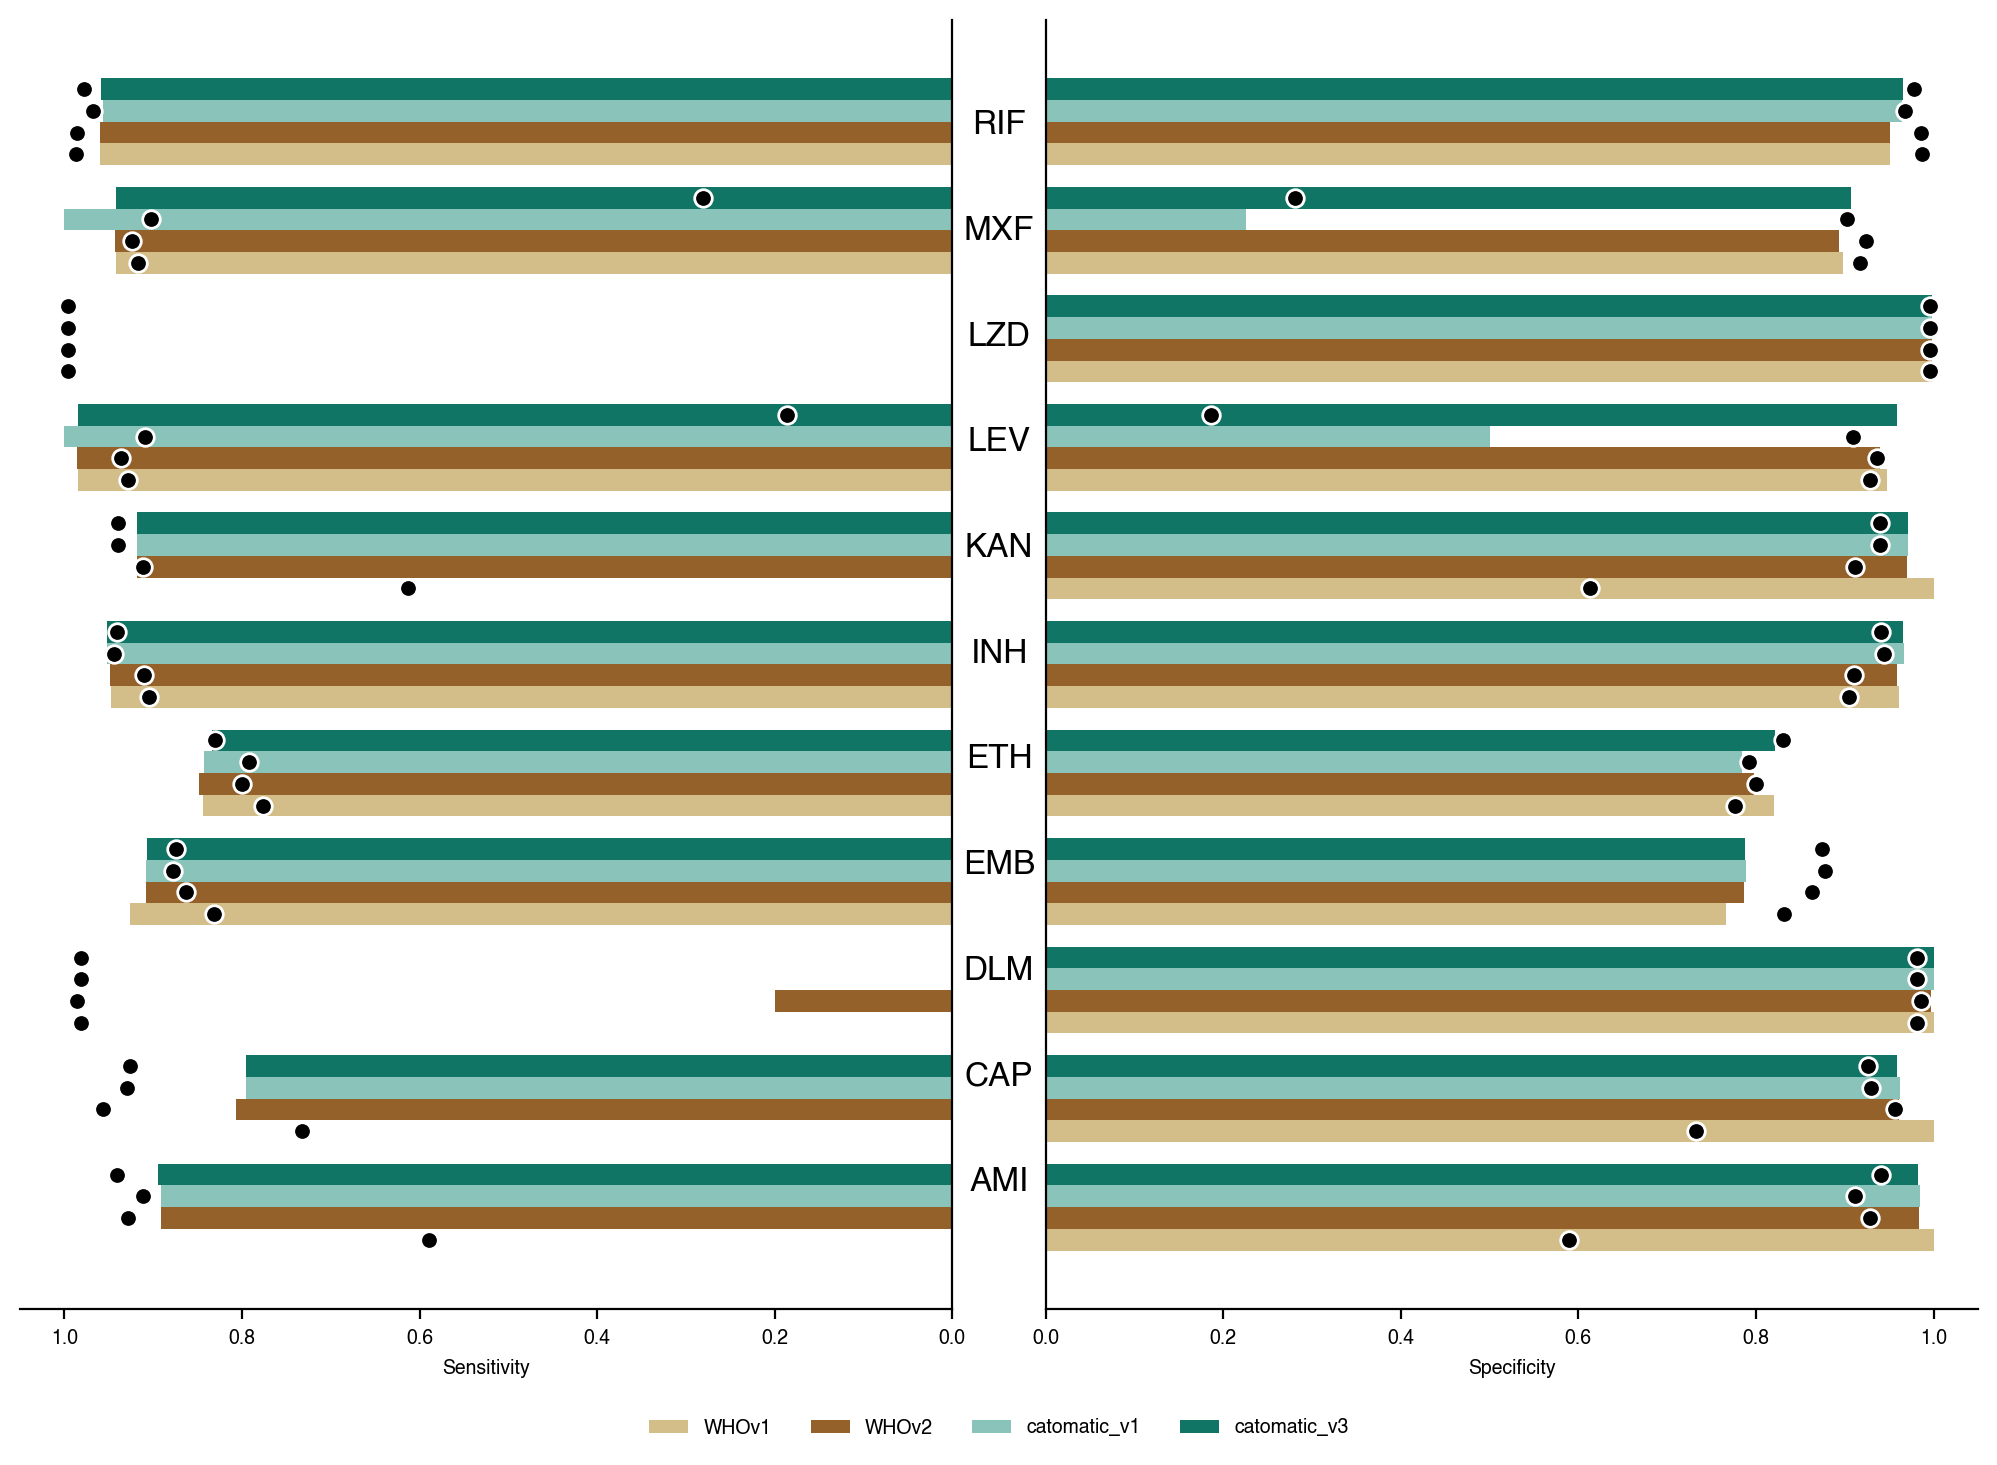

In [186]:
utils.back2back_sens_spec(results_val.sort_values(by=['DRUG', 'catalogue']), palette=catalogue_palette)


## Discordance analysis between catomatic_v1 and catomatic_v3